# Install and/or Import

In [ ]:
# !pip install scikit-learn
# !pip install stanza

In [1]:
import json
import re
import random
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from nltk import download
# download('punkt_tab')
# nltk.download('stopwords')
stop_words_nltk = stopwords.words('english')
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

import sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

stop_words = set(stop_words_nltk).union(set(ENGLISH_STOP_WORDS))

# Let's Do Stanza Separatetly

In [2]:
import stanza
stanza.download("en")
nlp = stanza.Pipeline("en", processors="tokenize, mwt, pos, lemma, depparse", verbose=True)

/Users/gene/Local/Python 3.9/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2025-02-19 15:22:35 INFO: Downloaded file to /Users/gene/stanza_resources/resources.json
2025-02-19 15:22:35 INFO: Downloading default packages for language: en (English) ...
2025-02-19 15:22:36 INFO: File exists: /Users/gene/stanza_resources/en/default.zip
2025-02-19 15:22:37 INFO: Finished downloading models and saved to /Users/gene/stanza_resources
2025-02-19 15:22:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-19 15:22:38 INFO: Downloaded file to /Users/gene/stanza_resources/resources.json
2025-02-19 15:22:38 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-02-19 15:22:38 INFO: Using device: cpu
2025-02-19 15:22:38 INFO: Loading: tokenize
2025-02-19 15:22:38 INFO: Loading: mwt
2025-02-19 15:22:38 INFO: Loading: pos
2025-02-19 15:22:40 INFO: Loading: lemma
2025-02-19 15:22:40 INFO: Loading: depparse
2025-02-19 15:22:40 INFO: Done loading processors!


# Upload LS-"discourse/register" Database

In [3]:
with open("lifestyle_full_db.json", "r") as file:
    lifestyle_full_db = json.load(file)

# print(lifestyle_full_db[0])

In [4]:
lifestyle_transcripts = []

for item in lifestyle_full_db:
    lifestyle_transcripts.append(item["transcript"])

# print(lifestyle_transcripts)
print(len(lifestyle_transcripts))

300


# Upload YT-"discourse/register" Database

In [5]:
with open("yt_register_full_db.json", "r") as file:
    yt_full_db = json.load(file)

In [6]:
yt_transcripts = []

for item in yt_full_db:
    yt_transcripts.append(item["transcript"])

print(len(yt_transcripts))
# print(yt_transcripts)

300


# Pre-Processing the Data (Transcripts)
Since further analysis rvealed some weird artifacts of speech recognition
(when 1 and the same word or phrase repeats in the transcript an insane amount of times, which messes up the results),
we're going to do a bit of "manual" preprocessing here.

In [7]:
lifestyle_transcripts = [re.sub(r'(I got it\. ?)+', r'I got it. ', item) for item in lifestyle_transcripts]
lifestyle_transcripts = [re.sub(r'(So you can do it on a Thursday\. ?)+', r'So you can do it on a Thursday. ', item) for item in lifestyle_transcripts]
lifestyle_transcripts = [re.sub(r"(I'm not sure I understand this\. ?)+", r"I'm not sure I understand this. ", item) for item in lifestyle_transcripts]

In [8]:
yt_transcripts = [re.sub(r"(I'm gonna start cooking\. ?)+", r"I'm gonna start cooking. ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(Bienvenido\. ?)+", r" ", item) for item in yt_transcripts] # Bienvenido has nothing to do with the things we're analyzing, so we can nuke it completely
yt_transcripts = [re.sub(r"(Billy\? ?)+", r" ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(And that's what you're going to be able to do\. ?)+", r"And that's what you're going to be able to do. ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(?<=We could use\s).+(?=My camera storage)", r"a little bit of ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(?<=I'm going to do a little bit of\s).+(?=and whites are done)", r" ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(I agree\. ?)+", r"I agree. ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(I'm going to be surprised\. ?)+", r" ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(Yes! ?)+", r"Yes! ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(Let's go! ?)+", r"Let's go! ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(Bam! ?)+", r"Bam! ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(I'm going to go for the 10\. ?)+", r"I'm going to go for the 10. ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(I think that's a good thing\. ?)+", r"I think that's a good thing. ", item) for item in yt_transcripts]
yt_transcripts = [re.sub(r"(My favorite\. ?)+", r"My favorite. ", item) for item in yt_transcripts]




# Just-in-Case Very Basic Tokenization

In [10]:
# Simple tokenization just in case
# Tokenize keeping colloquial forms (like "gonna") intact (hence Tweet Tokenizer)

# def tokenize_text(text):
    # interim = tokenizer.tokenize(text.lower())
    # tokens = [item for item in interim if item not in stop_words and item.isalpha()]
    # return tokens

# Transcripts to Stanza Docs

In [9]:
# Let the fun begin!
# Let's convert all the texts into stanza annotated documents.
# from tqdm import tqdm

def make_stanza_docs(transcrips):
    annotated_docs = [nlp(item) for item in tqdm(
                                                transcrips,
                                                desc="Stanza-zing Your Transcripts. It's gonna be a minute..."
                                                )
                        ]
    return annotated_docs

In [ ]:
# Lets get the annotated texts for the "Lifestyle Corpus"

ls_annotated_docs = make_stanza_docs(lifestyle_transcripts)
yt_annotated_docs = make_stanza_docs(yt_transcripts)

Stanza-zing Your Transcripts. It's gonna be a minute...: 100%|██████████| 300/300 [15:37<00:00,  3.12s/it]
Stanza-zing Your Transcripts. It's gonna be a minute...: 100%|██████████| 300/300 [20:47<00:00,  4.16s/it]  


In [ ]:
# Let's check if it looks legit
print(ls_annotated_docs[0])
print(yt_annotated_docs[0])

# Lemmatizing the Corpora

In [11]:
# Lemmatizing from an annotated (stanz-ized) doc (while also optionally removing the stop-words and unnecessary symbols like punctuation)

def lemmatize_text(doc, remove_stopwords=True):
    if remove_stopwords:
        list = [word.lemma.lower() for sentence in doc.sentences for word in sentence.words]
        text = " ".join(item for item in list if item.isalpha() and item not in stop_words)
    else:
        text = " ".join(word.lemma.lower() for sentence in doc.sentences for word in sentence.words if word.lemma.isalpha())
    return text

In [12]:
# Iterating over all the annotated docs and lemmatizing them

def lemmatize_corpus(annotated, remove_stopwords=True):
    corpus = []
    for doc in annotated:
        corpus.append(lemmatize_text(doc, remove_stopwords))
    return corpus

In [13]:
# Creating a "clean" corpus (no stop words)
# ls_corpus = the "Lifestyle Corpus"
# yt_corpus = the "YouTube Corpus"

lemmatized_ls_corpus = lemmatize_corpus(ls_annotated_docs)
lemmatized_yt_corpus = lemmatize_corpus(yt_annotated_docs)

In [14]:
# Creating a version of the lemmatized corpora -- the "full" corpora (with stop words)

lemmatized_ls_corpus_sw = lemmatize_corpus(ls_annotated_docs, remove_stopwords=False)
lemmatized_yt_corpus_sw = lemmatize_corpus(yt_annotated_docs, remove_stopwords=False)

In [16]:
# Let's double-check that everything looks legit

print(lemmatized_ls_corpus[0])
print(lemmatized_ls_corpus_sw[0])

print(lemmatized_yt_corpus[0])
print(lemmatized_yt_corpus_sw[0])

believe actually tell tell anybody important year old affair marry woman kid thing ashamed think like asshole stupid stupid fact good right apparently like think good good want tell thing learn hard way type guy learn hard way right know dui dui like idiot need thing hopefully smart today guy type woman sleep number anybody marry matter hot matter bad home different talk right story stop flirt married woman period right know lead honestly actually know lead good want want leave want future honestly cheat guy guy person outlet want leave fine want okay absolutely number woman child right like wait second al kind dick say deal firm believer unless willing ready commit father parent mess woman child date know kid know weiner child red flag like huge like wave flash red flag introduce kid early like game like pass stop number coworker period right like alpho hot matter date coworker sleep somebody think hot like oh flirt hard lunch business trip kind stop stop lie think work work bad oh ma

In [17]:
# Defining a function to create a text only made up of nouns
# (arguably, for better "thematic classification" that we're going to attempt below)

def lemmatize_text_to_nouns(doc):
    list = [
            word.lemma.lower()
            for sentence in doc.sentences
            for word in sentence.words
            if word.upos == "NOUN"
            ]
    text = " ".join(item for item in list
                    if item not in stop_words
                    )
    return text

In [18]:
# Applying the "lemmatize to nouns" to all the documents/texts in a corpus

def lemmatize_corpus_to_nouns(annotated):
    corpus = []
    for doc in annotated:
        corpus.append(lemmatize_text_to_nouns(doc))
    return corpus

In [19]:
# Let's write the "noun-corpus" to a respective variable

lemmatized_ls_corpus_nouns = lemmatize_corpus_to_nouns(ls_annotated_docs)
lemmatized_yt_corpus_nouns = lemmatize_corpus_to_nouns(yt_annotated_docs)

In [20]:
# Let's double-check that everything looks legit

print(lemmatized_ls_corpus_nouns[0])
print(lemmatized_yt_corpus_nouns[0])

year affair woman kid thing asshole fact thing way type guy way dui dui idiot thing today guy type woman number home story woman period future guy guy person outlet number woman child kind dick deal firm believer father parent woman child kid weiner child flag flag kid game number coworker period coworker lunch business trip kind mama trouble job time accounting appropriator gentlemen risk thing ex way breakup second feeling mind situation reason time standard ramification wiener thing standard piece ass ass term relationship partner partner partner spider web person deal std shampoo person population person std ass slut rascal game game care kid piece shit problem problem person hygiene breath body odor opinion ad cookie ball ball powder day gentlemen ball guy ad ball powder pre-roll video bit bit guy ball powder link discount code help ball person circumstance issue deal issue sex basket case lot issue addict woman problem tire morning account person guy thing person buddy ex-girlfri

# Vecotizing the Corpora & Extracting the Values

## Defining the Functions

In [21]:
# Lets define a function to vectorize the texts ("documents")
# n-count specifies n-grams (1,2,3)
# the function returns the tf-idf matrix and a list of "feature names"
# (aka items or tokens that are used in the matrix)

def vectorize(corpus, n_count):
    vectorizer = TfidfVectorizer(ngram_range=(1, n_count))
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

In [22]:
# Let's define a function to extract the data from the vectorized documents/corpus
# "n-count" must match the count used when vectorizing (max = 3)
# "top" defines the number of most freaquent items that we need to extract for each text ("document") (default/max = 20)
# "vectorized" is the tf-idf matrix we get as output[0] of the "vectorize" function above

def get_vectorized_data(vectorized, n_count, top=20):
    tfidf_scores = []
    
    if n_count <= 3 and top <= 20:
        for document, vector in enumerate(vectorized[0]):
            tfidf_scores.append([document])

            scores = zip(vectorized[1], vector.toarray().flatten())
            sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
            
            bi = None
            tri = None
            uni = sorted_scores

            if n_count > 1:
                uni = [item for item in sorted_scores if " " not in item[0]]
                bi = [item for item in sorted_scores if item[0].count(" ") == 1]
                tri = None
            if n_count > 2:
                tri = [item for item in sorted_scores if item[0].count(" ") == 2]
            
            d = document * top
            i = 0
            while i < top:
                if i == 0:
                    tfidf_scores[d].extend([uni[i][0], uni[i][1]])
                    if bi != None:
                        tfidf_scores[d].extend([bi[i][0], bi[i][1]])
                    if tri != None:
                        tfidf_scores[d].extend([tri[i][0], tri[i][1]])
                else:
                    tfidf_scores.append([document])
                    tfidf_scores[d + i].extend([uni[i][0], uni[i][1]])
                    if bi != None:
                        tfidf_scores[d + i].extend([bi[i][0], bi[i][1]])
                    if tri != None:
                        tfidf_scores[d + i].extend([tri[i][0], tri[i][1]])
                i += 1
    
    else:
        print("'n_count' or 'top' is out of ranage!")
    
    return tfidf_scores

## Processing the Corpora

### Processing the Lifestyle Corpus ("ls-corpus")

In [23]:
# Vecorizing (a) the clean lifestyle ("ls") corpus,
# (b) the ls-corpus with the stop-words kept intact and
# (c) the noun-based ls-corpus

# Writing the results into the respective variables
# The n-gram counts used are 3 for the clean and stop-words-inclusive and 1 for noun-based (naturally)
# Writtten to the 3 variables below are the tf-idf matrices ([0]) and "feature names" ([1])

vectorized_ls_corpus = vectorize(lemmatized_ls_corpus, 3)
vectorized_ls_corpus_sw = vectorize(lemmatized_ls_corpus_sw, 3)
vectorized_ls_corpus_nouns = vectorize(lemmatized_ls_corpus_nouns, 1)

In [24]:
# Extracting the most frequent items and their values in terms their tf-idf scores
# Let's go for the "top 15" (because why not?)
# Written to the three variables below are list of sublists where each sublist contains

# - the number of the document/text at index [0]
# - the "feature name" (item) at index [1]
# - and the tf-idf score of said item at index [2]

# NB: this steps takes some time even on a relatively capable CPU

thematic_ls_corpus = get_vectorized_data(vectorized_ls_corpus, 3, 15)
thematic_ls_corpus_sw = get_vectorized_data(vectorized_ls_corpus_sw, 3, 15)
thematic_ls_corpus_nouns = get_vectorized_data(vectorized_ls_corpus_nouns, 1, 15)

In [25]:
print(thematic_ls_corpus[:10])
print(thematic_ls_corpus_sw[:10])
print(thematic_ls_corpus_nouns[:10])

# A quick cursory look a the the results tells us that the version of the corpus with the stop-words
# does not seem to be representative of the contents of the text at all
# and should probably be discarded

[[0, 'like', np.float64(0.16545422741431792), 'person sexy', np.float64(0.07208542041154345), 'learn hard way', np.float64(0.061102446006528914)], [0, 'somebody', np.float64(0.12191796830542809), 'think hot', np.float64(0.07208542041154345), 'bring somebody sleep', np.float64(0.04805694694102896)], [0, 'sleep', np.float64(0.09219806574469297), 'like oh', np.float64(0.06475370464849212), 'pedro ball powder', np.float64(0.04481691787633102)], [0, 'know', np.float64(0.08848584503486134), 'hard way', np.float64(0.061102446006528914), 'pete pedro ball', np.float64(0.04481691787633102)], [0, 'ball', np.float64(0.08268211860161721), 'learn hard', np.float64(0.061102446006528914), 'know look good', np.float64(0.040734964004352614)], [0, 'want', np.float64(0.08044167730441941), 'ball powder', np.float64(0.05891707740888449), 'like oh god', np.float64(0.039278051605922994)], [0, 'jealous', np.float64(0.07855610321184599), 'bring need', np.float64(0.04805694694102896), 'absolutely number woman', 

# Comparing / Visualizing the "Thematic Classification" Data

## The Lifestyle Corpus

In [27]:
# Let's put the results of the "thematic analysis" of the clean ls-corpus into a DataFrame
 
thematic_ls_corpus_df = pd.DataFrame(thematic_ls_corpus, columns = ["Text No.", "Uni-Grams", "Uni-Values", "Bi-Grams", "Bi-Values", "Tri-Grams", "Tri-Values"])
thematic_ls_corpus_df.iloc[0:50]

Text No.  Uni-Grams  Uni-Values           Bi-Grams  Bi-Values  \
0          0       like    0.165454        person sexy   0.072085   
1          0   somebody    0.121918          think hot   0.072085   
2          0      sleep    0.092198            like oh   0.064754   
3          0       know    0.088486           hard way   0.061102   
4          0       ball    0.082682         learn hard   0.061102   
5          0       want    0.080442        ball powder   0.058917   
6          0    jealous    0.078556         bring need   0.048057   
7          0      right    0.076929     bring somebody   0.048057   
8          0      flirt    0.073958         hot matter   0.048057   
9          0   pregnant    0.072085     jealous person   0.048057   
10         0       sexy    0.069005             new ad   0.048057   
11         0        hot    0.066066     period scumbag   0.048057   
12         0      crazy    0.065028     sleep somebody   0.048057   
13         0      drunk    0.063777  somebody pregnant   0.048057   
14         0      smell    0.063448     somebody sleep   0.048057   
15         1      cheap    0.290069       high quality   0.086487   
16         1       like    0.148243    personally feel   0.072144   
17         1    quality    0.109882        cheap jeans   0.061738   
18         1  insurance    0.084902            bad ass   0.054108   
19         1       high    0.081835         wear cheap   0.054108   
20         1     invest    0.073457         money high   0.052411   
21         1       good    0.070415           run shoe   0.049644   
22         1    opinion    0.066940       hair product   0.048485   
23         1    product    0.061996    make difference   0.048485   
24         1      right    0.059494   critical upgrade   0.044134   
25         1      super    0.058778   difference cheap   0.044134   
26         1  deodorant    0.055226      opinion cheap   0.044134   
27         1       shoe    0.054685            tin veg   0.044134   
28         1    eyewear    0.054108            veg ger   0.044134   
29         1    premium    0.053213    huge difference   0.044021   
30         2       belt    0.198657           ant belt   0.135063   
31         2        ant    0.173652         young dude   0.118776   
32         2       look    0.128495         belt right   0.059388   
33         2       wear    0.125216        finish look   0.057884   
34         2       like    0.110175         dress shoe   0.054996   
35         2      right    0.104040          build box   0.053981   
36         2       dude    0.093041        button make   0.053981   
37         2      dress    0.087774          let woman   0.053981   
38         2       stop    0.081478         look cheap   0.049065   
39         2     buckle    0.079256         right belt   0.049065   
40         2      brown    0.078425       fake leather   0.047310   
41         2      young    0.075256        black dress   0.043407   
42         2      black    0.075151            box set   0.042393   
43         2    mistake    0.075000      casual jacket   0.040638   
44         2       teen    0.072346          look good   0.040634   
45         3       like    0.208915          make look   0.134290   
46         3       look    0.153818         look weird   0.094877   
47         3      young    0.152094         look young   0.073860   
48         3      weird    0.104508          dude look   0.066014   
49         3        old    0.100490        awkward old   0.064342   

                  Tri-Grams  Tri-Values  
0            learn hard way    0.061102  
1      bring somebody sleep    0.048057  
2         pedro ball powder    0.044817  
3           pete pedro ball    0.044817  
4            know look good    0.040735  
5               like oh god    0.039278  
6   absolutely number woman    0.024028  
7       account crazy bring    0.024028  
8     accounting right like    0.024028  
9        actually know lead    0.024028  
10        actually say

In [29]:
# Now let's do the same for the noun-based corpus

thematic_ls_corpus_nouns_df = pd.DataFrame(thematic_ls_corpus_nouns, columns = ["Text No.", "Nouns", "Values"])
thematic_ls_corpus_nouns_df.loc[0:50]

Text No.       Nouns    Values
0          0        ball  0.318372
1          0       woman  0.233606
2          0          ex  0.201001
3          0      person  0.196385
4          0         dui  0.182965
5          0       child  0.174177
6          0     scumbag  0.170630
7          0         std  0.170630
8          0      period  0.168867
9          0      powder  0.167143
10         0         kid  0.157973
11         0    coworker  0.155089
12         0     partner  0.154014
13         0          ad  0.140790
14         0         ass  0.138893
15         1     quality  0.340514
16         1   insurance  0.262082
17         1     opinion  0.206634
18         1     product  0.191376
19         1   deodorant  0.170475
20         1        shoe  0.168807
21         1     eyewear  0.167025
22         1       money  0.161280
23         1         dog  0.153247
24         1        suit  0.144919
25         1  difference  0.142172
26         1       stuff  0.141120
27         1        term  0.136371
28         1         ger  0.136237
29         1         tin  0.136237
30         2        belt  0.488688
31         2         ant  0.421816
32         2        dude  0.214522
33         2      buckle  0.197267
34         2     mistake  0.182181
35         2        teen  0.180324
36         2       dress  0.166991
37         2   gentlemen  0.164653
38         2     leather  0.155677
39         2        shoe  0.145183
40         2      jacket  0.144678
41         2  undershirt  0.131619
42         2       style  0.119494
43         2       thing  0.114302
44         2      button  0.099231
45         3        hair  0.368780
46         3        dude  0.307237
47         3         jet  0.201162
48         3       thing  0.200081
49         3     opinion  0.174208
50         3      filler  0.153020

## Pairing the Results for Grams and Nouns (for the LS-Corpus)
## Looking at the Results for Random Texts

In [30]:
# Combining the results for n-gramms and nouns
# Pairing random texts (and their results) with video titles
# (To see if these result reflect the texts thematically)

thematic_ls_merged_corpus = [ngram_item + noun_item[1:] for ngram_item, noun_item in zip(thematic_ls_corpus, thematic_ls_corpus_nouns)]


In [31]:
# Let's double-check that the results of merging look legit

print(thematic_ls_merged_corpus[:10])

[[0, 'like', np.float64(0.16545422741431792), 'person sexy', np.float64(0.07208542041154345), 'learn hard way', np.float64(0.061102446006528914), 'ball', np.float64(0.3183722355847071)], [0, 'somebody', np.float64(0.12191796830542809), 'think hot', np.float64(0.07208542041154345), 'bring somebody sleep', np.float64(0.04805694694102896), 'woman', np.float64(0.23360556783727227)], [0, 'sleep', np.float64(0.09219806574469297), 'like oh', np.float64(0.06475370464849212), 'pedro ball powder', np.float64(0.04481691787633102), 'ex', np.float64(0.20100118695988084)], [0, 'know', np.float64(0.08848584503486134), 'hard way', np.float64(0.061102446006528914), 'pete pedro ball', np.float64(0.04481691787633102), 'person', np.float64(0.19638478203615425)], [0, 'ball', np.float64(0.08268211860161721), 'learn hard', np.float64(0.061102446006528914), 'know look good', np.float64(0.040734964004352614), 'dui', np.float64(0.18296542322832207)], [0, 'want', np.float64(0.08044167730441941), 'ball powder', n

In [32]:
# Let's define a function to pull the title of the text/video from the corpus database and pair it with the tf-idf-based data

# (if "random" has not been imported yet)
# import random

def display_text_thematic_data(thematic_corpus, db, text_number=None):
    if text_number is None:
        text_number = random.randint(0, (len(db)-1))
    
    title = db[text_number]["title"]
    data = [[item[0]] + [title] + item[1:] for item in thematic_corpus if item[0] == text_number]
    
    return data


In [33]:
# Now we can run this command multiple times to see whether the tf-idf-based data is going to match the title of the text
# (At least on the surface)
# (Each time the command is run, a rundom text is chosen and the results are displayed)
# The results are written into a variable and are displayed in a "human-readable" way in the next step (as a DF) 

text_thematic_data = display_text_thematic_data(thematic_ls_merged_corpus, lifestyle_full_db)

In [34]:
text_thematic_data_df = pd.DataFrame(text_thematic_data,
                                       columns = ["Text No.",
                                                  "Title",
                                                  "Uni-Grams",
                                                  "Uni-Values",
                                                  "Bi-Grams",
                                                  "Bi-Values",
                                                  "Tri-Grams",
                                                  "Tri-Values",
                                                  "Nouns",
                                                  "Noun Values"]
                                        )

print(f"The Title of the Text/Video: \n{text_thematic_data[0][1]}")
text_thematic_data_df

The Title of the Text/Video: 
Steal the Ultimate Cowboy Look! Add Raw Masculinity to Your Style Instantly


Text No.                                              Title Uni-Grams  \
0        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...   western   
1        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...      boot   
2        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...    cowboy   
3        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...      wear   
4        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...   ticovas   
5        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...      gent   
6        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...     jeans   
7        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...     roper   
8        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...     shaft   
9        198  Steal the Ultimate Cowboy Look! Add Raw Mascul...      ride   
10       198  Steal the Ultimate Cowboy Look! Add Raw Mascul...      yoke   
11       198  Steal the Ultimate Cowboy Look! Add Raw Mascul...     horse   
12       198  Steal the Ultimate Cowboy Look! Add Raw Mascul...       toe   
13       198  Steal the Ultimate Cowboy Look! Add Raw Mascul...     style   
14       198  Steal the Ultimate Cowboy Look! Add Raw Mascul...  material   

    Uni-Values                Bi-Grams  Bi-Values  \
0     0.299556            western wear   0.100622   
1     0.218950            western boot   0.080555   
2     0.157873            western belt   0.067833   
3     0.113849               boot make   0.060756   
4     0.101750             cowboy boot   0.060015   
5     0.077174             snap button   0.060015   
6     0.073227           western jeans   0.050875   
7     0.071873         classic western   0.047445   
8     0.067129              little bit   0.035375   
9     0.064575          bovine leather   0.033917   
10    0.057498           check ticovas   0.033917   
11    0.057356  functional lightweight   0.033917   
12    0.055933               gent boot   0.033917   
13    0.054449         hand individual   0.033917   
14    0.051894         intricate metal   0.033917   

                      Tri-Grams  Tri-Values     Nouns  Noun Values  
0                boot make ride    0.033917      boot     0.507146  
1          classic western belt    0.033917    cowboy     0.370100  
2              lot western wear    0.033917      wear     0.184291  
3          make hand individual    0.033917      gent     0.181635  
4            western wear shirt    0.033917     jeans     0.168753  
5                fit close body    0.031630     roper     0.165633  
6            style western boot    0.031630     shaft     0.159709  
7             little bit softer    0.026852      yoke     0.132506  
8                right let talk    0.022942     horse     0.132178  
9               want little bit    0.019451       toe     0.128898  
10              able bodied man    0.016958      snap     0.127767  
11              able kick thing    0.016958     style     0.126813  
12               able pull gent    0.016958  material     0.119590  
13         abrasion type jacket    0.016958      belt     0.118851  
14  accessory metal combination    0.016958     shirt     0.114264

# Exploring Cosine Similarity

## Cosine Similarity for the Texts ("Documents") in the Lifestyle Corpus

In [ ]:
# Let's do the cosine similarity matrix
# And find the most similar text/"document" for each text/"document" (excluding itself -- these are going to be placed diagonally in the matrix)

# By default the function returns the results based on the uni-grams (feeds "1" into the "vectorize" function defined above)

# NB: the corpus will have to be vectorized again to make it based on uni-gramms (because previously 3-gramms were used)

# NB: I tested different ways to compare the cosine similarity and the highest scores are achived using uni-gramss and nouns
# (which are also arguably uni-grams of sorts)

# NB: The higher the number for grams the lower the similarity scores are (which is expected)
# (But also, arguably, more "valid" since high similarity based on 2- and 3-grams has to be more telling as to how the texts are really similar)
# (We're going to experiment with these later)

# NB: Technically, we don't have to vectorize the noun-based corpus again,
# so we are going to use a different fucntion for it (below)

# If the following have not been imported previously (uncomment if needed):
# from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

def id_cosine_similarity(lemmatized, n_count=1):
    cos_sim_matrix = cosine_similarity(vectorize(lemmatized, n_count)[0])
    np.fill_diagonal(cos_sim_matrix, -1)
    most_similar = np.argmax(cos_sim_matrix, axis=1)
    similarity_scores = np.max(cos_sim_matrix, axis=1)

    interim = []

    for text_a, text_b in enumerate(most_similar):
        interim.append([text_a, int(text_b), round(float(similarity_scores[text_a]),4)])

# This thing below removes reversed identical pairs (like Text 1 and Text 5 vs Text 5 and Text 1)
    i = 1
    for a in interim:
        for b in interim[i:]:
            if b[1] == a[0] and b[0] == a[1]:
                interim.remove(b)
        i += 1

    similar_texts = sorted(interim, key=lambda x: x[2], reverse=True)
    return similar_texts

In [36]:
# This function is specifically for the noun-based corpus
# because we do not have to re-vectorize it
# and so can save computing resources

def id_cosine_similarity_nouns(vectorized_nouns):
    cos_sim_matrix = cosine_similarity(vectorized_nouns[0])
    np.fill_diagonal(cos_sim_matrix, -1)
    most_similar = np.argmax(cos_sim_matrix, axis=1)
    similarity_scores = np.max(cos_sim_matrix, axis=1)

    interim = []

    for text_a, text_b in enumerate(most_similar):
        interim.append([text_a, int(text_b), round(float(similarity_scores[text_a]),4)])

    # This thing below removes reversed identical pairs (like Text 1 and Text 5 vs Text 5 and Text 1)
    i = 1
    for a in interim:
        for b in interim[i:]:
            if b[1] == a[0] and b[0] == a[1]:
                interim.remove(b)
        i += 1

    similar_texts = sorted(interim, key=lambda x: x[2], reverse=True)
    return similar_texts

In [37]:
# This function builds a DB of similar texts as a list with these items (in that specific order): 
# The id number of Text-1 (that matches the number in the initial DB)
# The title of Text-1
# The YouTuber/Creator (allows, among other things, seeing if there are similar texts from different YT-ers)

# The id number of Text-2 (that matches the number in the initial DB)
# The title of Text-2
# The YouTuber/Creator

# For now the "db" argument is to be filled with the lifestyle DB (that has been written into "lifestyle_full_db")

def build_similar_texts_db(similar, db):
    similar_texts_db = []
    for item in similar:
        similar_texts_db.append([
                                item[0],
                                db[item[0]]["title"],
                                db[item[0]]["uploader"],
                                item[1],
                                db[item[1]]["title"],
                                db[item[1]]["uploader"],
                                item[2]
                                ])
    return similar_texts_db

In [38]:
# Let's build a DB of similar texts

# Based on uni-grams
ls_similar_texts = build_similar_texts_db(id_cosine_similarity(lemmatized_ls_corpus), lifestyle_full_db)

# Based on nouns
ls_similar_texts_nouns = build_similar_texts_db(id_cosine_similarity_nouns(vectorized_ls_corpus_nouns), lifestyle_full_db)

In [39]:
# Let's pull up the top 50 results for the uni-grams-based DB

ls_similar_texts_df = pd.DataFrame(ls_similar_texts, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
ls_similar_texts_df.iloc[0:50]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          103  How To Choose The Right Cologne For Any Occassion   
2          109                 Why Men Stopped Wearing Suspenders   
3          168  Correctly Match A Shirt With Sweater (Most Men...   
4          173  7 MUST OWN Fragrances For Beginners To Build A...   
5          211  How To Dress Warm AND Stylish This Season! Fas...   
6          179                      The PERFECT Shoe For Your Age   
7          105                       Why Men Stopped Wearing Hats   
8          182            My Most Complimented Winter Fragrances!   
9          226  The Versatile Sweater Guide | How To Wear, Pai...   
10         159  I Discovered the SECRET to Perfect Winter Laye...   
11         111                      9 Winter Hats Every Man Needs   
12         150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
13           6  #1 Hairstyle Men Should AVOID in 2025! (THANK ...   
14         154  103 Year-Old Boot Style You NEED To Consider (...   
15         216  How To Dress “Age Appropriate” | Men's Style T...   
16          41            12 Hair Mistakes that Make Men Look OLD   
17          60        How To Fix Your Hair (Use At Home Products)   
18          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
19         220         What's The BEST Way To Wear Jeans Over 40?   
20         136                     10 Best Colognes For Older Men   
21          66                    FREE Ways To Improve Your looks   
22         163            7 Steps to Reinvent Your Style for 2025   
23          48  How to PROPERLY Dress UP Jeans (MOST MEN GET T...   
24         166            How To Find Jeans That Actually Fit YOU   
25         203  Men’s Fashion Lessons I Learned The Hard Way S...   
26         175  How To Find Your Style When You're Fashion Imp...   
27         217  How To Suit Up | Men's Style Tips | Fashion Ov...   
28          26  How to PROPERLY Wear a Blazer (Top 5 Jacket We...   
29         177  What is Mission Fragrances and Why You Should ...   
30         228  Men’s Fall Style Simplified | Matching Colors ...   
31         117                       10 Best Winter Colognes 2024   
32         236  9 FALL ITEMS You NEED in Your Closet | Men's F...   
33         176  CORRECTLY Match Your Belt With Jeans (Most Men...   
34         208    New Business Launch UPDATE | Dean Michael Wines   
35         127                     8 Winter Shoes Every Man Needs   
36         133          9 Blazers And Sport Coats Every Man Needs   
37         253  11 Best Men's T-Shirts (According to a 5'6" Mi...   
38         201  What To Wear This Weekend – Wear THIS This Wee...   
39           4  12 Foods That GUARANTEE Fat Loss (Eat This, Lo...   
40          17  16 "Little Boy" Fragrances a Grown Man NEVER W...   
41          54  The ONLY Skin Care Routine You Need (Because i...   
42         199                       You’re Wrong About Suits....   
43         114               7 Winter Coats Every Man Should Have   
44          98      How To Fix Your Skin Problems For Men Over 30   
45         100            11 FACTS Men Learn About WOMEN Too Late   
46         180  The BEST Haircuts for Men with Thinning Hair (...   
47         162               Old Money Aesthetic Outfits For 2025   
48          30  Pick the BEST Haircut for YOUR Face Shape (and...   
49           7  25 Stupidly Simple Ways to Elevate Your Style ...   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1        The Style O.G.         140   
2        The Style O.G.         195   
3   Real Men Real Style         197   
4   Real Men Real Style         164   
5       40 Over Fashion         218   
6   Real Men Real Style         192   
7        The Style O.G.         178   
8   Real Men Real Style         164   
9       40 Over Fashion         168   
10  Real Men Real Style         165   
11       The Sty

In [40]:
# Let's pull up the top 50 results for the noun-based DB

ls_similar_texts_nouns_df = pd.DataFrame(ls_similar_texts_nouns, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
ls_similar_texts_nouns_df.iloc[0:50]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          173  7 MUST OWN Fragrances For Beginners To Build A...   
2          103  How To Choose The Right Cologne For Any Occassion   
3          109                 Why Men Stopped Wearing Suspenders   
4          154  103 Year-Old Boot Style You NEED To Consider (...   
5          105                       Why Men Stopped Wearing Hats   
6          168  Correctly Match A Shirt With Sweater (Most Men...   
7          182            My Most Complimented Winter Fragrances!   
8          211  How To Dress Warm AND Stylish This Season! Fas...   
9          179                      The PERFECT Shoe For Your Age   
10         187  Can't Afford A Rolex? Six INSANE choices you c...   
11         150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
12         121                    9 Worst WATCH MISTAKES Men Make   
13          17  16 "Little Boy" Fragrances a Grown Man NEVER W...   
14          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
15         226  The Versatile Sweater Guide | How To Wear, Pai...   
16         286  Small Watches Are Just BETTER (Here Are 6 Reas...   
17          41            12 Hair Mistakes that Make Men Look OLD   
18         100            11 FACTS Men Learn About WOMEN Too Late   
19         111                      9 Winter Hats Every Man Needs   
20         256  Here's Why You Should Own a Go Anywhere, Do An...   
21          60        How To Fix Your Hair (Use At Home Products)   
22         136                     10 Best Colognes For Older Men   
23          48  How to PROPERLY Dress UP Jeans (MOST MEN GET T...   
24          66                    FREE Ways To Improve Your looks   
25          26  How to PROPERLY Wear a Blazer (Top 5 Jacket We...   
26           6  #1 Hairstyle Men Should AVOID in 2025! (THANK ...   
27         117                       10 Best Winter Colognes 2024   
28         159  I Discovered the SECRET to Perfect Winter Laye...   
29         142     10 Best Affordable Men's Fall Style Items 2024   
30         177  What is Mission Fragrances and Why You Should ...   
31         262                  The AD “Ruined” My Rolex Datejust   
32           7  25 Stupidly Simple Ways to Elevate Your Style ...   
33         180  The BEST Haircuts for Men with Thinning Hair (...   
34         137            11 Surprising Things That Turn Women On   
35         113                  Do Women Really Love Older Guys??   
36         216  How To Dress “Age Appropriate” | Men's Style T...   
37         253  11 Best Men's T-Shirts (According to a 5'6" Mi...   
38         217  How To Suit Up | Men's Style Tips | Fashion Ov...   
39         236  9 FALL ITEMS You NEED in Your Closet | Men's F...   
40         143                    10 Fall Jackets Every Man Needs   
41         208    New Business Launch UPDATE | Dean Michael Wines   
42          54  The ONLY Skin Care Routine You Need (Because i...   
43         127                     8 Winter Shoes Every Man Needs   
44         199                       You’re Wrong About Suits....   
45         144                     10 Best Men's Face Washes 2024   
46         198  Steal the Ultimate Cowboy Look! Add Raw Mascul...   
47         220         What's The BEST Way To Wear Jeans Over 40?   
48           2  10 "Little Boy" Style Mistake a Grown Man NEVE...   
49         201  What To Wear This Weekend – Wear THIS This Wee...   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1   Real Men Real Style         164   
2        The Style O.G.         140   
3        The Style O.G.         195   
4   Real Men Real Style         192   
5        The Style O.G.         178   
6   Real Men Real Style         197   
7   Real Men Real Style         164   
8       40 Over Fashion         218   
9   Real Men Real Style         192   
10  Real Men Real Style         299   
11  Real Men Rea

### Cosine Similarity Based on 2- & 3-grams (for the Lifestyle Corpus)

In [41]:
# Now let's wee what cosine similarity for different text would look like
# if we base the scores on 2-grams

ls_similar_texts_2_grams = build_similar_texts_db(id_cosine_similarity(lemmatized_ls_corpus, 2), lifestyle_full_db)
ls_similar_texts_2_grams_df = pd.DataFrame(ls_similar_texts_2_grams, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
ls_similar_texts_2_grams_df.iloc[0:20]


Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          109                 Why Men Stopped Wearing Suspenders   
2          173  7 MUST OWN Fragrances For Beginners To Build A...   
3          103  How To Choose The Right Cologne For Any Occassion   
4          105                       Why Men Stopped Wearing Hats   
5          168  Correctly Match A Shirt With Sweater (Most Men...   
6          182            My Most Complimented Winter Fragrances!   
7          179                      The PERFECT Shoe For Your Age   
8          211  How To Dress Warm AND Stylish This Season! Fas...   
9          111                      9 Winter Hats Every Man Needs   
10          53           Watch This If You Can't Find A Hairstyle   
11         150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
12         154  103 Year-Old Boot Style You NEED To Consider (...   
13          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
14          26  How to PROPERLY Wear a Blazer (Top 5 Jacket We...   
15         159  I Discovered the SECRET to Perfect Winter Laye...   
16          66                    FREE Ways To Improve Your looks   
17          41            12 Hair Mistakes that Make Men Look OLD   
18         136                     10 Best Colognes For Older Men   
19         117                       10 Best Winter Colognes 2024   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1        The Style O.G.         195   
2   Real Men Real Style         164   
3        The Style O.G.         140   
4        The Style O.G.         178   
5   Real Men Real Style         197   
6   Real Men Real Style         164   
7   Real Men Real Style         192   
8       40 Over Fashion         218   
9        The Style O.G.         112   
10  Teachingmensfashion          60   
11  Real Men Real Style         173   
12  Real Men Real Style         192   
13             alpha m.         110   
14             alpha m.         133   
15  Real Men Real Style         165   
16  Teachingmensfashion          60   
17             alpha m.          53   
18       The Style O.G.         147   
19       The Style O.G.         147   

                                         Text 2 Title             YouTuber  \
0             I Ranked the BEST New Fragrances (2024)  Real Men Real Style   
1                  Why Men Stopped Wearing Suspenders  Real Men Real Style   
2                           My Top Fragrances of 2025  Real Men Real Style   
3         How To Make Your Cologne Last Longer 9 Ways       The Style O.G.   
4                        Why Men Stopped Wearing Hats  Real Men Real Style   
5   Stop Wearing Your Sweater Wrong (Layer Like A ...  Real Men Real Style   
6                           My Top Fragrances of 2025  Real Men Real Style   
7   Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
8   Styling Jackets With Everyday Outfits | Leathe...      40 Over Fashion   
9               10 Winter Accessories Every Man Needs       The Style O.G.   
10        How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
11  7 MUST OWN Fragrances For Beginners To Build A...  Real Men Real Style   
12  Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
13                 11 Easy Ways To Boost Testosterone       The Style O.G.   
14          9 Blazers And Sport Coats Every Man Needs       The Style O.G.   
15                   2025 Winter Essentials Checklist  Real Men Real Style   
16        How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
17           Watch This If You Can't Find A Hairstyle  Teachingmensfashion   
18                         10 Best Fall Colognes 2024       The Style O.G.   
19                         10 Best Fall Colognes 2024       The Style O.G.   

    Cosine Similarity  
0              0.6977  
1              0.5788  
2              0.5661  

In [42]:
# And, just for the hell of it, let's see what it will look like based on 3-grams
ls_similar_texts_3_grams = build_similar_texts_db(id_cosine_similarity(lemmatized_ls_corpus, 3), lifestyle_full_db)
ls_similar_texts_3_grams_df = pd.DataFrame(ls_similar_texts_3_grams, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
ls_similar_texts_3_grams_df.iloc[0:20]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          109                 Why Men Stopped Wearing Suspenders   
2          173  7 MUST OWN Fragrances For Beginners To Build A...   
3          103  How To Choose The Right Cologne For Any Occassion   
4          105                       Why Men Stopped Wearing Hats   
5          111                      9 Winter Hats Every Man Needs   
6          182            My Most Complimented Winter Fragrances!   
7           53           Watch This If You Can't Find A Hairstyle   
8          150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
9          168  Correctly Match A Shirt With Sweater (Most Men...   
10         179                      The PERFECT Shoe For Your Age   
11         211  How To Dress Warm AND Stylish This Season! Fas...   
12          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
13         154  103 Year-Old Boot Style You NEED To Consider (...   
14          26  How to PROPERLY Wear a Blazer (Top 5 Jacket We...   
15         117                       10 Best Winter Colognes 2024   
16         184  The Secret to Mastering Style in 2025 (77 Minu...   
17         136                     10 Best Colognes For Older Men   
18          66                    FREE Ways To Improve Your looks   
19         160  Watch These 48 Minutes Before Buying Jeans In ...   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1        The Style O.G.         195   
2   Real Men Real Style         164   
3        The Style O.G.         140   
4        The Style O.G.         178   
5        The Style O.G.         112   
6   Real Men Real Style         164   
7   Teachingmensfashion          60   
8   Real Men Real Style         164   
9   Real Men Real Style         197   
10  Real Men Real Style         192   
11      40 Over Fashion         218   
12             alpha m.         110   
13  Real Men Real Style         192   
14             alpha m.         133   
15       The Style O.G.         147   
16  Real Men Real Style         196   
17       The Style O.G.         147   
18  Teachingmensfashion          60   
19  Real Men Real Style         168   

                                         Text 2 Title             YouTuber  \
0             I Ranked the BEST New Fragrances (2024)  Real Men Real Style   
1                  Why Men Stopped Wearing Suspenders  Real Men Real Style   
2                           My Top Fragrances of 2025  Real Men Real Style   
3         How To Make Your Cologne Last Longer 9 Ways       The Style O.G.   
4                        Why Men Stopped Wearing Hats  Real Men Real Style   
5               10 Winter Accessories Every Man Needs       The Style O.G.   
6                           My Top Fragrances of 2025  Real Men Real Style   
7         How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
8                           My Top Fragrances of 2025  Real Men Real Style   
9   Stop Wearing Your Sweater Wrong (Layer Like A ...  Real Men Real Style   
10  Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
11  Styling Jackets With Everyday Outfits | Leathe...      40 Over Fashion   
12                 11 Easy Ways To Boost Testosterone       The Style O.G.   
13  Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
14          9 Blazers And Sport Coats Every Man Needs       The Style O.G.   
15                         10 Best Fall Colognes 2024       The Style O.G.   
16  9 Self-Care Mistakes That Make Older Guys Look...  Real Men Real Style   
17                         10 Best Fall Colognes 2024       The Style O.G.   
18        How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
19  Correctly Match A Shirt With Sweater (Most Men...  Real Men Real Style   

    Cosine Similarity  
0              0.6122  
1              0.4460  
2              0.4390  

## Cosine Similarity for the Texts ("Documents") Across the Two Corpora ("Lifestyle" and "YouTube")

### Prepping a Merged Corpus and DataBase (LS and YT)

In [43]:
# The respective DB-s and lemmatized corpora are stored in these variables:
# lifestyle_full_db
# lemmatized_ls_corpus
# lemmatized_ls_corpus_nouns
# yt_full_db
# lemmatized_yt_corpus
# lemmatized_yt_corpus_nouns

# Let's combine the two versions of the corpora first (a very easy task)
combined_lemmatized_corpus = lemmatized_ls_corpus + lemmatized_yt_corpus
combined_lemmatized_corpus_nouns = lemmatized_ls_corpus_nouns + lemmatized_yt_corpus_nouns

# Check whether stuff looks legit:
print(len(combined_lemmatized_corpus))
print(combined_lemmatized_corpus[300])
print(len(combined_lemmatized_corpus_nouns))
print(combined_lemmatized_corpus_nouns[300])

# For the combined DB we need to change the numbering of texts (entries) to continue the numbering from the ls-corpus into the yt-corpus
# Let's make a deep copy of the yt-db in case something goes wrong (so we can still retain the original database)

import copy
yt_full_db_c = copy.deepcopy(yt_full_db)

# set the count by the end of count in the ls_db
count = lifestyle_full_db[-1]["entry_no"] + 1

for item in yt_full_db_c:
    item["entry_no"] = count
    count += 1

combined_full_db = lifestyle_full_db + yt_full_db_c

600
guy clark welcome channel say degenerate drinker hey kid judgment free base video sobriety quit drinking want guy dig vibe like bs casual conversation judgment important life like boost heavy drink single night seven drink thing know wind stone cold sober overnight video want tactical tip try alcohol wonder life like drink lot mental reframe feel like important want philosophical theoretical want tactic use help immensely make transition degenerate sober saint anti borefest square lastly say extreme end alcohol seek professional help try actually dangerous say video hope help let talk drinking phrase drinking make sound like lose fun life drinking social night friend ability tolerate dude pitch singing karaoke brightside nah jalicy turn sing sing positive drinking funny subconsciously associate negative word use drunk intoxicated smash obliterate fade tipsy hammer crazy psychologically uncomfortable positive association negative time wonder kind confused okay want want advice resol

In [ ]:
# Let's do the similarity
# Based on uni-grams

combined_similar_texts = build_similar_texts_db(id_cosine_similarity(combined_lemmatized_corpus), combined_full_db)

# Based on nouns (we will have to use the full id_cosine_similarity function)
combined_similar_texts_nouns = build_similar_texts_db(id_cosine_similarity(combined_lemmatized_corpus_nouns), combined_full_db)

In [ ]:
# Let's see what it looks like based on unigrams

combined_similar_texts_df = pd.DataFrame(combined_similar_texts, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
combined_similar_texts_df.iloc[0:50]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          103  How To Choose The Right Cologne For Any Occassion   
2          109                 Why Men Stopped Wearing Suspenders   
3          173  7 MUST OWN Fragrances For Beginners To Build A...   
4          168  Correctly Match A Shirt With Sweater (Most Men...   
5          355                     The M4 Mac Mini is Incredible!   
6          179                      The PERFECT Shoe For Your Age   
7          211  How To Dress Warm AND Stylish This Season! Fas...   
8          182            My Most Complimented Winter Fragrances!   
9          105                       Why Men Stopped Wearing Hats   
10         150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
11         226  The Versatile Sweater Guide | How To Wear, Pai...   
12         460  You don't have “nothing to wear”. You just nee...   
13         159  I Discovered the SECRET to Perfect Winter Laye...   
14         459  This EASY Method is the Secret to Always Looki...   
15         111                      9 Winter Hats Every Man Needs   
16         397                  My Minimal iPad Mini Setup | OS18   
17         324            I tracked my sleep after having a baby.   
18         216  How To Dress “Age Appropriate” | Men's Style T...   
19          41            12 Hair Mistakes that Make Men Look OLD   
20         154  103 Year-Old Boot Style You NEED To Consider (...   
21          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
22           6  #1 Hairstyle Men Should AVOID in 2025! (THANK ...   
23         177  What is Mission Fragrances and Why You Should ...   
24          60        How To Fix Your Hair (Use At Home Products)   
25         300  How I QUIT Alcohol after 10-years HEAVY boozin...   
26         401       My Top 6 iPad mini Apps | Digital Minimalism   
27         590  WHY YOU LOOK BAD IN DR. MARTENS BOOTS (or any ...   
28         428  The Best Japanese Sports Watches From Attainab...   
29         582     Ranking My Boot Collection from Worst to Best!   
30          66                    FREE Ways To Improve Your looks   
31         136                     10 Best Colognes For Older Men   
32          48  How to PROPERLY Dress UP Jeans (MOST MEN GET T...   
33         504  24 Lazy ONE-MINUTE Habits That Save Me 24+ Hou...   
34         435  The Comprehensive Man: Balancing Strength and ...   
35         217  How To Suit Up | Men's Style Tips | Fashion Ov...   
36         220         What's The BEST Way To Wear Jeans Over 40?   
37         471  I Tried Making a Do Everything Mac Desk Setup ...   
38         163            7 Steps to Reinvent Your Style for 2025   
39         572                  The Thursday Brawler has Arrived!   
40          17  16 "Little Boy" Fragrances a Grown Man NEVER W...   
41         199                       You’re Wrong About Suits....   
42         530     How to Build a Business That Runs on Autopilot   
43         252          A Basic Desk Setup: Boring But Functional   
44         496                     Why Frugal Living Doesn't Work   
45         203  Men’s Fashion Lessons I Learned The Hard Way S...   
46         175  How To Find Your Style When You're Fashion Imp...   
47         236  9 FALL ITEMS You NEED in Your Closet | Men's F...   
48         505               6 Lessons From 5 Years Of Minimalism   
49         346           OnePlus 13 Review: The Bar Has Been Set!   

                YouTuber  Text 2 No.  \
0    Real Men Real Style         193   
1         The Style O.G.         140   
2         The Style O.G.         195   
3    Real Men Real Style         164   
4    Real Men Real Style         197   
5       Marques Brownlee         465   
6    Real Men Real Style         192   
7        40 Over Fashion         218   
8    Real Men Real Style         164   
9         The Style O.G.         178   
10   Real Men Real Style         173   
11  

In [46]:
# And now based off of nouns

combined_similar_texts_nouns_df = pd.DataFrame(combined_similar_texts_nouns, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
combined_similar_texts_nouns_df.iloc[0:50]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          173  7 MUST OWN Fragrances For Beginners To Build A...   
2          103  How To Choose The Right Cologne For Any Occassion   
3          109                 Why Men Stopped Wearing Suspenders   
4          299  My Watch Collection | Luxury, Affordable & Mic...   
5          154  103 Year-Old Boot Style You NEED To Consider (...   
6          182            My Most Complimented Winter Fragrances!   
7          187  Can't Afford A Rolex? Six INSANE choices you c...   
8          168  Correctly Match A Shirt With Sweater (Most Men...   
9          105                       Why Men Stopped Wearing Hats   
10         324            I tracked my sleep after having a baby.   
11         150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
12         211  How To Dress Warm AND Stylish This Season! Fas...   
13         429  The Watches of a Professional Pilot (G-Shock, ...   
14         179                      The PERFECT Shoe For Your Age   
15          17  16 "Little Boy" Fragrances a Grown Man NEVER W...   
16         121                    9 Worst WATCH MISTAKES Men Make   
17         286  Small Watches Are Just BETTER (Here Are 6 Reas...   
18         256  Here's Why You Should Own a Go Anywhere, Do An...   
19         582     Ranking My Boot Collection from Worst to Best!   
20         422     The Most Iconic Watches From $3,000 To $10,000   
21         100            11 FACTS Men Learn About WOMEN Too Late   
22          21  10 SERIOUS Signs Your Testicles are NOT Produc...   
23         226  The Versatile Sweater Guide | How To Wear, Pai...   
24          41            12 Hair Mistakes that Make Men Look OLD   
25         177  What is Mission Fragrances and Why You Should ...   
26         433                The Best Dress Watches Under $1,000   
27         572                  The Thursday Brawler has Arrived!   
28         111                      9 Winter Hats Every Man Needs   
29          60        How To Fix Your Hair (Use At Home Products)   
30         460  You don't have “nothing to wear”. You just nee...   
31         471  I Tried Making a Do Everything Mac Desk Setup ...   
32         136                     10 Best Colognes For Older Men   
33         590  WHY YOU LOOK BAD IN DR. MARTENS BOOTS (or any ...   
34          66                    FREE Ways To Improve Your looks   
35         439   Why Women Can't Resist Sexually Disciplined Men!   
36         420  One Luxury Watch Is Better Than Many Affordabl...   
37         117                       10 Best Winter Colognes 2024   
38          48  How to PROPERLY Dress UP Jeans (MOST MEN GET T...   
39         159  I Discovered the SECRET to Perfect Winter Laye...   
40         262                  The AD “Ruined” My Rolex Datejust   
41         445   Women are Delusional and Men are Disenfranchised   
42         354                     How My Video Gear is Changing!   
43          26  How to PROPERLY Wear a Blazer (Top 5 Jacket We...   
44         217  How To Suit Up | Men's Style Tips | Fashion Ov...   
45         428  The Best Japanese Sports Watches From Attainab...   
46         459  This EASY Method is the Secret to Always Looki...   
47           6  #1 Hairstyle Men Should AVOID in 2025! (THANK ...   
48         113                  Do Women Really Love Older Guys??   
49         589     How To Dress Better Using Monochromatic Colors   

                YouTuber  Text 2 No.  \
0    Real Men Real Style         193   
1    Real Men Real Style         164   
2         The Style O.G.         140   
3         The Style O.G.         195   
4           Brock McGoff         430   
5    Real Men Real Style         192   
6    Real Men Real Style         164   
7    Real Men Real Style         430   
8    Real Men Real Style         197   
9         The Style O.G.         178   
10         Matt D'Avella         419   
11  

In [47]:
# Now, let's see what the similarity will look like if we base it on 2- and 3-grams

combined_similar_texts_2_grams = build_similar_texts_db(id_cosine_similarity(combined_lemmatized_corpus, 2), combined_full_db)
combined_similar_texts_3_grams = build_similar_texts_db(id_cosine_similarity(combined_lemmatized_corpus, 3), combined_full_db)

In [48]:
# And let's visualize the results for 2-grams

combined_similar_texts_2_grams_df = pd.DataFrame(combined_similar_texts_2_grams, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
combined_similar_texts_2_grams_df.iloc[0:15]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          355                     The M4 Mac Mini is Incredible!   
2          173  7 MUST OWN Fragrances For Beginners To Build A...   
3          109                 Why Men Stopped Wearing Suspenders   
4          103  How To Choose The Right Cologne For Any Occassion   
5          182            My Most Complimented Winter Fragrances!   
6          168  Correctly Match A Shirt With Sweater (Most Men...   
7          179                      The PERFECT Shoe For Your Age   
8          105                       Why Men Stopped Wearing Hats   
9          150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
10         211  How To Dress Warm AND Stylish This Season! Fas...   
11         428  The Best Japanese Sports Watches From Attainab...   
12         111                      9 Winter Hats Every Man Needs   
13          53           Watch This If You Can't Find A Hairstyle   
14         154  103 Year-Old Boot Style You NEED To Consider (...   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1      Marques Brownlee         465   
2   Real Men Real Style         164   
3        The Style O.G.         195   
4        The Style O.G.         140   
5   Real Men Real Style         164   
6   Real Men Real Style         197   
7   Real Men Real Style         192   
8        The Style O.G.         178   
9   Real Men Real Style         173   
10      40 Over Fashion         218   
11    Teddy Baldassarre         433   
12       The Style O.G.         112   
13  Teachingmensfashion          60   
14  Real Men Real Style         192   

                                         Text 2 Title             YouTuber  \
0             I Ranked the BEST New Fragrances (2024)  Real Men Real Style   
1   I Used The M4 Mac Mini for 60 Days: Here's My ...    Jimmy Tries World   
2                           My Top Fragrances of 2025  Real Men Real Style   
3                  Why Men Stopped Wearing Suspenders  Real Men Real Style   
4         How To Make Your Cologne Last Longer 9 Ways       The Style O.G.   
5                           My Top Fragrances of 2025  Real Men Real Style   
6   Stop Wearing Your Sweater Wrong (Layer Like A ...  Real Men Real Style   
7   Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
8                        Why Men Stopped Wearing Hats  Real Men Real Style   
9   7 MUST OWN Fragrances For Beginners To Build A...  Real Men Real Style   
10  Styling Jackets With Everyday Outfits | Leathe...      40 Over Fashion   
11                The Best Dress Watches Under $1,000    Teddy Baldassarre   
12              10 Winter Accessories Every Man Needs       The Style O.G.   
13        How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
14  Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   

    Cosine Similarity  
0              0.7246  
1              0.6111  
2              0.6010  
3              0.5905  
4              0.5794  
5              0.5427  
6              0.5377  
7              0.5244  
8              0.5234  
9              0.5125  
10             0.5088  
11             0.4953  
12             0.4885  
13             0.4836  
14             0.4784

In [49]:
# And 3-grams

combined_similar_texts_3_grams_df = pd.DataFrame(combined_similar_texts_3_grams, columns=["Text 1 No.","Text 1 Title", "YouTuber", "Text 2 No.", "Text 2 Title", "YouTuber", "Cosine Similarity"])
combined_similar_texts_3_grams_df.iloc[0:15]

Text 1 No.                                       Text 1 Title  \
0          164                          My Top Fragrances of 2025   
1          173  7 MUST OWN Fragrances For Beginners To Build A...   
2          355                     The M4 Mac Mini is Incredible!   
3          109                 Why Men Stopped Wearing Suspenders   
4          103  How To Choose The Right Cologne For Any Occassion   
5          182            My Most Complimented Winter Fragrances!   
6          428  The Best Japanese Sports Watches From Attainab...   
7          150  Why Most Men Choose the Wrong Fragrance (5-Ste...   
8          105                       Why Men Stopped Wearing Hats   
9           53           Watch This If You Can't Find A Hairstyle   
10         111                      9 Winter Hats Every Man Needs   
11         168  Correctly Match A Shirt With Sweater (Most Men...   
12         179                      The PERFECT Shoe For Your Age   
13         211  How To Dress Warm AND Stylish This Season! Fas...   
14          21  10 SERIOUS Signs Your Testicles are NOT Produc...   

               YouTuber  Text 2 No.  \
0   Real Men Real Style         193   
1   Real Men Real Style         164   
2      Marques Brownlee         465   
3        The Style O.G.         195   
4        The Style O.G.         140   
5   Real Men Real Style         164   
6     Teddy Baldassarre         433   
7   Real Men Real Style         164   
8        The Style O.G.         178   
9   Teachingmensfashion          60   
10       The Style O.G.         112   
11  Real Men Real Style         197   
12  Real Men Real Style         192   
13      40 Over Fashion         218   
14             alpha m.         110   

                                         Text 2 Title             YouTuber  \
0             I Ranked the BEST New Fragrances (2024)  Real Men Real Style   
1                           My Top Fragrances of 2025  Real Men Real Style   
2   I Used The M4 Mac Mini for 60 Days: Here's My ...    Jimmy Tries World   
3                  Why Men Stopped Wearing Suspenders  Real Men Real Style   
4         How To Make Your Cologne Last Longer 9 Ways       The Style O.G.   
5                           My Top Fragrances of 2025  Real Men Real Style   
6                 The Best Dress Watches Under $1,000    Teddy Baldassarre   
7                           My Top Fragrances of 2025  Real Men Real Style   
8                        Why Men Stopped Wearing Hats  Real Men Real Style   
9         How To Fix Your Hair (Use At Home Products)  Teachingmensfashion   
10              10 Winter Accessories Every Man Needs       The Style O.G.   
11  Stop Wearing Your Sweater Wrong (Layer Like A ...  Real Men Real Style   
12  Buy The RIGHT Boots (How To Choose The Right S...  Real Men Real Style   
13  Styling Jackets With Everyday Outfits | Leathe...      40 Over Fashion   
14                 11 Easy Ways To Boost Testosterone       The Style O.G.   

    Cosine Similarity  
0              0.6363  
1              0.4702  
2              0.4695  
3              0.4543  
4              0.4500  
5              0.4119  
6              0.4098  
7              0.4014  
8              0.3880  
9              0.3816  
10             0.3808  
11             0.3796  
12             0.3701  
13             0.3600  
14             0.3559

# Between Discourse and Register

(Bi-Grams, Tri-Grams, Tetra-Grams, Penta-Grams, Collocations)

## Prep the Corpora

In [50]:
# Since this part of the prject is more geared towards the ("surface level") language rather than "raw" meanings and topics
# we're going to start with tokens rather than lemmas

# Let's put together a function to extract tokens from Stanza-annotated documents

# The annotated documents for the two corpora have been stored in these varables:
# ls_annotated_docs
# yt_annotated_docs

def tokenize_text(doc, remove_stopwords=True):
    if remove_stopwords:
        list = [token.text.lower() for sentence in doc.sentences for token in sentence.tokens]
        list = [item for item in list if item[0].isalpha() and item not in stop_words]
    else:
        list = [token.text.lower() for sentence in doc.sentences for token in sentence.tokens if token.text[0].isalpha()]
    return list

In [51]:
# Iterating over all the (annotated) docs and tokenizing them

def tokenize_corpus(annotated, remove_stopwords=True):
    corpus = []
    for doc in annotated:
        corpus.extend(tokenize_text(doc, remove_stopwords))
    return corpus

### "Clean": Tokenized without the stop-words
### "Full": Tokenized with the stop-words
### "Full Lemmatized": Lemmatized with the stop-words (if that makes sense)

In [52]:
# Get "clean" tokens (no stop-words)
tokenized_ls_corpus = tokenize_corpus(ls_annotated_docs)

# Get "full" tokens (with stop-words)
tokenized_ls_corpus_sw = tokenize_corpus(ls_annotated_docs, remove_stopwords=False)

In [53]:
# Lemmatized ls-corpus has already been written to the variable (lemmatized_ls_corpus_sw)
# We just need to "flaten" the list of strings into one list of separate items

lemmatized_ls_corpus_sw_list = [item.split() for item in lemmatized_ls_corpus_sw]
lemmatized_ls_corpus_sw_list = [item for sublist in lemmatized_ls_corpus_sw_list for item in sublist]

In [54]:
# Double-checking stuff looks legit

print(len(tokenized_ls_corpus))
print(tokenized_ls_corpus[:100])
print(len(tokenized_ls_corpus_sw))
print(tokenized_ls_corpus_sw[:100])
print(len(lemmatized_ls_corpus_sw_list))
print(lemmatized_ls_corpus_sw_list[:100])

310723
["can't", 'believe', "i'm", 'actually', 'gonna', 'tell', "i've", 'told', 'anybody', 'important', 'years', 'old', 'affair', 'married', 'woman', 'kids', 'things', 'ashamed', 'think', 'like', 'asshole', 'stupid', 'stupid', 'fact', "i'm", 'better', 'right', 'apparently', "i'm", 'like', 'think', "i'm", 'better', "i'm", 'better', "that's", 'want', 'tell', 'things', "i've", 'learned', 'hard', 'way', "i'm", 'type', 'guy', 'learns', 'hard', 'way', 'right', 'know', 'dui', 'got', 'dui', 'like', "i'm", 'idiot', 'needs', 'things', 'hopefully', 'smarter', 'today', 'guys', "i'm", 'gonna', 'types', 'women', 'sleep', 'number', 'anybody', "who's", 'married', 'matter', 'hot', 'matter', 'bad', 'home', 'different', 'talk', 'right', "there's", 'story', 'stop', 'flirting', 'married', 'women', 'period', 'right', 'know', 'going', 'lead', 'honestly', 'actually', 'know', 'gonna', 'lead', 'good', 'want', 'want', 'leaves']
715914
['i', "can't", 'believe', "i'm", 'actually', 'gonna', 'tell', 'you', 'this', "

## Most Frequent Bi-Grams, Tri-Grams, Tetra-Grams, and Penta-Grams
(based on tokens, tokens + stop-words, lemmas + stop-words)

### Extract and Write to Varibales

In [55]:
# With the stop-words removed

ls_bigrams = list(ngrams(tokenized_ls_corpus, 2))
ls_trigrams = list(ngrams(tokenized_ls_corpus, 3))
ls_tetragrams = list(ngrams(tokenized_ls_corpus, 4))

In [56]:
# With the stop-words kept intact
# Also let's add penta-grams

ls_bigrams_sw = list(ngrams(tokenized_ls_corpus_sw, 2))
ls_trigrams_sw = list(ngrams(tokenized_ls_corpus_sw, 3))
ls_tetragrams_sw = list(ngrams(tokenized_ls_corpus_sw, 4))
ls_pentagrams_sw = list(ngrams(tokenized_ls_corpus_sw, 5))

In [57]:
# The most frequent based on tokens without the SW

from collections import Counter

ls_bigrams_freq = Counter(ls_bigrams)
ls_trigrams_freq = Counter(ls_trigrams)
ls_tetragrams_freq = Counter(ls_tetragrams)

In [ ]:
# A quick look tell's us that 2-grams look "usable"
# But as we move on to the higher n counts, these start to look weird
# If the task is to explore real language patters, then many of these from the higher counts (with the stop-words missing) are not very usable
# (So we're going to discard them)

print(ls_bigrams_freq.most_common(50))
print(ls_trigrams_freq.most_common(50))
print(ls_tetragrams_freq.most_common(50))

[(('little', 'bit'), 992), (("i'm", 'going'), 544), (('make', 'sure'), 463), (("i'm", 'gonna'), 240), (("i've", 'got'), 239), (("we've", 'got'), 224), (("today's", 'video'), 218), (("let's", 'talk'), 214), (('look', 'like'), 206), (('look', 'good'), 197), (('feel', 'like'), 183), (("we're", 'going'), 182), (("that's", 'going'), 177), (('make', 'look'), 177), (("they're", 'going'), 172), (("i'm", 'talking'), 159), (('lot', 'guys'), 158), (('let', 'know'), 156), (("they've", 'got'), 156), (("we're", 'talking'), 153), (('makes', 'look'), 151), (('want', 'make'), 150), (('high', 'quality'), 149), (('highly', 'recommend'), 136), (('t-', 'shirt'), 133), (('link', 'description'), 132), (('going', 'look'), 124), (('really', 'like'), 119), (("i'm", 'saying'), 118), (('want', 'check'), 107), (('going', 'make'), 106), (('want', 'look'), 104), (('wide', 'range'), 104), (("i'm", 'telling'), 102), (('really', 'good'), 100), (("we're", 'gonna'), 98), (('look', 'better'), 96), (('dress', 'shoes'), 95)

In [59]:
# The most frequent based on tokens with the SW

ls_bigrams_sw_freq = Counter(ls_bigrams_sw)
ls_trigrams_sw_freq = Counter(ls_trigrams_sw)
ls_tetragrams_sw_freq = Counter(ls_tetragrams_sw)
ls_pentagrams_sw_freq = Counter(ls_pentagrams_sw)

In [61]:
# The bigrams here look way too "generic" to be usable,
# but the ones with the higher n counts start to look a bit more legit

print(ls_bigrams_sw_freq.most_common(100))
print(ls_trigrams_sw_freq.most_common(100))
print(ls_tetragrams_sw_freq.most_common(100))
print(ls_pentagrams_sw_freq.most_common(100))

[(('going', 'to'), 3654), (('if', 'you'), 2460), (('you', 'can'), 2143), (('to', 'be'), 1905), (('of', 'the'), 1885), (('in', 'the'), 1885), (('want', 'to'), 1858), (('this', 'is'), 1658), (('a', 'lot'), 1340), (('a', 'little'), 1338), (('you', 'want'), 1250), (('that', 'you'), 1245), (('if', "you're"), 1183), (('is', 'a'), 1149), (('on', 'the'), 1091), (('lot', 'of'), 1041), (('and', 'i'), 993), (('little', 'bit'), 992), (('with', 'a'), 948), (('to', 'the'), 948), (('you', 'know'), 919), (('and', 'the'), 917), (('you', 'have'), 878), (('you', 'to'), 876), (("you're", 'going'), 863), (('one', 'of'), 855), (('have', 'a'), 808), (('in', 'a'), 805), (('when', 'you'), 784), (('to', 'get'), 774), (('need', 'to'), 768), (('for', 'a'), 760), (('i', 'think'), 753), (('you', "don't"), 740), (('of', 'your'), 737), (('and', 'you'), 720), (('all', 'right'), 711), (('is', 'the'), 703), (('like', 'a'), 698), (('with', 'the'), 689), (('i', 'want'), 687), (('to', 'make'), 677), (('to', 'do'), 667), ((

In [62]:
# Get the grams for the lemmatized version of the corpus

ls_lem_bigrams = list(ngrams(lemmatized_ls_corpus_sw_list, 2))
ls_lem_trigrams = list(ngrams(lemmatized_ls_corpus_sw_list, 3))
ls_lem_tetragrams = list(ngrams(lemmatized_ls_corpus_sw_list, 4))
ls_lem_pentagrams = list(ngrams(lemmatized_ls_corpus_sw_list, 5))

In [ ]:
# And get all the frequencies

ls_lem_bigrams_freq = Counter(ls_lem_bigrams)
ls_lem_trigrams_freq = Counter(ls_lem_trigrams)
ls_lem_tetragrams_freq = Counter(ls_lem_tetragrams)
ls_lem_pentagrams_freq = Counter(ls_lem_pentagrams)

In [ ]:
# These don't look usable at all
# So, we're going to discard them

print(ls_lem_bigrams_freq.most_common(50))
print(ls_lem_trigrams_freq.most_common(50))
print(ls_lem_tetragrams_freq.most_common(50))
print(ls_lem_pentagrams_freq.most_common(50))

[(('it', 'be'), 5963), (('you', 'be'), 5684), (('go', 'to'), 5339), (('be', 'go'), 4252), (('if', 'you'), 3848), (('be', 'a'), 3770), (('do', 'not'), 3479), (('that', 'be'), 3198), (('i', 'be'), 3102), (('want', 'to'), 2447), (('be', 'not'), 2340), (('you', 'can'), 2307), (('this', 'be'), 2234), (('to', 'be'), 2139), (('you', 'have'), 1941), (('of', 'the'), 1885), (('in', 'the'), 1885), (('they', 'be'), 1817), (('be', 'the'), 1691), (('that', 'you'), 1656), (('i', 'have'), 1582), (('you', 'want'), 1452), (('have', 'a'), 1408), (('a', 'lot'), 1340), (('a', 'little'), 1338), (('and', 'i'), 1315), (('have', 'get'), 1191), (('i', 'do'), 1183), (('when', 'you'), 1165), (('you', 'do'), 1153), (('there', 'be'), 1108), (('on', 'the'), 1091), (('and', 'you'), 1086), (('lot', 'of'), 1071), (('with', 'a'), 1015), (('and', 'it'), 1000), (('little', 'bit'), 993), (('talk', 'about'), 985), (('to', 'the'), 949), (('you', 'know'), 927), (('that', 'i'), 921), (('and', 'the'), 917), (('we', 'be'), 881),

### Explore & Visualize
- It looks like grams based on the tokenized corpus with the stopwords is the best way to generalize about the most common language patters
- (So let's use these for a more comprehensive presentation of results and visualization)

In [65]:
# Let's covert the results to a more "readable" format first
# Let's write the most common to separate variables
# (with the threshold of 200 most common)

bi_interim = ls_bigrams_sw_freq.most_common(200)
tri_interim = ls_trigrams_sw_freq.most_common(200)
tetra_interim = ls_tetragrams_sw_freq.most_common(200)
penta_interim = ls_pentagrams_sw_freq.most_common(200)

In [66]:
# And "flatten" the tuples containing grams
# (freq_value indicates that there is a frequency value accompanying the tuple with the gram)
# (if False, the function will assume that the list contains only the tuples with grams/collocations)

def flatten_tupled_freqs(tupled_freqs, freq_value=True):
    lst = []
    for item in tupled_freqs:
        if freq_value == True:
            item = list(item)
            item[0] = " ".join(list(item[0]))
        else:
            item = " ".join(list(item))
        lst.append(item)
    return lst

In [67]:
# Let's check whether stuff looks legit

print(flatten_tupled_freqs(bi_interim))

[['going to', 3654], ['if you', 2460], ['you can', 2143], ['to be', 1905], ['of the', 1885], ['in the', 1885], ['want to', 1858], ['this is', 1658], ['a lot', 1340], ['a little', 1338], ['you want', 1250], ['that you', 1245], ["if you're", 1183], ['is a', 1149], ['on the', 1091], ['lot of', 1041], ['and i', 993], ['little bit', 992], ['with a', 948], ['to the', 948], ['you know', 919], ['and the', 917], ['you have', 878], ['you to', 876], ["you're going", 863], ['one of', 855], ['have a', 808], ['in a', 805], ['when you', 784], ['to get', 774], ['need to', 768], ['for a', 760], ['i think', 753], ["you don't", 740], ['of your', 737], ['and you', 720], ['all right', 711], ['is the', 703], ['like a', 698], ['with the', 689], ['i want', 687], ['to make', 677], ['to do', 667], ['that i', 665], ['kind of', 661], ['for the', 645], ['and then', 644], ['in your', 640], ["it's a", 638], ["i don't", 600], ['you need', 597], ['of a', 570], ['the best', 566], ['all the', 550], ['have to', 549], ['a

In [68]:
# Let's write the lists of the top 200 grams with their scores to their respective variables

ls_bigrams_sw_most = flatten_tupled_freqs(bi_interim)
ls_trigrams_sw_most = flatten_tupled_freqs(tri_interim)
ls_tetragrams_sw_most = flatten_tupled_freqs(tetra_interim)
ls_pentagrams_sw_most = flatten_tupled_freqs(penta_interim)

In [69]:
# Let's put together one panadas-friendly list of all the grams

interim_all_grams = []
w = 0
while w < 200:
    interim_all_grams.extend(ls_bigrams_sw_most[w] + ls_trigrams_sw_most[w] + ls_tetragrams_sw_most[w] + ls_pentagrams_sw_most[w])
    w += 1

ls_all_grams = []
i = 0
s = 0
e = 8
while i < 200:
    ls_all_grams.append([])
    for item in interim_all_grams[s:e]:
        ls_all_grams[i].extend([item])
    i += 1
    s += 8
    e += 8

In [71]:
# And see what the top 50 looks like

ls_all_grams_df = pd.DataFrame(ls_all_grams, columns = ["Bi-Grams", "Bi-Values", "Tri-Grams", "Tri-Values", "Tetra-Grams", "Tetra-Values", "Penta-Grams", "Penta-Valeus"])
ls_all_grams_df.iloc[0:50]

Bi-Grams  Bi-Values           Tri-Grams  Tri-Values  \
0       going to       3654            a lot of        1020   
1         if you       2460        a little bit         979   
2        you can       2143         going to be         878   
3          to be       1905         you want to         872   
4         of the       1885     you're going to         793   
5         in the       1885          one of the         501   
6        want to       1858         is going to         444   
7        this is       1658         you need to         431   
8          a lot       1340        i'm going to         424   
9       a little       1338         if you want         400   
10      you want       1250         want you to         392   
11      that you       1245       when it comes         381   
12     if you're       1183         it comes to         378   
13          is a       1149          i want you         360   
14        on the       1091        are going to         357   
15        lot of       1041           this is a         339   
16         and i        993       it's going to         324   
17    little bit        992           i want to         276   
18        with a        948        not going to         253   
19        to the        948       in my opinion         252   
20      you know        919          be able to         249   
21       and the        917        to make sure         240   
22      you have        878          and if you         238   
23        you to        876         now next up         236   
24  you're going        863        that you can         230   
25        one of        855     little bit more         217   
26        have a        808       little bit of         214   
27          in a        805  in the description         214   
28      when you        784         if you have         208   
29        to get        774           a pair of         205   
30       need to        768       going to have         202   
31         for a        760         this is the         197   
32       i think        753        if you don't         195   
33     you don't        740             to be a         192   
34       of your        737    let's talk about         187   
35       and you        720          you got to         183   
36     all right        711      you don't have         178   
37        is the        703       don't want to         177   
38        like a        698         in terms of         171   
39      with the        689     link down below         168   
40        i want        687          you can do         166   
41       to make        677          but if you         163   
42         to do        667       you've got to         163   
43        that i        665           so if you         162   
44       kind of        661          want to be         161   
45       for the        645          to be able         160   
46      and then        644           to have a         157   
47       in your        640            a bit of         157   
48        it's a        638        i don't know         153   
49       i don't        600        check it out         151   

                 Tetra-Grams  Tetra-Values  \
0           when it comes to           375   
1              i want you to           356   
2             if you want to           269   
3          a little bit more           217   
4            a little bit of           203   
5             is going to be           198   
6              to be able to           160   
7            are going to be           152   
8              a lot of guys           125   
9              going to be a           121   
10            up on the list           109   
11         want to make sure           108   
12          it's going to be           107   
13            now next up is           107   
14  below in the description            99   
15         you don't want to            96   
16        yo

In [73]:
# Let's whip up a function to visualize the results

# import matplotlib.pyplot as plt

def visualize_results(grams_most, x_label, y_label):
    items = []
    values = []
    for item, value in grams_most[:50]:
        items.append(item)
        values.append(value)
    plt.figure(figsize=(12, 6))
    plt.bar(items, values)
    plt.xticks(rotation=45, ha = "right")
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.tight_layout()
    return plt.show()

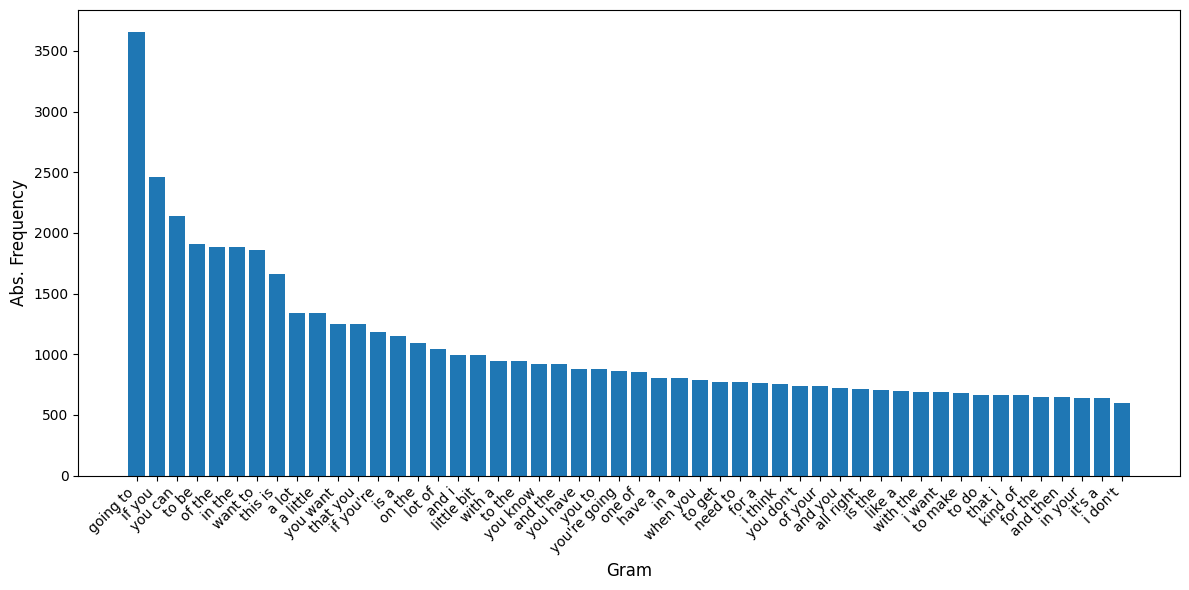

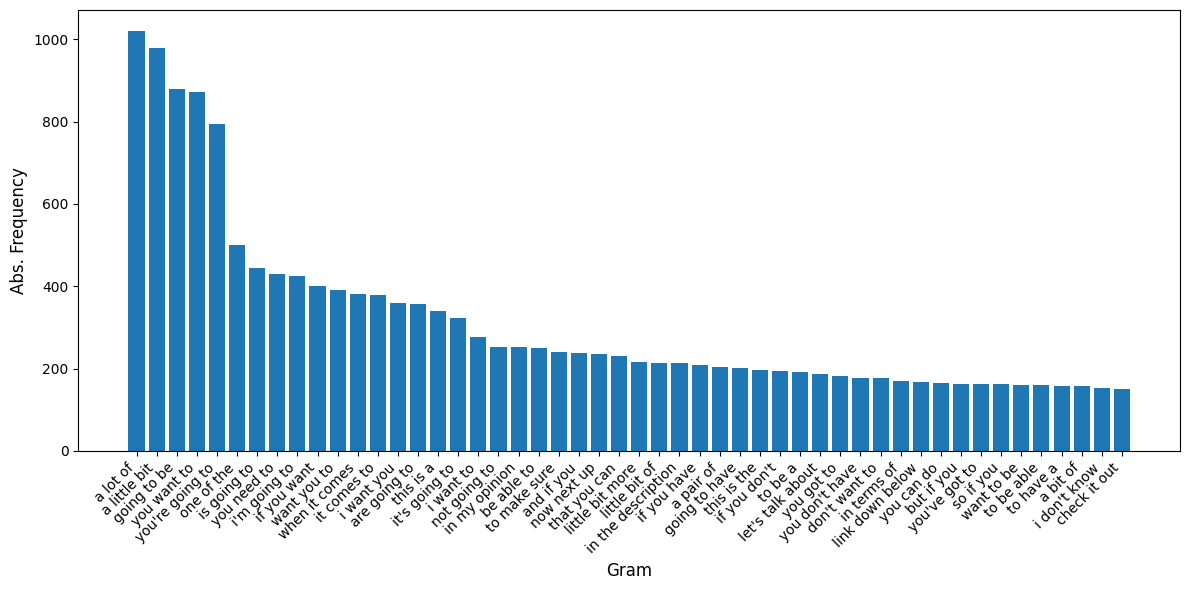

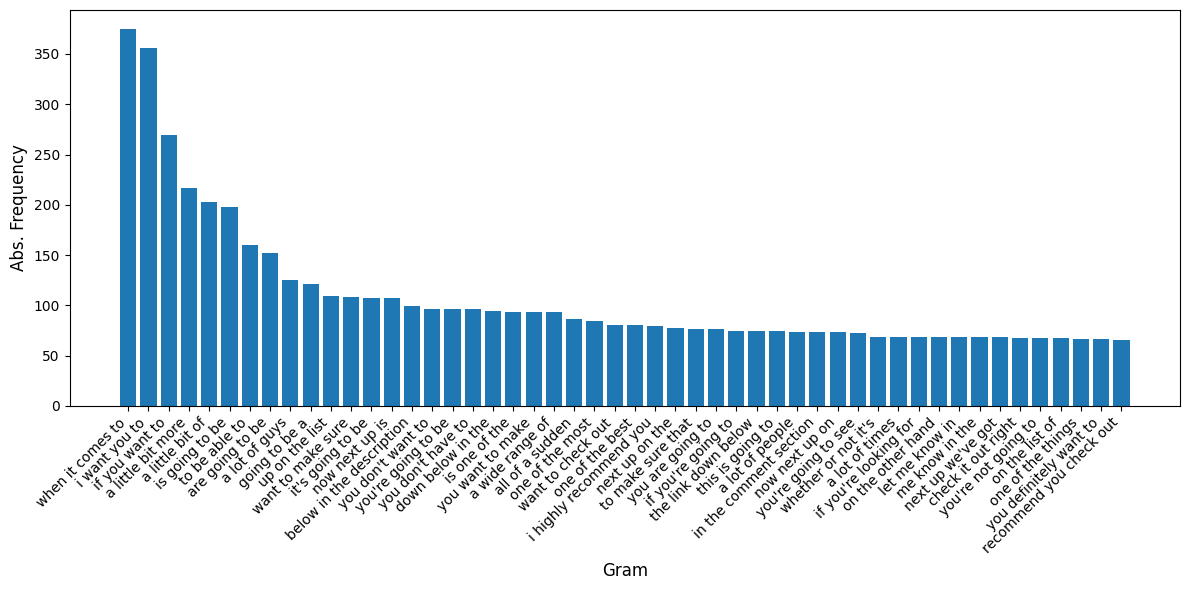

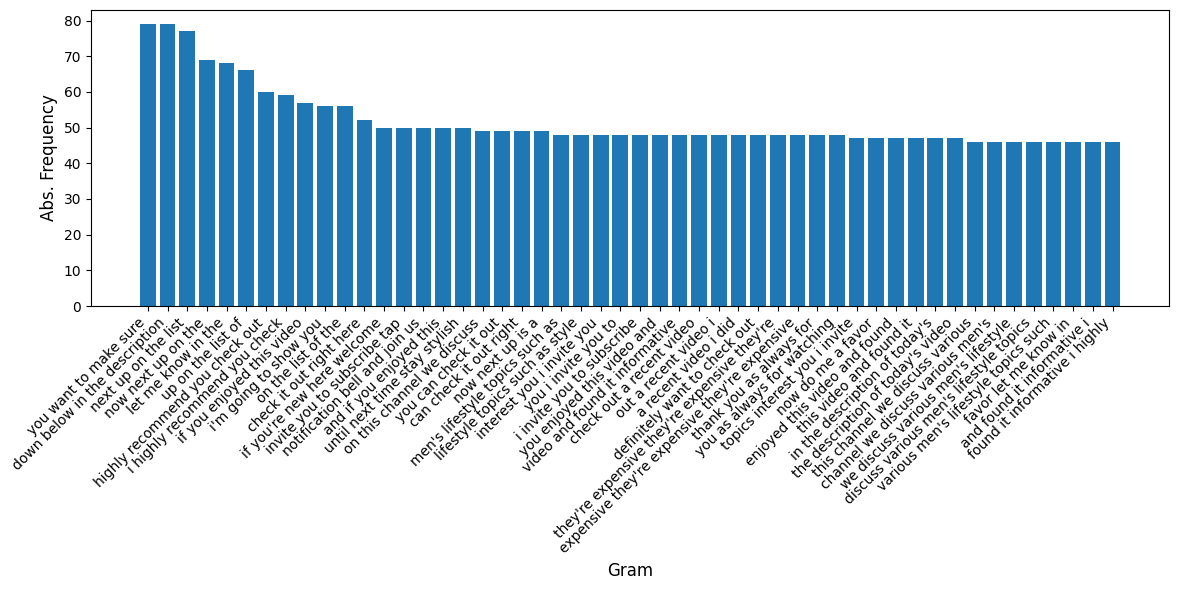

In [74]:
# Let's do it for all the grams (2,3,4,5)

visualize_results(ls_bigrams_sw_most, "Gram", "Abs. Frequency")
visualize_results(ls_trigrams_sw_most, "Gram", "Abs. Frequency")
visualize_results(ls_tetragrams_sw_most, "Gram", "Abs. Frequency")
visualize_results(ls_pentagrams_sw_most, "Gram", "Abs. Frequency")

## The Most Frequent Grams for the YT-Corpus

In [75]:
# Get "full" tokens (with the stop-words)

tokenized_yt_corpus_sw = tokenize_corpus(yt_annotated_docs, remove_stopwords=False)

In [168]:
print(len(tokenized_yt_corpus_sw))

842641


In [76]:
# Let's get all the grams (2,3,4,5) and their frequencies

yt_bigrams_sw = list(ngrams(tokenized_yt_corpus_sw, 2))
yt_trigrams_sw = list(ngrams(tokenized_yt_corpus_sw, 3))
yt_tetragrams_sw = list(ngrams(tokenized_yt_corpus_sw, 4))
yt_pentagrams_sw = list(ngrams(tokenized_yt_corpus_sw, 5))

yt_bigrams_sw_freq = Counter(yt_bigrams_sw)
yt_trigrams_sw_freq = Counter(yt_trigrams_sw)
yt_tetragrams_sw_freq = Counter(yt_tetragrams_sw)
yt_pentagrams_sw_freq = Counter(yt_pentagrams_sw)

In [77]:
# Let's check if these look legit

print(yt_bigrams_sw_freq.most_common(100))
print(yt_trigrams_sw_freq.most_common(100))
print(yt_tetragrams_sw_freq.most_common(100))
print(yt_pentagrams_sw_freq.most_common(100))

[(('of', 'the'), 2656), (('in', 'the'), 2565), (('going', 'to'), 2403), (('if', 'you'), 2111), (('to', 'be'), 2110), (('this', 'is'), 2098), (('and', 'i'), 1976), (('you', 'can'), 1852), (('want', 'to'), 1664), (('a', 'lot'), 1638), (('you', 'know'), 1622), (('that', 'i'), 1474), (('i', 'think'), 1407), (('to', 'the'), 1369), (('that', 'you'), 1333), (('on', 'the'), 1305), (('kind', 'of'), 1285), (('lot', 'of'), 1206), (('and', 'then'), 1175), (('to', 'do'), 1166), (('i', 'was'), 1107), (('a', 'little'), 1088), (('you', 'have'), 1076), (('i', "don't"), 1061), (('is', 'a'), 1055), (('and', 'the'), 1021), (('have', 'to'), 980), (('is', 'the'), 961), (('you', 'want'), 953), (('to', 'get'), 942), (('have', 'a'), 934), (('and', 'you'), 889), (('in', 'a'), 877), (('for', 'the'), 847), (('one', 'of'), 831), (('i', 'have'), 823), (('with', 'the'), 821), (('so', 'i'), 800), (('it', 'was'), 751), (('i', 'can'), 743), (('all', 'the'), 725), (('at', 'the'), 703), (('little', 'bit'), 700), (('but',

In [78]:
# Let's put together one pandas-friendly list of all the grams (for the YouTube corpus)

# Write the top-200 into the respective variables
bi_interim_yt = yt_bigrams_sw_freq.most_common(200)
tri_interim_yt = yt_trigrams_sw_freq.most_common(200)
tetra_interim_yt = yt_tetragrams_sw_freq.most_common(200)
penta_interim_yt = yt_pentagrams_sw_freq.most_common(200)

# Flatten the tuples into list items
yt_bigrams_sw_most = flatten_tupled_freqs(bi_interim_yt)
yt_trigrams_sw_most = flatten_tupled_freqs(tri_interim_yt)
yt_tetragrams_sw_most = flatten_tupled_freqs(tetra_interim_yt)
yt_pentagrams_sw_most = flatten_tupled_freqs(penta_interim_yt)

# Put them in a pandas-friendly list
interim_all_yt_grams = []
w = 0
while w < 200:
    interim_all_yt_grams.extend(yt_bigrams_sw_most[w] + yt_trigrams_sw_most[w] + yt_tetragrams_sw_most[w] + yt_pentagrams_sw_most[w])
    w += 1

yt_all_grams = []
i = 0
s = 0
e = 8
while i < 200:
    yt_all_grams.append([])
    for item in interim_all_yt_grams[s:e]:
        yt_all_grams[i].extend([item])
    i += 1
    s += 8
    e += 8

In [79]:
yt_all_grams_df = pd.DataFrame(yt_all_grams, columns = ["Bi-Grams", "Bi-Values", "Tri-Grams", "Tri-Values", "Tetra_Grams", "Tetra-Values", "Penta_Grams", "Penta-Valeus"])
yt_all_grams_df.iloc[0:50]

Bi-Grams  Bi-Values           Tri-Grams  Tri-Values  \
0       of the       2656            a lot of        1186   
1       in the       2565        a little bit         688   
2     going to       2403         you want to         585   
3       if you       2111         going to be         579   
4        to be       2110          one of the         460   
5      this is       2098        i'm going to         454   
6        and i       1976           i want to         434   
7      you can       1852         if you want         366   
8      want to       1664         you have to         337   
9        a lot       1638         this is the         319   
10    you know       1622        i don't know         309   
11      that i       1474           this is a         307   
12     i think       1407        that you can         267   
13      to the       1369         is going to         251   
14    that you       1333         and i think         249   
15      on the       1305         i feel like         240   
16     kind of       1285          be able to         222   
17      lot of       1206     you're going to         220   
18    and then       1175         you need to         212   
19       to do       1166         some of the         209   
20       i was       1107         and this is         209   
21    a little       1088          and if you         205   
22    you have       1076             to be a         205   
23     i don't       1061        not going to         198   
24        is a       1055     little bit more         196   
25     and the       1021          a bunch of         188   
26     have to        980         i wanted to         185   
27      is the        961           so if you         181   
28    you want        953      we're going to         180   
29      to get        942       when it comes         175   
30      have a        934       don't want to         173   
31     and you        889         it comes to         170   
32        in a        877          you know i         165   
33     for the        847     the things that         165   
34      one of        831          you have a         164   
35      i have        823        if you don't         163   
36    with the        821            i have a         160   
37        so i        800        all the time         157   
38      it was        751          want to be         156   
39       i can        743         you can see         153   
40     all the        725        i think it's         152   
41      at the        703       lot of people         149   
42  little bit        700           i need to         148   
43       but i        691       little bit of         147   
44     need to        686         you can get         146   
45       for a        673        are going to         142   
46   if you're        670          the end of         141   
47       it is        668          so this is         141   
48      like a        663  in the description         140   
49   you don't        658        in your life         139   

                   Tetra_Grams  Tetra-Values  \
0               if you want to           218   
1            a little bit more           196   
2             when it comes to           167   
3              a lot of people           149   
4              a little bit of           135   
5               is going to be           121   
6                to be able to           113   
7              one of the most           110   
8              i don't want to            91   
9                 a lot of the            90   
10             i'm going to be            84   
11              the end of the            81   
12          which brings us to            80   
13   for sponsoring this video            78   
14            at the same time            77   
15               at the end of            76   
16               i want you to            74   
17             i don't know if

## Most Frequent Grams for the Combined Corpus

In [81]:
# Let's concatenate a combined corpus (ls + yt)

combined_tokenized_corpus_sw = tokenized_ls_corpus_sw + tokenized_yt_corpus_sw

In [82]:
# And do the usual extraction of grams and their frequencies

comb_bigrams_sw = list(ngrams(combined_tokenized_corpus_sw, 2))
comb_trigrams_sw = list(ngrams(combined_tokenized_corpus_sw, 3))
comb_tetragrams_sw = list(ngrams(combined_tokenized_corpus_sw, 4))
comb_pentagrams_sw = list(ngrams(combined_tokenized_corpus_sw, 5))

comb_bigrams_sw_freq = Counter(comb_bigrams_sw)
comb_trigrams_sw_freq = Counter(comb_trigrams_sw)
comb_tetragrams_sw_freq = Counter(comb_tetragrams_sw)
comb_pentagrams_sw_freq = Counter(comb_pentagrams_sw)

In [83]:
# Let's put together one pandas-friendly list of all the grams (for the combined corpus)

# Write the top-200 into the respective variables
bi_interim_comb = comb_bigrams_sw_freq.most_common(200)
tri_interim_comb = comb_trigrams_sw_freq.most_common(200)
tetra_interim_comb = comb_tetragrams_sw_freq.most_common(200)
penta_interim_comb = comb_pentagrams_sw_freq.most_common(200)

# Flatten the tuples into list items
comb_bigrams_sw_most = flatten_tupled_freqs(bi_interim_comb)
comb_trigrams_sw_most = flatten_tupled_freqs(tri_interim_comb)
comb_tetragrams_sw_most = flatten_tupled_freqs(tetra_interim_comb)
comb_pentagrams_sw_most = flatten_tupled_freqs(penta_interim_comb)

# Put them in a pandas-friendly list
interim_all_comb_grams = []
w = 0
while w < 200:
    interim_all_comb_grams.extend(comb_bigrams_sw_most[w] + comb_trigrams_sw_most[w] + comb_tetragrams_sw_most[w] + comb_pentagrams_sw_most[w])
    w += 1

comb_all_grams = []
i = 0
s = 0
e = 8
while i < 200:
    comb_all_grams.append([])
    for item in interim_all_comb_grams[s:e]:
        comb_all_grams[i].extend([item])
    i += 1
    s += 8
    e += 8

In [84]:
comb_all_grams_df = pd.DataFrame(comb_all_grams, columns = ["Bi-Grams", "Bi-Values", "Tri-Grams", "Tri-Values", "Tetra_Grams", "Tetra-Values", "Penta_Grams", "Penta-Valeus"])
comb_all_grams_df.iloc[0:50]

Bi-Grams  Bi-Values           Tri-Grams  Tri-Values  \
0     going to       6057            a lot of        2206   
1       if you       4571        a little bit        1667   
2       of the       4541         going to be        1457   
3       in the       4450         you want to        1457   
4        to be       4015     you're going to        1013   
5      you can       3995          one of the         961   
6      this is       3756        i'm going to         878   
7      want to       3522         if you want         766   
8        a lot       2978           i want to         710   
9        and i       2969         is going to         695   
10    that you       2578           this is a         646   
11    you know       2541         you need to         643   
12    a little       2426       when it comes         556   
13      on the       2396         it comes to         548   
14      to the       2317         this is the         516   
15      lot of       2247        are going to         499   
16        is a       2204        that you can         497   
17    you want       2203         you have to         483   
18     i think       2160         want you to         480   
19      that i       2139          be able to         471   
20    you have       1954        i don't know         462   
21     kind of       1946       it's going to         451   
22     and the       1938        not going to         451   
23   if you're       1853          and if you         443   
24       to do       1833          i want you         435   
25    and then       1819     little bit more         413   
26      have a       1742             to be a         397   
27      to get       1716       little bit of         361   
28  little bit       1692         and this is         359   
29      one of       1686        if you don't         358   
30        in a       1682         some of the         355   
31      is the       1664  in the description         354   
32     i don't       1661         and i think         351   
33     and you       1609       don't want to         350   
34     have to       1529           so if you         343   
35      with a       1512      we're going to         328   
36    with the       1510        to make sure         326   
37     for the       1492         if you have         321   
38       i was       1481          a bunch of         319   
39     need to       1454         i feel like         319   
40       for a       1433          want to be         317   
41    when you       1418      you don't have         312   
42   you don't       1398          you have a         310   
43      like a       1361       in my opinion         299   
44      you to       1334          you can do         294   
45      i want       1319        all the time         289   
46     all the       1275     the things that         273   
47     to make       1265          to be able         273   
48      at the       1232         you can see         272   
49     in your       1210       going to have         271   

                 Tetra_Grams  Tetra-Values                     Penta_Grams  \
0           when it comes to           542           you want to make sure   
1             if you want to           487              let me know in the   
2              i want you to           430   down below in the description   
3          a little bit more           413               at the end of the   
4            a little bit of           338       if you enjoyed this video   
5             is going to be           319             next up on the list   
6              to be able to           273           thank you so much for   
7            a lot of people           222              now next up on the   
8            one of the most           194              the end of the day   
9            are going to be           190             going to be able to   
10             going to be a        

## Collocations in the LS-Corpus

In [98]:
# We're going to use the tokens stored in this variable: tokenized_ls_corpus_sw (tokens with the stop-words)
# Let's do bigrams and trigrams first

# (Uncomment if necessary:)
# from nltk.collocations import BigramCollocationFinder
# from nltk.collocations import BigramAssocMeasures
# from nltk.collocations import TrigramCollocationFinder
# from nltk.collocations import TrigramAssocMeasures

ls_bigram_finder = BigramCollocationFinder.from_words(tokenized_ls_corpus_sw)
ls_trigram_finder = TrigramCollocationFinder.from_words(tokenized_ls_corpus_sw)

# Filter for the minimal absolute frequency
ls_bigram_finder.apply_freq_filter(10)
ls_trigram_finder.apply_freq_filter(10)

# Apply the different methods to bigrams
ls_top_bigrams_lr = ls_bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 200)
ls_top_bigrams_pmi = ls_bigram_finder.nbest(BigramAssocMeasures.pmi, 200)
ls_top_bigrams_student_t = ls_bigram_finder.nbest(BigramAssocMeasures.student_t, 200)

# Apply the different methods to trigrams
ls_top_trigrams_lr = ls_trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 200)
ls_top_trigrams_student_t = ls_trigram_finder.nbest(TrigramAssocMeasures.student_t, 200)
ls_top_trigrams_pmi = ls_trigram_finder.nbest(TrigramAssocMeasures.pmi, 200)

In [99]:
#Let's have a quick look at what it looks like

print(ls_top_bigrams_lr)
print(ls_top_bigrams_student_t)
print(ls_top_bigrams_pmi)

print(ls_top_trigrams_lr)
print(ls_top_trigrams_student_t)
print(ls_top_trigrams_pmi)

[('going', 'to'), ('little', 'bit'), ('if', 'you'), ('you', 'can'), ('want', 'to'), ('a', 'lot'), ('a', 'little'), ('to', 'be'), ('lot', 'of'), ('this', 'is'), ('if', "you're"), ("you've", 'got'), ('kind', 'of'), ('you', 'want'), ('make', 'sure'), ('all', 'right'), ('in', 'the'), ("you're", 'going'), ('talk', 'about'), ('i', 'think'), ('down', 'below'), ('next', 'up'), ('need', 'to'), ('you', 'know'), ('talking', 'about'), ('one', 'of'), ('check', 'out'), ('it', 'comes'), ('the', 'best'), ('and', 'then'), ('my', 'opinion'), ('right', 'here'), ('of', 'the'), ('a', 'few'), ('i', 'want'), ('on', 'the'), ("today's", 'video'), ('you', 'need'), ('pair', 'of'), ('out', 'there'), ('when', 'you'), ('this', 'video'), ('of', 'course'), ("you're", 'gonna'), ('to', 'make'), ("i'm", 'going'), ('let', 'me'), ('the', 'same'), ('i', "don't"), ('you', "don't"), ('look', 'at'), ('able', 'to'), ('to', 'get'), ('be', 'able'), ('sort', 'of'), ("let's", 'talk'), ("we've", 'got'), ('which', 'is'), ('you', 'ha

In [100]:
# Let's defne a function to make the results more pandas-friendly

def display_grams(grams_lr, grams_t, grams_pmi):
    lr_list = flatten_tupled_freqs(grams_lr, freq_value=False)
    student_t_list = flatten_tupled_freqs(grams_t, freq_value=False)
    pmi_list = flatten_tupled_freqs(grams_pmi, freq_value=False)

    all_collocations = []
    w = 0
    while w < 200:
        all_collocations.append([])
        all_collocations[w].extend([lr_list[w], student_t_list[w], pmi_list[w]])
        w += 1
    return all_collocations

In [101]:
# Let's have a look at the best collocations (based on the three methods) for the Lifestyle Corpus

ls_all_bi_collocations_df = pd.DataFrame(display_grams(ls_top_bigrams_lr, ls_top_bigrams_student_t, ls_top_bigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
ls_all_bi_collocations_df.iloc[:50]

Likelyhood Ratio     Student T                    PMI
0          going to      going to        banana republic
1        little bit        if you           aris coastal
2            if you       you can         carl friedrich
3           you can       want to         midlife crisis
4           want to         to be       sapphire crystal
5             a lot       this is           boxer briefs
6          a little        in the            boom. boom.
7             to be         a lot             pinot noir
8            lot of      a little           bachelor pad
9           this is     if you're           marine corps
10        if you're        of the              max aroma
11       you've got      you want            french crop
12          kind of        lot of          united states
13         you want    little bit            rabbit hole
14        make sure  you're going           donald trump
15        all right        on the           derma roller
16           in the      you know        degrees celsius
17     you're going        one of     degrees fahrenheit
18       talk about       i think             flip flops
19          i think       need to           gucci guilty
20       down below     all right        stainless steel
21          next up          is a    southern california
22          need to        with a               tom ford
23         you know      you have             tom ford's
24    talking about      when you   betterhelp.com slash
25           one of       kind of            card holder
26        check out      that you           human beings
27         it comes        to get          ingrown hairs
28         the best     you don't      notification bell
29         and then        i want            swim trunks
30       my opinion        have a          vast majority
31       right here      and then            sperm count
32           of the       to make            credit card
33            a few      you need         salicylic acid
34           i want       i don't           bank account
35           on the    you've got  scientifically proven
36    today's video      the best        hyaluronic acid
37         you need         to do                 war ii
38          pair of       next up          subscribe tap
39        out there    talk about                alpha m
40         when you     make sure        limited edition
41       this video       in your               sea salt
42        of course         for a             blow dryer
43     you're gonna         and i        double breasted
44          to make       of your              brain rot
45        i'm going     i'm going           welcome jeff
46           let me      it comes      gravitate towards
47         the same        like a               slip ons
48          i don't      which is       shared interests
49        you don't       a great               lug sole

In [102]:
# Let's have a look at the collocations based on tri-grams now
ls_all_tri_collocations_df = pd.DataFrame(display_grams(ls_top_trigrams_lr, ls_top_trigrams_student_t, ls_top_trigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
ls_all_tri_collocations_df.iloc[:50]

Likelyhood Ratio           Student T                       PMI
0         going to be            a lot of         boom. boom. boom.
1     you're going to        a little bit              world war ii
2        you going to         going to be     discuss various men's
3        i'm going to         you want to   various men's lifestyle
4       going to make     you're going to    men's lifestyle topics
5        going to get          one of the     lifestyle topics such
6         going to do         is going to           dead skin cells
7        are going to         you need to     health wealth purpose
8         going to go        i'm going to         here welcome jeff
9         is going to         if you want             new york city
10      it's going to         want you to       quarter zip sweater
11      going to wear       when it comes     comment section thank
12     we're going to         it comes to        we discuss various
13       not going to          i want you            v neck sweater
14       going to see        are going to     those topics interest
15      going to have           this is a        channel we discuss
16      going to keep       it's going to          common color tan
17      going to look           i want to         linked down below
18      going to show       in my opinion           the french crop
19     going to start        not going to        shaving your pubes
20      going to give          be able to     channel by sponsoring
21      going to find        to make sure      my returning friends
22    that's going to         now next up  sponsoring today's video
23      going to talk          and if you          vast majority of
24      going to take        that you can              favor let me
25   they're going to     little bit more         the united states
26      going to help       little bit of         welcome jeff your
27       going to say  in the description       suede bomber jacket
28      going to work         if you have     there's nothing wrong
29       going to use           a pair of             by step guide
30       going to try       going to have          long sleeve polo
31       going to put        if you don't          new here welcome
32         going to a         this is the            a derma roller
33     going to build    let's talk about     notification bell and
34       going to add             to be a            topics such as
35    what's going to          you got to        watching live well
36       going to the      you don't have           it'll be linked
37     going to bring       don't want to   consider subscribing if
38      also going to         in terms of          size extra small
39     going to share     link down below        oxford button down
40      going to grab          you can do                 oh my god
41     going to break       you've got to           link down below
42  probably going to          but if you          first factor box
43      going to want          want to be         the vast majority
44      going to save           so if you           no further than
45      just going to          to be able    returning friends like
46     never going to            a bit of      tap the notification
47      going to come        i don't know     the notification bell
48      going to draw        check it out          to subscribe tap
49    going to happen           to have a          grams of protein

## Collocations in the YT-Corpus

In [103]:
yt_bigram_finder = BigramCollocationFinder.from_words(tokenized_yt_corpus_sw)
yt_trigram_finder = TrigramCollocationFinder.from_words(tokenized_yt_corpus_sw)

# Filter for the minimal absolute frequency
yt_bigram_finder.apply_freq_filter(8)
yt_trigram_finder.apply_freq_filter(8)

# Apply the different methods to bigrams
yt_top_bigrams_lr = yt_bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 200)
yt_top_bigrams_pmi = yt_bigram_finder.nbest(BigramAssocMeasures.pmi, 200)
yt_top_bigrams_student_t = yt_bigram_finder.nbest(BigramAssocMeasures.student_t, 200)

# Apply the different methods to trigrams
yt_top_trigrams_lr = yt_trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 200)
yt_top_trigrams_student_t = yt_trigram_finder.nbest(TrigramAssocMeasures.student_t, 200)
yt_top_trigrams_pmi = yt_trigram_finder.nbest(TrigramAssocMeasures.pmi, 200)

In [104]:
yt_all_bi_collocations_df = pd.DataFrame(display_grams(yt_top_bigrams_lr, yt_top_bigrams_student_t, yt_top_bigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
yt_all_bi_collocations_df.iloc[:50]

Likelyhood Ratio   Student T                     PMI
0          going to    going to       domestic violence
1             a lot      if you                 dot com
2           kind of      in the       authorized dealer
3            if you       to be               et cetera
4           want to     this is             pet hamster
5           you can     you can    sexually disciplined
6             to be       a lot                f*** ing
7        little bit      of the               jake paul
8           this is     want to        alpha industries
9          you know    you know           connor beaton
10           lot of     i think          beaton signing
11          i think     kind of          emergency fund
12         a little      lot of    intermittent fasting
13           in the    and then            coupon codes
14         and then    a little                   ha ha
15          i don't       and i              steam deck
16           of the     i don't             gaines club
17         you want       i was           united states
18        if you're       to do              galaxy s24
19            i was      on the           hamster smell
20          able to    you want                rog ally
21            to do    you have              storm flap
22         the same      that i             spice latte
23          need to      to get        basketball court
24     every single  little bit        transparent labs
25        right now      one of                chat gpt
26       this video      have a         stainless steel
27         which is     have to         merry christmas
28          look at    that you               blah blah
29        feel like      it was             notebook lm
30        trying to   if you're           pumpkin spice
31         you have     need to          steering wheel
32          as well      i have                  war ii
33           to get        is a                 mr. lou
34        i'm going       i can               west west
35           on the     i would   visit squarespace.com
36           it was    which is             rabbit hole
37       talk about    the same              fly deuces
38           one of   you don't        sapphire crystal
39          sort of  this video            cyber monday
40          i would      i want              swiss army
41        your life    when you       stitch considered
42       don't know    the most  collective unconscious
43        i've been       in my                 sd card
44         the most     able to           packing cubes
45         the best      at the            heel counter
46           i mean      when i               bell icon
47            a few     to make             trench coat
48            and i     all the          patreon member
49           have a        so i            packing cube

In [105]:
yt_all_tri_collocations_df = pd.DataFrame(display_grams(yt_top_trigrams_lr, yt_top_trigrams_student_t, yt_top_trigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
yt_all_tri_collocations_df.iloc[:50]

Likelyhood Ratio           Student T                             PMI
0       going to be            a lot of               pet hamster smell
1          a lot of        a little bit           connor beaton signing
2        if you can         you want to                        ha ha ha
3       if you know         going to be             pumpkin spice latte
4        want to be          one of the                  blah blah blah
5       going to do        i'm going to       cleaning office buildings
6      i'm going to           i want to  fulfillment dedicated customer
7      going to get         if you want    digestible productivity tips
8         a kind of         you have to                 stay fly deuces
9     going to make        i don't know                 tudor black bay
10     you going to         this is the                credit card debt
11       i going to           this is a                  flex pro meals
12     a little bit        that you can      fast fulfillment dedicated
13      going to go         is going to              beaton signing off
14  you're going to         and i think             vibrations per hour
15   we're going to         i feel like              week connor beaton
16     not going to          be able to                    world war ii
17     going to see     you're going to           milliamp hour battery
18    going to keep         you need to        minimalism frugal living
19      if you want         some of the      dedicated customer support
20    going to take         and this is          productivity tips sent
21      kind of the          and if you                      usb type c
22     going to say             to be a           made character doodle
23    going to give        not going to              frugal living tech
24  going to create     little bit more         every stitch considered
25      is going to          a bunch of             worst case scenario
26    going to find         i wanted to          under consumption core
27     are going to      we're going to               an emergency fund
28    it's going to           so if you                     m4 mac mini
29    going to help       when it comes                your pet hamster
30     going to use       don't want to           comment section below
31    going to work         it comes to           settling start living
32     going to buy        if you don't       possibilities are endless
33    going to talk     the things that                  nine nine nine
34    going to save          you know i    disorganized attached person
35     going to try          you have a           custom made character
36      the kind of        all the time              most recent upload
37    just going to          want to be            smart home platforms
38       have a lot            i have a             stop settling start
39   going to start         you can see               drive drive drive
40  going to change        i think it's                   new york city
41    going to have       lot of people                inner child work
42     was going to       little bit of                   final cut pro
43    going to show           i need to                     one rep max
44    going to come         you can get          rock possibilities are
45  what's going to        are going to                  pull pull pull
46    going to wear          the end of             smart home platform
47     going to add  in the description                  wait wait wait
48   going to bring        in your life                  use code jesse
49   going to share          so this is            ladies and gentlemen

## Collocations in the Combined Corpus

In [108]:
comb_bigram_finder = BigramCollocationFinder.from_words(combined_tokenized_corpus_sw)
comb_trigram_finder = TrigramCollocationFinder.from_words(combined_tokenized_corpus_sw)

# Filter for the minimal absolute frequency
comb_bigram_finder.apply_freq_filter(10)
comb_trigram_finder.apply_freq_filter(10)

# Apply the different methods to bigrams
comb_top_bigrams_lr = comb_bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 200)
comb_top_bigrams_pmi = comb_bigram_finder.nbest(BigramAssocMeasures.pmi, 200)
comb_top_bigrams_student_t = comb_bigram_finder.nbest(BigramAssocMeasures.student_t, 200)

# Apply the different methods to trigrams
comb_top_trigrams_lr = comb_trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 200)
comb_top_trigrams_student_t = comb_trigram_finder.nbest(TrigramAssocMeasures.student_t, 200)
comb_top_trigrams_pmi = comb_trigram_finder.nbest(TrigramAssocMeasures.pmi, 200)

In [109]:
comb_all_bi_collocations_df = pd.DataFrame(display_grams(comb_top_bigrams_lr, comb_top_bigrams_student_t, comb_top_bigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
comb_all_bi_collocations_df.iloc[:50]

Likelyhood Ratio     Student T                   PMI
0          going to      going to             jiu jitsu
1             a lot        if you          aris coastal
2            if you       you can          boxer briefs
3        little bit         to be     authorized dealer
4           you can       this is             et cetera
5           want to        in the     domestic violence
6             to be       want to         spoiler alert
7           kind of         a lot       banana republic
8          a little        of the           pet hamster
9           this is      a little            pinot noir
10           lot of      you know           boom. boom.
11          i think        lot of               dot com
12         you know       i think          marine corps
13           in the      you want  progressive overload
14        if you're       kind of              f*** ing
15         you want     if you're            ivy league
16         and then        on the         connor beaton
17       talk about    little bit  intermittent fasting
18          need to      and then   diminishing returns
19           of the      you have         firm believer
20        make sure       i don't        emergency fund
21          i don't        one of        beaton signing
22          able to         to do              rog ally
23        all right         and i        midlife crisis
24           one of        to get          donald trump
25     you're going       need to             jake paul
26         the same         i was          derma roller
27    talking about      that you           notebook lm
28       this video        have a            tom ford's
29            i was          is a           french crop
30       you've got      when you                 ha ha
31           on the     you don't         ingrown hairs
32       down below        that i        carl friedrich
33         the best        i want   southern california
34            to do       to make            storm flap
35           to get  you're going               mr. lou
36        i'm going        it was             blah blah
37          look at       have to          minimum wage
38         which is        with a              chat gpt
39          sort of     all right          bachelor pad
40            a few      which is           swim trunks
41         you have      the best         united states
42     every single      the same  sexually disciplined
43          i would    this video      moisture wicking
44        trying to       i would      sapphire crystal
45           i want        at the    degrees fahrenheit
46          to make     i'm going        salicylic acid
47         when you         in my          cyber monday
48       right here       in your       hyaluronic acid
49        you don't       all the              tom ford

In [110]:
comb_all_tri_collocations_df = pd.DataFrame(display_grams(comb_top_trigrams_lr, comb_top_trigrams_student_t, comb_top_trigrams_pmi), columns=["Likelyhood Ratio", "Student T", "PMI"])
comb_all_tri_collocations_df.iloc[:50]

Likelyhood Ratio           Student T                             PMI
0        going to be            a lot of               boom. boom. boom.
1    you're going to        a little bit           connor beaton signing
2       i'm going to         going to be                        ha ha ha
3        going to do         you want to             pumpkin spice latte
4       going to get     you're going to                  blah blah blah
5       you going to          one of the               pet hamster smell
6      going to make        i'm going to  fulfillment dedicated customer
7           a lot of         if you want    digestible productivity tips
8         if you can           i want to           discuss various men's
9        going to go         is going to                credit card debt
10        i going to         you need to           milliamp hour battery
11    we're going to           this is a      fast fulfillment dedicated
12      are going to       when it comes        minimalism frugal living
13       is going to         it comes to         various men's lifestyle
14      not going to         this is the             vibrations per hour
15      going to see        are going to              beaton signing off
16     it's going to        that you can                  flex pro meals
17     going to keep         want you to                 tudor black bay
18     going to give          be able to          men's lifestyle topics
19     going to take         you have to                    world war ii
20     going to wear        i don't know      dedicated customer support
21     going to find        not going to              frugal living tech
22     going to have       it's going to                     m4 mac mini
23      going to say          i want you           lifestyle topics such
24    going to start          and if you          productivity tips sent
25     going to show     little bit more           made character doodle
26     going to talk             to be a                 dead skin cells
27     going to look       little bit of                      usb type c
28     going to help        if you don't             worst case scenario
29   going to create  in the description          under consumption core
30      going to use         some of the             quarter zip sweater
31     going to work       don't want to                your pet hamster
32  they're going to         and i think              fresh never frozen
33      going to try         and this is                  v neck sweater
34   that's going to           so if you       possibilities are endless
35    going to build      we're going to           settling start living
36      going to buy        to make sure               drive drive drive
37     going to save          a bunch of           health wealth purpose
38      going to pay         i feel like               here welcome jeff
39   going to change         if you have              we discuss various
40   what's going to          want to be                   new york city
41      going to put      you don't have                inner child work
42      going to add       in my opinion           comment section thank
43     just going to          you have a           those topics interest
44    going to bring          you can do              shaving your pubes
45    going to spend        all the time             stop settling start
46     going to come          to be able           comment section below
47    going to share         you can see                     one rep max
48      going to the     the things that           custom made character
49       it going to       going to have                 a firm believer

# Collocations Based on Dependencies

In [111]:
# Before we beging, let's concatenate the two sets of Stanza-annotated docs into one

combined_annotated_docs = ls_annotated_docs + yt_annotated_docs

## Adjective + Noun

In [112]:
# Let's define a function to extract the collocations (or -- rather -- the bigrams) following the patter "adjective + noun"
# To do that, we're going to utilize the depparse function of Stanza
# To make the function a bit more universal, the "annotated" argument accepts a single Stanza doc or a list of docs as input
# The output is raw results ([0]), and top-30 items in terms of their absolute frequency

def find_adj_noun_collocs(annotated, top=30):
    interim = []
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.deprel ==  "amod" and sentence.words[h-1].upos == "NOUN":
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
    else:
        for sentence in annotated.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.deprel ==  "amod" and sentence.words[h-1].upos == "NOUN":
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
        
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

In [113]:
ls_adj_noun_collocs = find_adj_noun_collocs(ls_annotated_docs)
yt_adj_noun_collocs = find_adj_noun_collocs(yt_annotated_docs)


In [114]:
print(flatten_tupled_freqs(ls_adj_noun_collocs[1]))
print(flatten_tupled_freqs(yt_adj_noun_collocs[1]))

[['little bit', 993], ['other people', 177], ['high quality', 123], ['wide range', 104], ['most people', 100], ['most men', 97], ['older guys', 90], ['next time', 86], ['next one', 78], ['long term', 76], ['most guys', 76], ['older guy', 72], ['other hand', 70], ['great thing', 69], ['black shoes', 67], ['long time', 67], ['next thing', 66], ['social media', 66], ['same thing', 65], ['same time', 63], ['few years', 59], ['great way', 57], ['other thing', 56], ['first time', 52], ['single day', 51], ['recent video', 50], ['bottom line', 48], ['various men', 48], ['special link', 46], ['more money', 46]]
[['little bit', 702], ['other people', 245], ['most people', 225], ['long time', 104], ['social media', 99], ['same thing', 99], ['same time', 86], ['single day', 86], ['many people', 80], ['next one', 77], ['first thing', 77], ['last year', 74], ['first time', 74], ['other side', 69], ['more money', 65], ['next time', 57], ['whole lot', 53], ['next week', 52], ['different things', 50], 

In [115]:
ls_adj_noun_collocs_df = pd.DataFrame(flatten_tupled_freqs(ls_adj_noun_collocs[1]), columns=["Item", "Abs. Frequency"])
ls_adj_noun_collocs_df

Item  Abs. Frequency
0     little bit             993
1   other people             177
2   high quality             123
3     wide range             104
4    most people             100
5       most men              97
6     older guys              90
7      next time              86
8       next one              78
9      long term              76
10     most guys              76
11     older guy              72
12    other hand              70
13   great thing              69
14   black shoes              67
15     long time              67
16    next thing              66
17  social media              66
18    same thing              65
19     same time              63
20     few years              59
21     great way              57
22   other thing              56
23    first time              52
24    single day              51
25  recent video              50
26   bottom line              48
27   various men              48
28  special link              46
29    more money              46

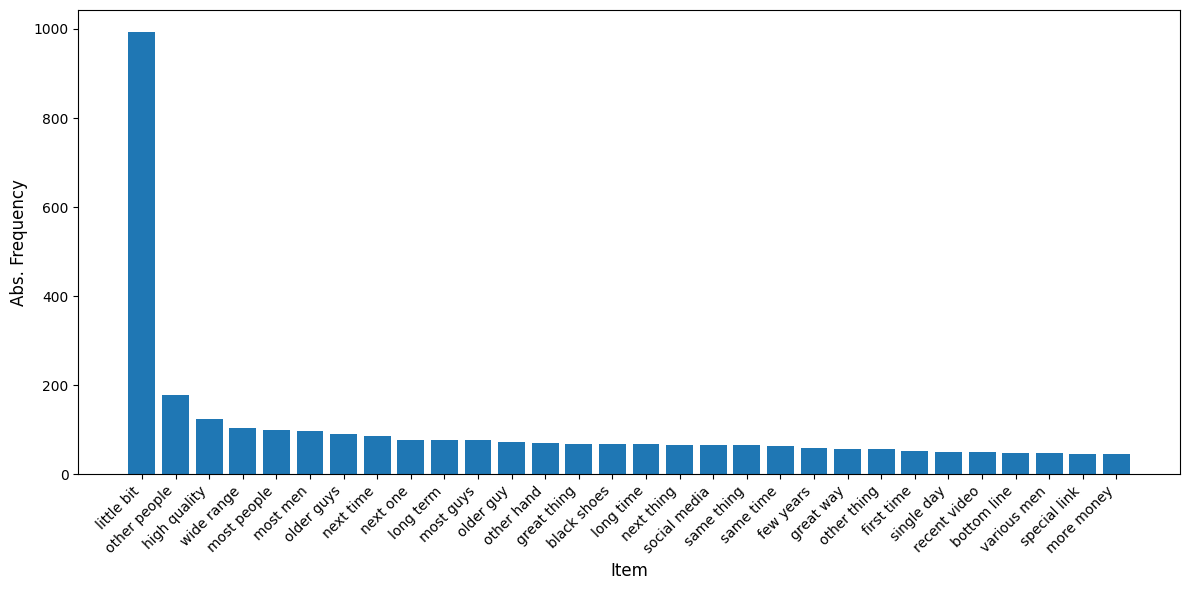

In [116]:
visualize_results(flatten_tupled_freqs(ls_adj_noun_collocs[1]), "Item", "Abs. Frequency")

In [117]:
yt_adj_noun_collocs_df = pd.DataFrame(flatten_tupled_freqs(yt_adj_noun_collocs[1]), columns=["Item", "Abs. Frequency"])
yt_adj_noun_collocs_df

Item  Abs. Frequency
0         little bit             702
1       other people             245
2        most people             225
3          long time             104
4       social media              99
5         same thing              99
6          same time              86
7         single day              86
8        many people              80
9           next one              77
10       first thing              77
11         last year              74
12        first time              74
13        other side              69
14        more money              65
15         next time              57
16         whole lot              53
17         next week              52
18  different things              50
19       whole thing              49
20      younger self              49
21         more time              46
22          best way              45
23         few years              45
24        next video              43
25          only way              41
26      other things              41
27        only thing              40
28         much time              40
29        few things              40

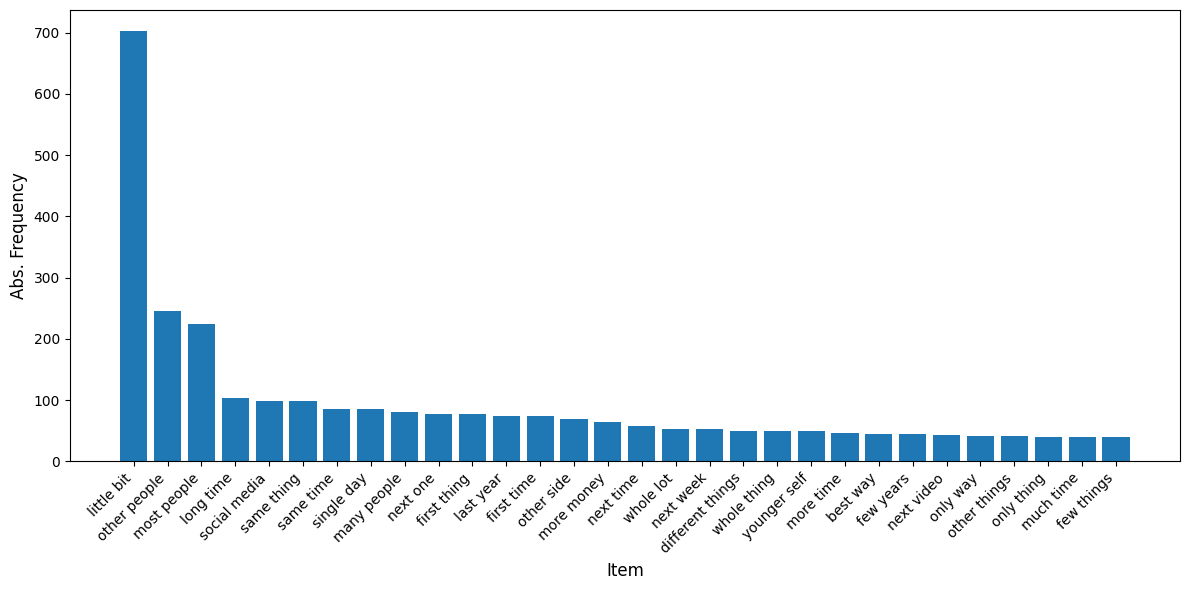

In [118]:
visualize_results(flatten_tupled_freqs(yt_adj_noun_collocs[1]), "Item", "Abs. Frequency")

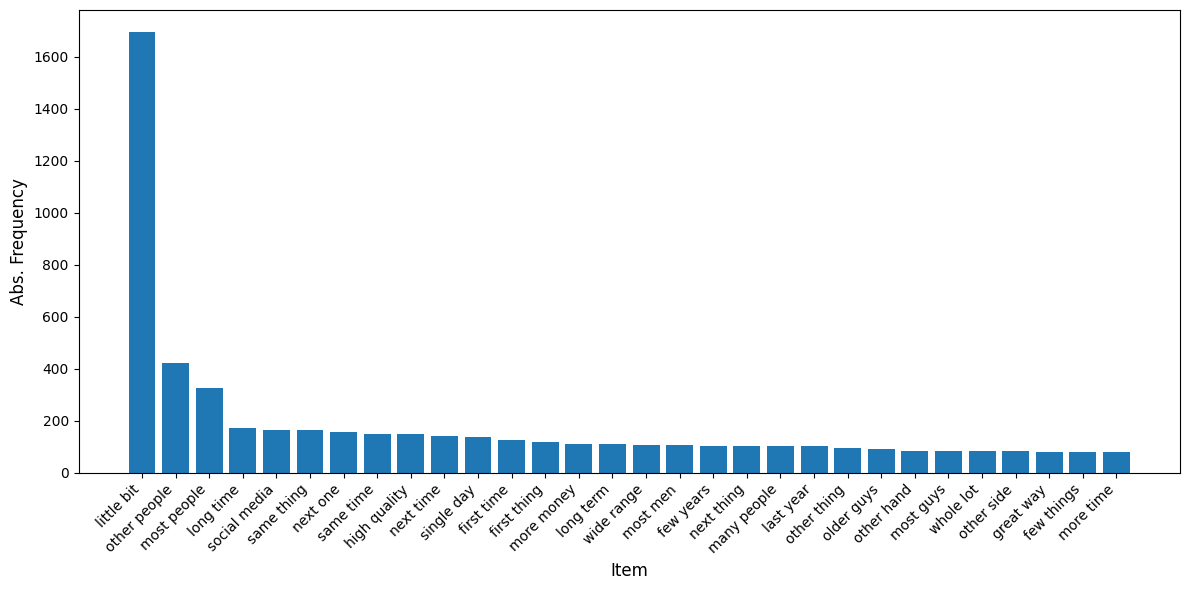

In [119]:
visualize_results(flatten_tupled_freqs(find_adj_noun_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Noun + Noun

In [120]:
# Let's define the function to extract the "noun + noun" type collocations

def find_noun_noun_collocs(annotated, top=30):
    interim = []
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    if word.upos == "NOUN" and word.deprel == "compound" and word.head == word.id + 1:
                        interim.append([word.text.lower(), sentence.words[word.head - 1].text.lower()])
    else:
        for sentence in annotated.sentences:
                for word in sentence.words:
                    if word.upos == "NOUN" and word.deprel == "compound" and word.head == word.id + 1:
                        interim.append([word.text.lower(), sentence.words[word.head - 1].text.lower()])
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

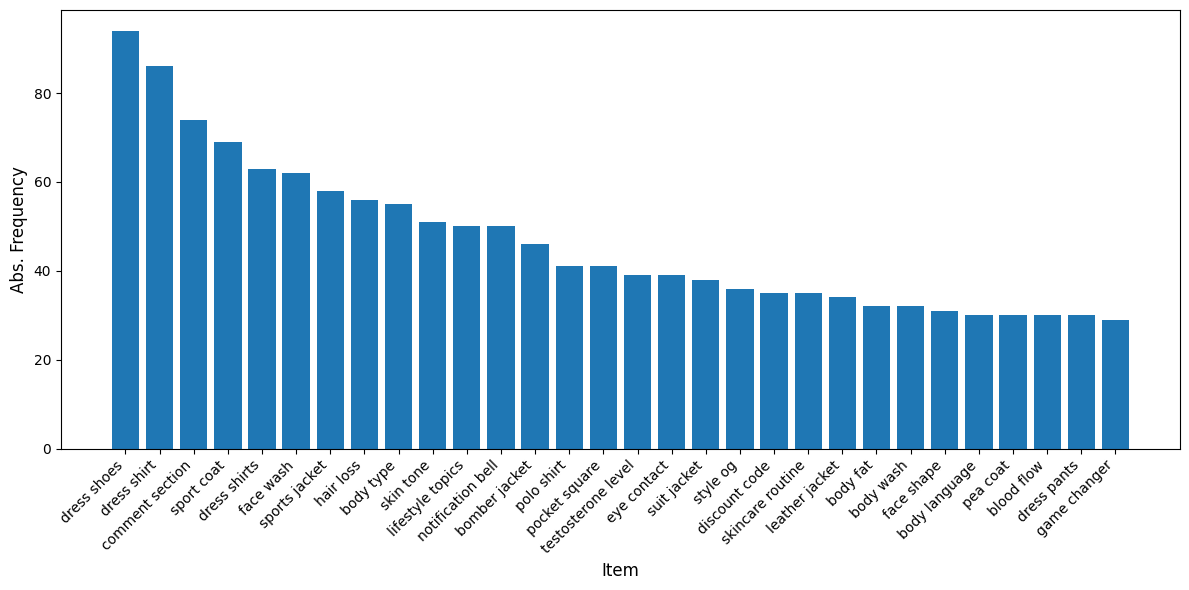

In [121]:
# Let's save time and effort and visualize the results for the Lifesty Corpus (without the interim steps)

visualize_results(flatten_tupled_freqs(find_noun_noun_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

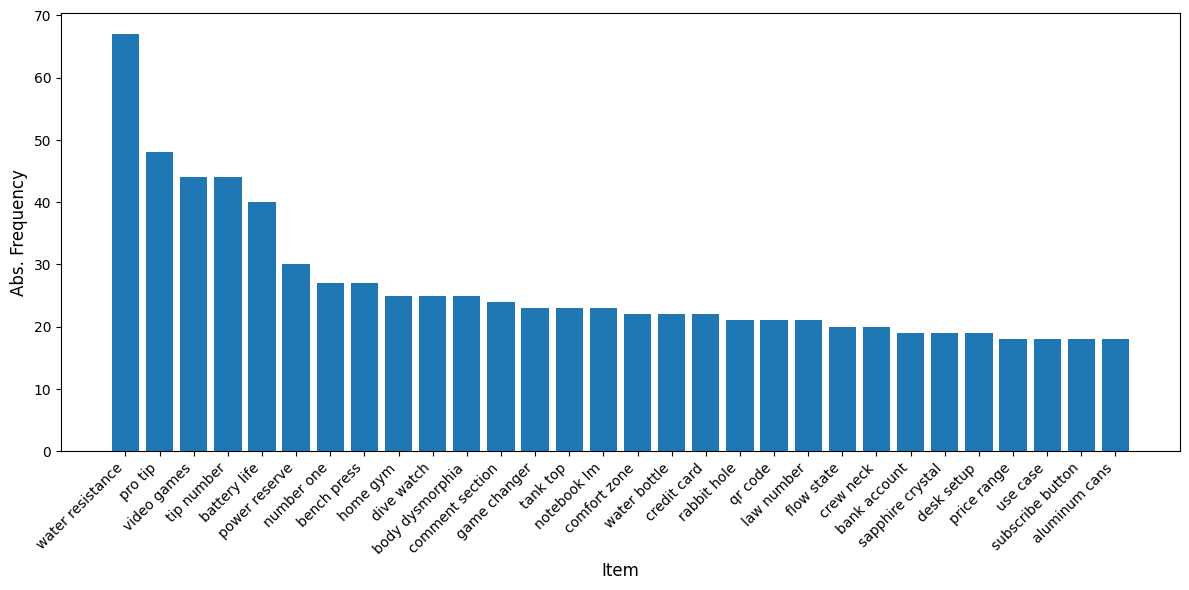

In [122]:
# And now for the YouTube Corpus

visualize_results(flatten_tupled_freqs(find_noun_noun_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

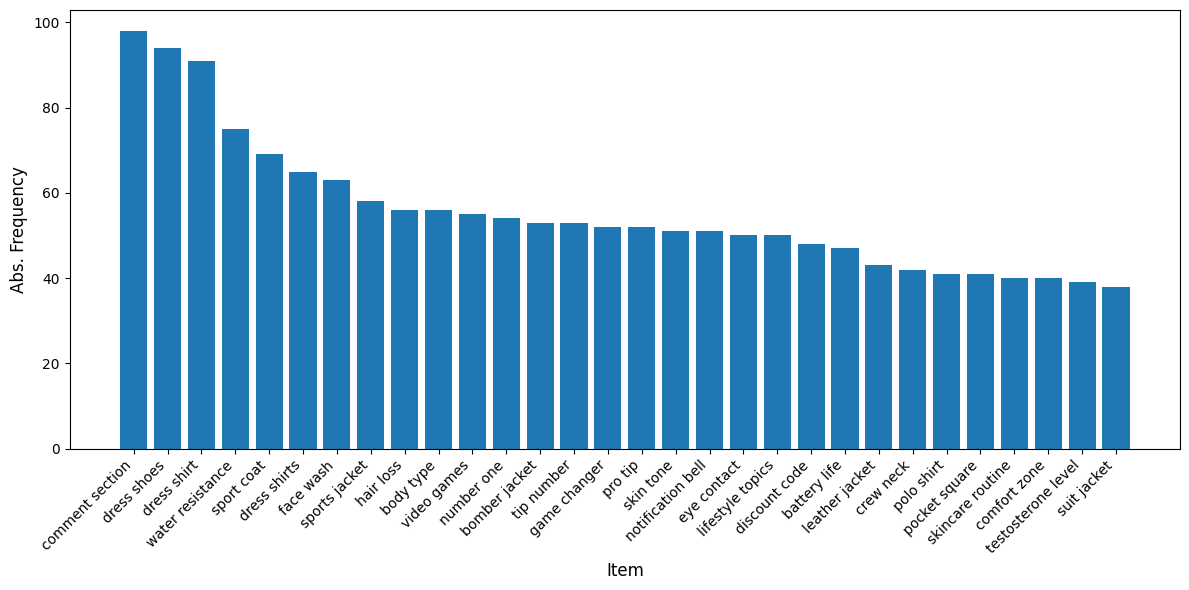

In [123]:
visualize_results(flatten_tupled_freqs(find_noun_noun_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

# Noun + Noun + Noun

In [124]:
# Define the function (noun + noun + noun combos)

def find_noun_x3_collocs(annotated, top=30):
    interim = []
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    i = word.id
                    if word.upos == "NOUN" and word.deprel == "compound" and h == i + 1 and sentence.words[h - 1].head == i + 2 and sentence.words[sentence.words[h - 1].id].upos == "NOUN":
                        interim.append([word.text.lower(), sentence.words[h - 1].text.lower(), sentence.words[sentence.words[h - 1].id].text.lower()])
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                h = word.head
                i = word.id
                if word.upos == "NOUN" and word.deprel == "compound" and h == i + 1 and sentence.words[h - 1].head == i + 2 and sentence.words[sentence.words[h - 1].id].upos == "NOUN":
                    interim.append([word.text.lower(), sentence.words[h - 1].text(), sentence.words[sentence.words[h - 1].id].text.lower()])
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

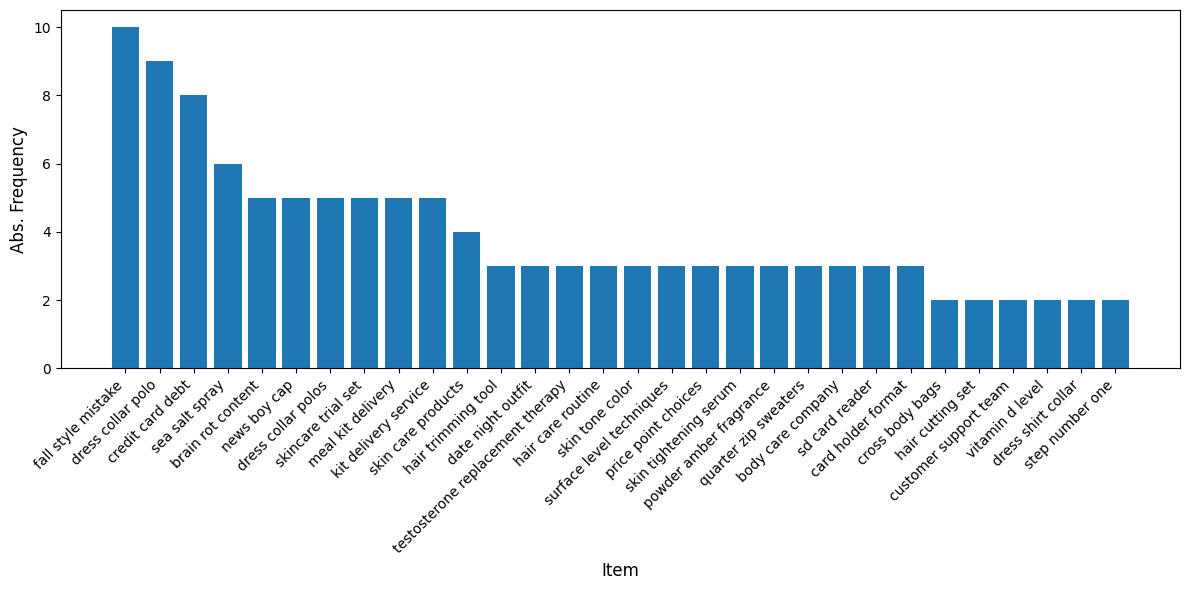

In [125]:
# Let's save time and effort and visualize the results for the Lifesty Corpus (without the interim steps)

visualize_results(flatten_tupled_freqs(find_noun_x3_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

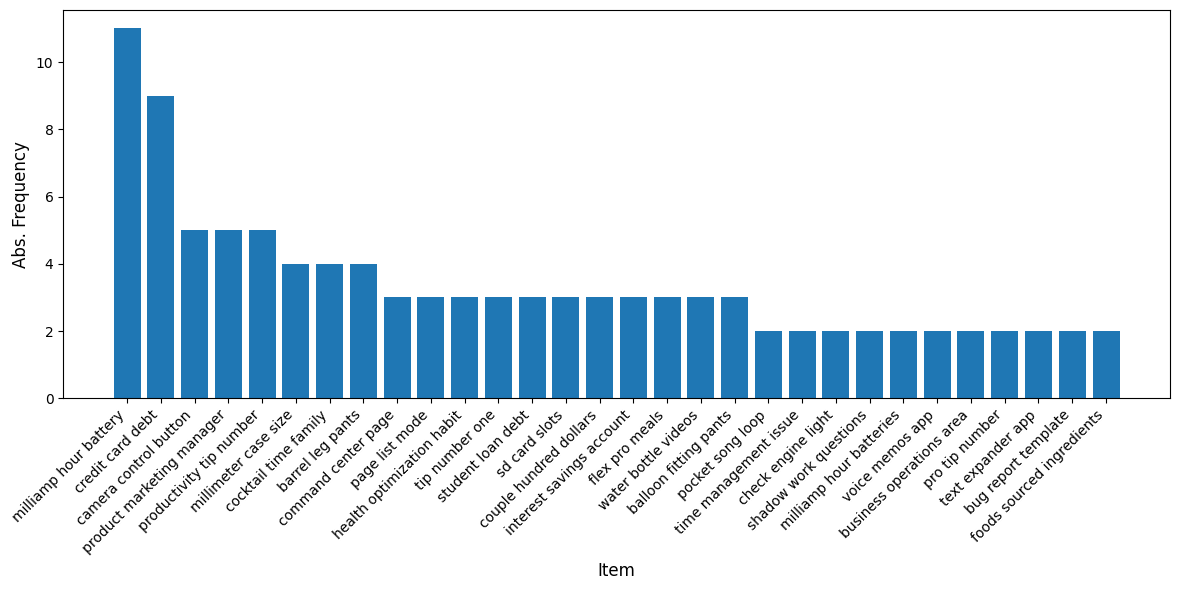

In [126]:
visualize_results(flatten_tupled_freqs(find_noun_x3_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

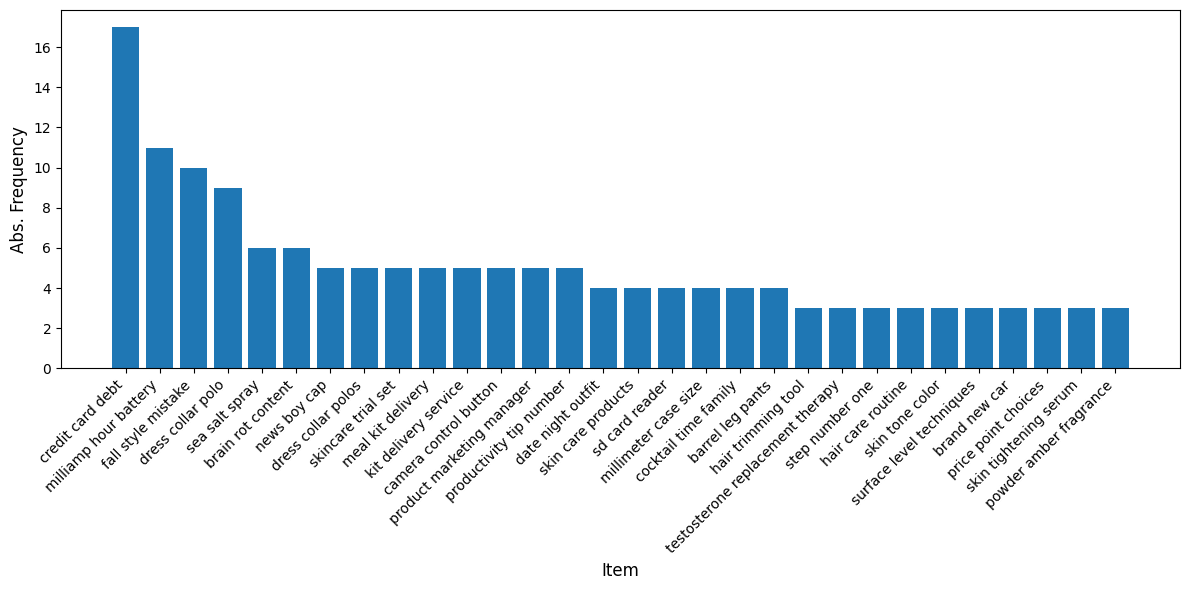

In [127]:
visualize_results(flatten_tupled_freqs(find_noun_x3_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Adjective + Noun + Noun

In [128]:
def find_adj_noun_x2_collocs(annotated, top=30):
    interim = []
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    i = word.id
                    if word.upos == "NOUN" and word.deprel == "compound" and h == i + 1 and sentence.words[i - 2].deprel == "amod":
                        interim.append([sentence.words[i - 2].text.lower(), word.text.lower(), sentence.words[h - 1].text.lower()])
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                h = word.head
                i = word.id
                if word.upos == "NOUN" and word.deprel == "compound" and h == i + 1 and sentence.words[i - 2].deprel == "amod":
                    interim.append([sentence.words[i - 2].text.lower(), word.text.lower(), sentence.words[h - 1].text.lower()])
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

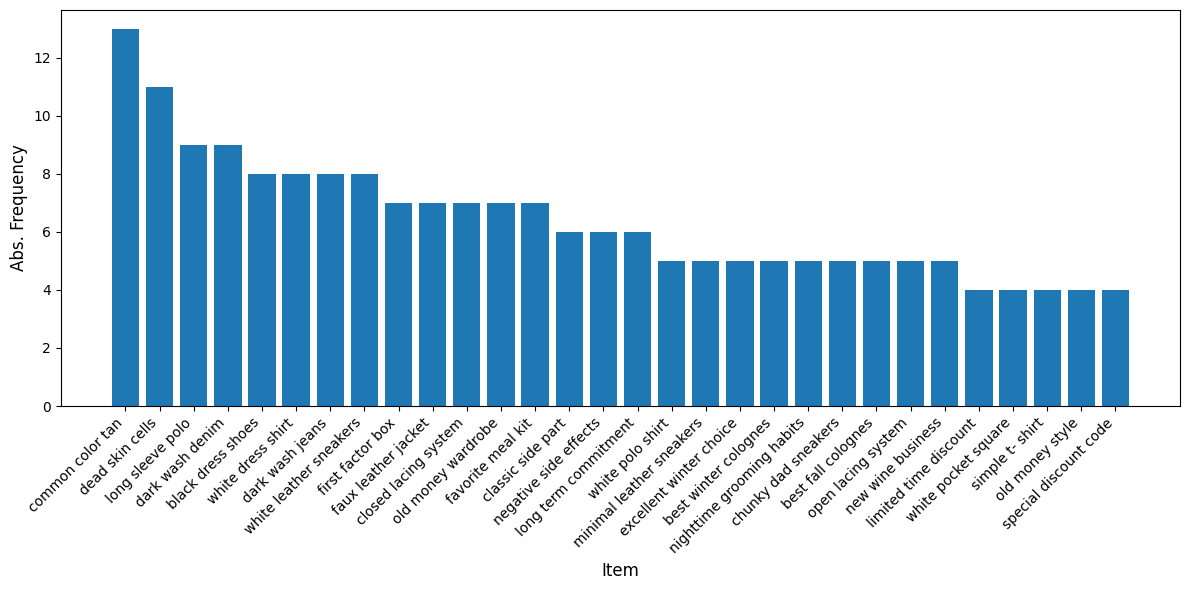

In [129]:
visualize_results(flatten_tupled_freqs(find_adj_noun_x2_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

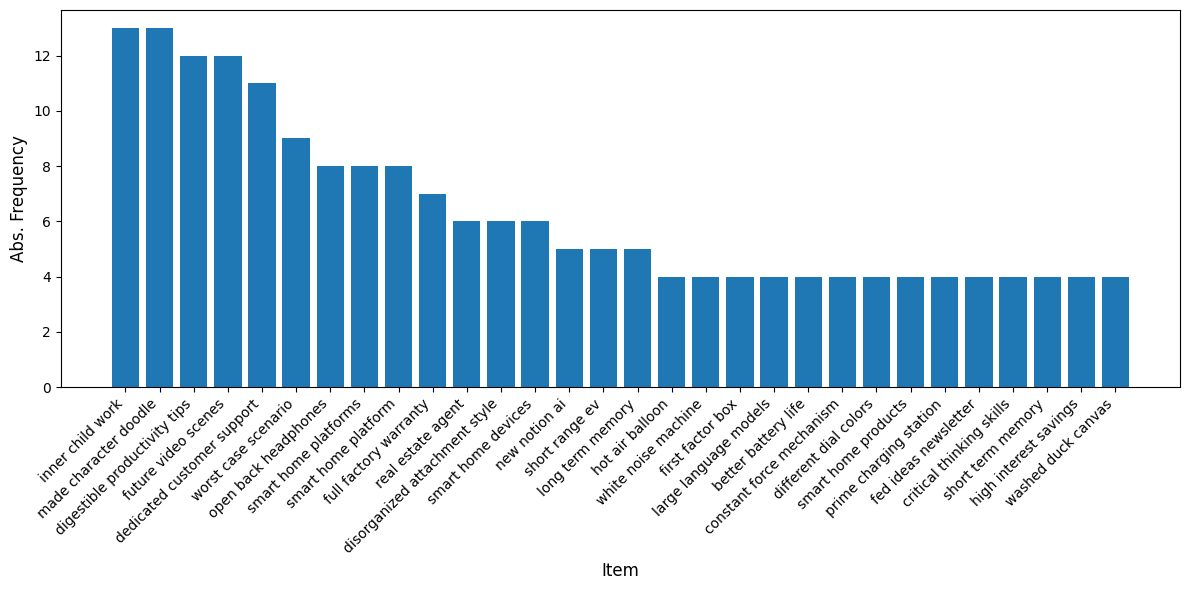

In [130]:
visualize_results(flatten_tupled_freqs(find_adj_noun_x2_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

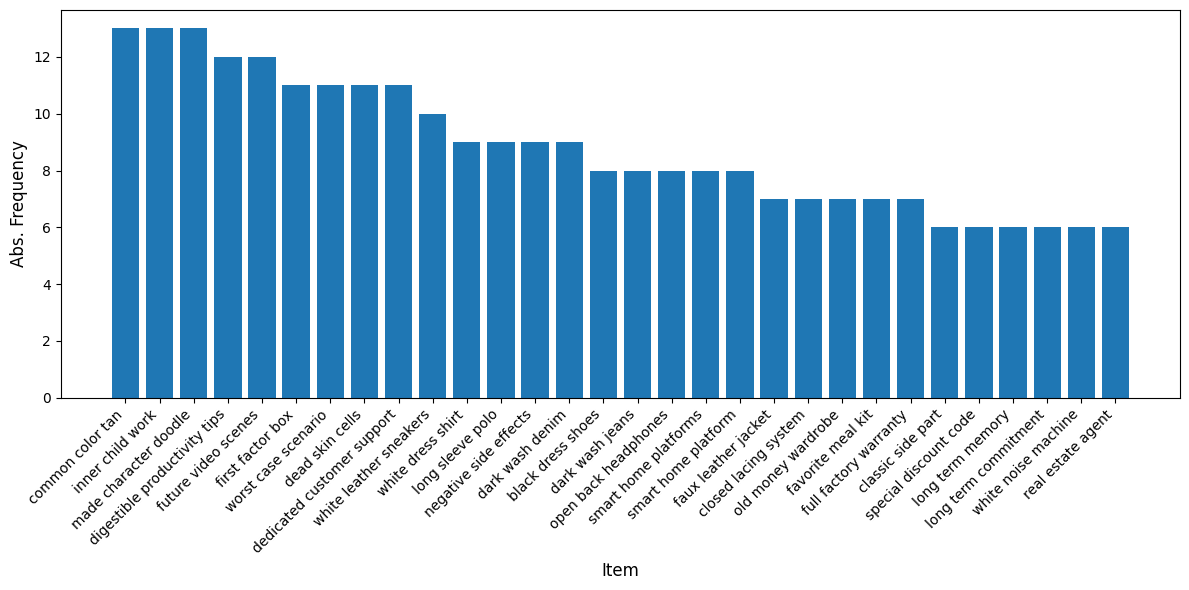

In [131]:
visualize_results(flatten_tupled_freqs(find_adj_noun_x2_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Adverb + Adjective

In [132]:
def find_adv_adj_collocs(annotated, top=30):
    interim = []
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "ADJ":
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
    else:
        for sentence in annotated.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "ADJ":
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

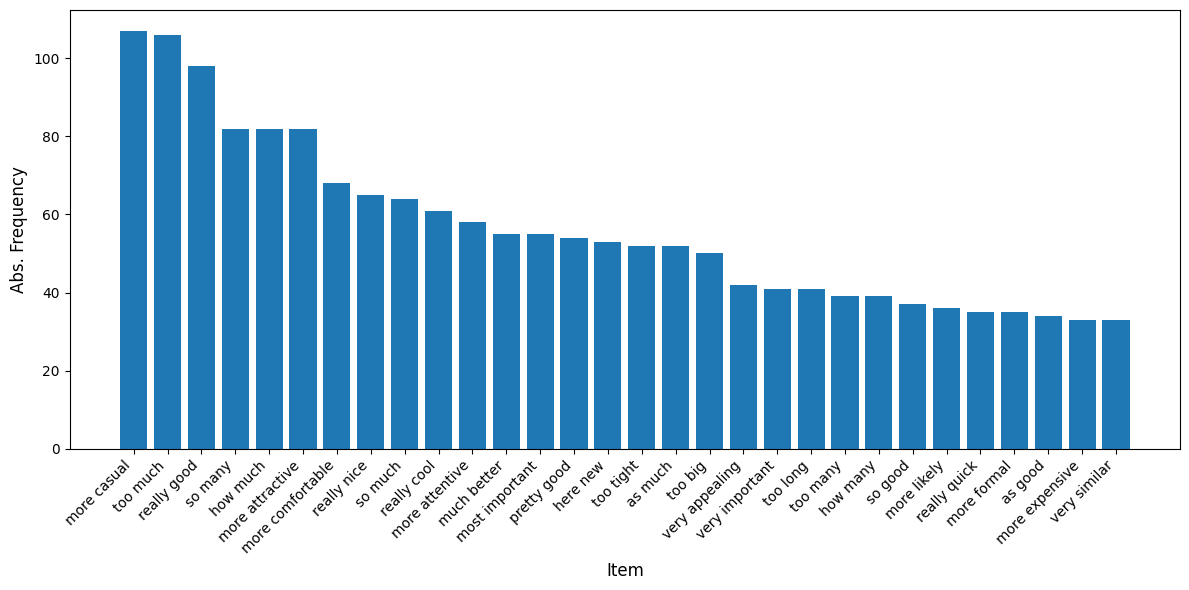

In [133]:
visualize_results(flatten_tupled_freqs(find_adv_adj_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

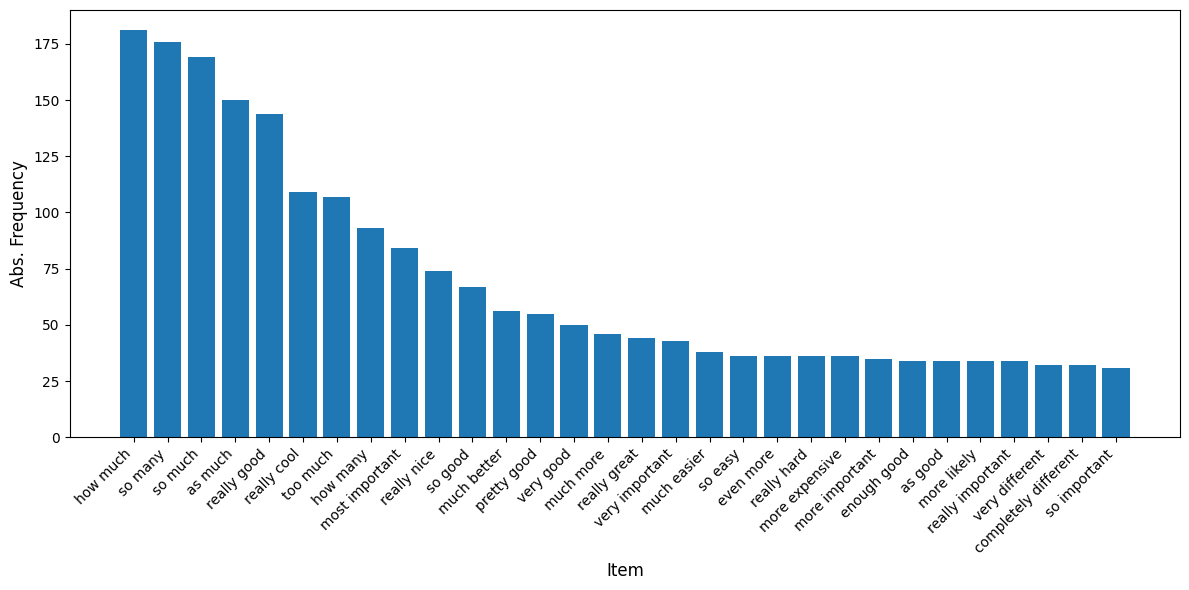

In [134]:
visualize_results(flatten_tupled_freqs(find_adv_adj_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

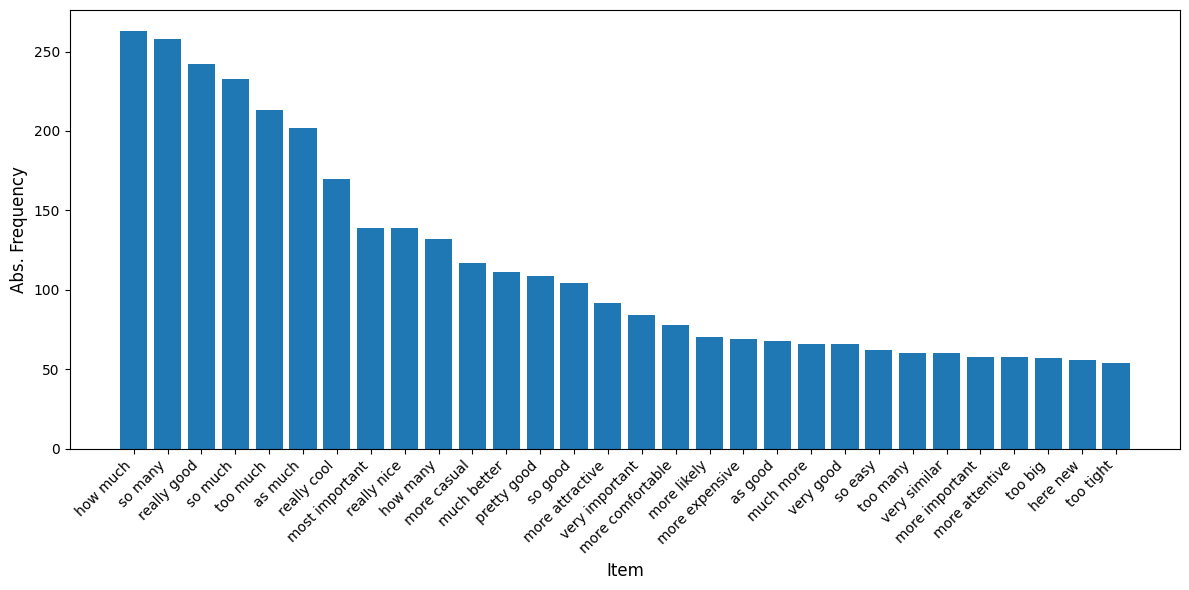

In [135]:
visualize_results(flatten_tupled_freqs(find_adv_adj_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Adv + Adj + Noun

In [136]:
def find_adv_adj_noun_collocs(annotated, top=30):
    interim = []
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.deprel ==  "advmod" and sentence.words[h-1].upos == "ADJ" and sentence.words[sentence.words[h-1].head-1].upos == "NOUN":
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower(), sentence.words[sentence.words[h-1].head-1].text])
    
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                h = word.head
                if word.deprel ==  "advmod" and sentence.words[h-1].upos == "ADJ" and sentence.words[sentence.words[h-1].head-1].upos == "NOUN":
                    interim.append([word.text.lower(), sentence.words[h-1].text.lower(), sentence.words[sentence.words[h-1].head-1].text])
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

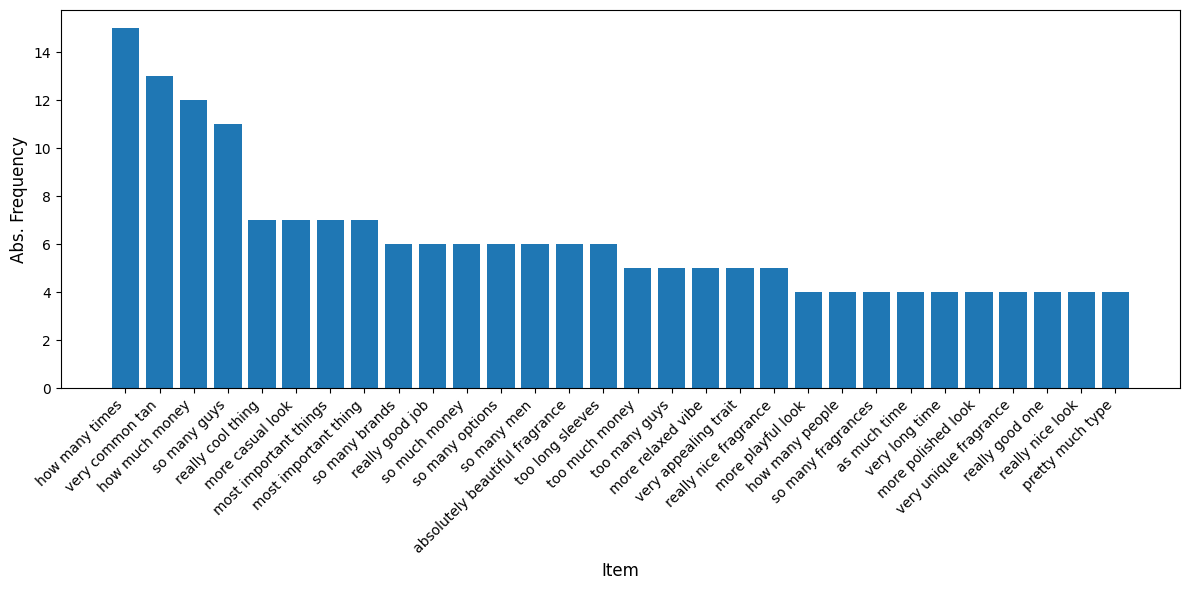

In [137]:
visualize_results(flatten_tupled_freqs(find_adv_adj_noun_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

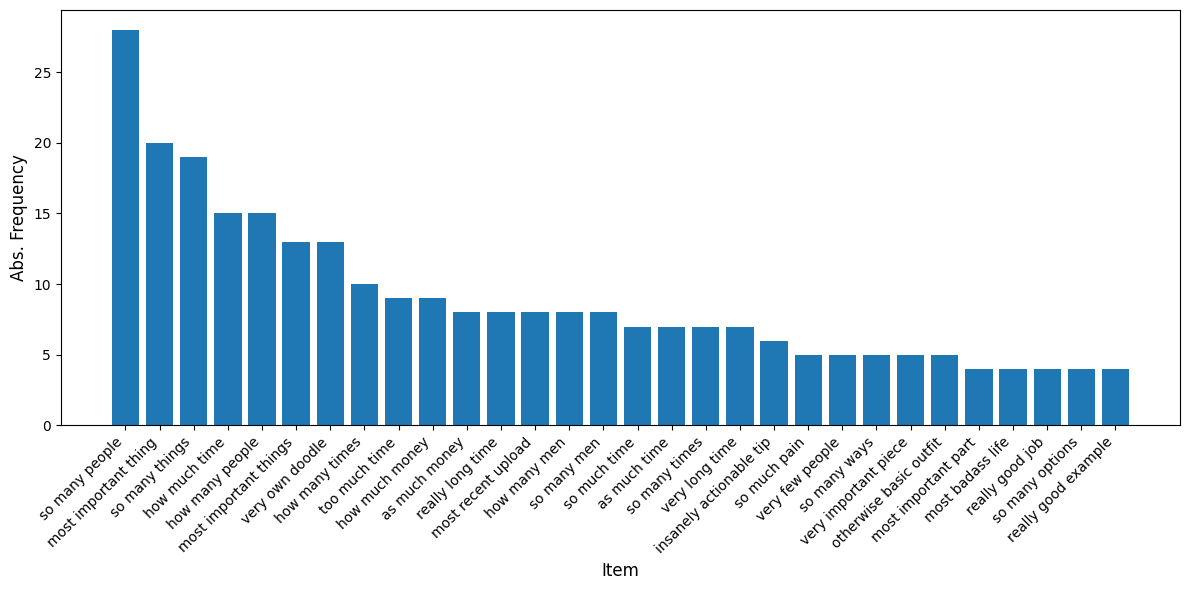

In [138]:
visualize_results(flatten_tupled_freqs(find_adv_adj_noun_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

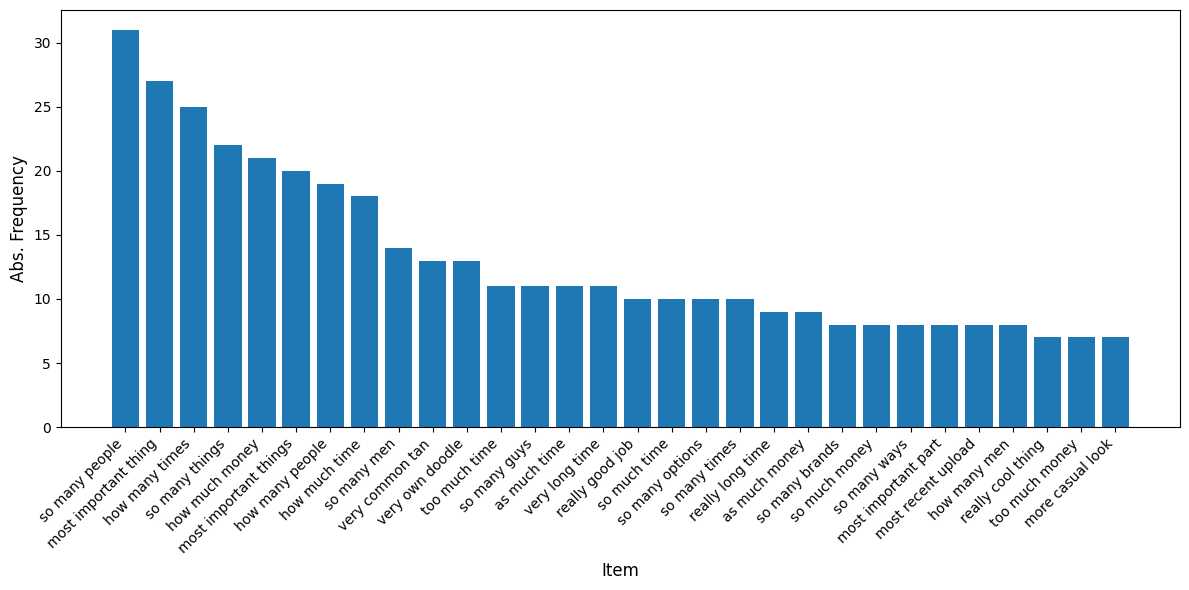

In [139]:
visualize_results(flatten_tupled_freqs(find_adv_adj_noun_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Adverb + Verb / Verb + Adverb

In [140]:
def find_adv_verb_collocs(annotated, top=30):
    interim = []
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    i = word.id
                    h = word.head
                    if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].id > i:
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
                    if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].id < i:
                        interim.append([sentence.words[h-1].text.lower(), word.text.lower()])
    
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                i = word.id
                h = word.head
                if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].id > i:
                    interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
                if word.deprel ==  "advmod" and word.upos == "ADV" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].id < i:
                    interim.append([sentence.words[h-1].text.lower(), word.text.lower()])
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

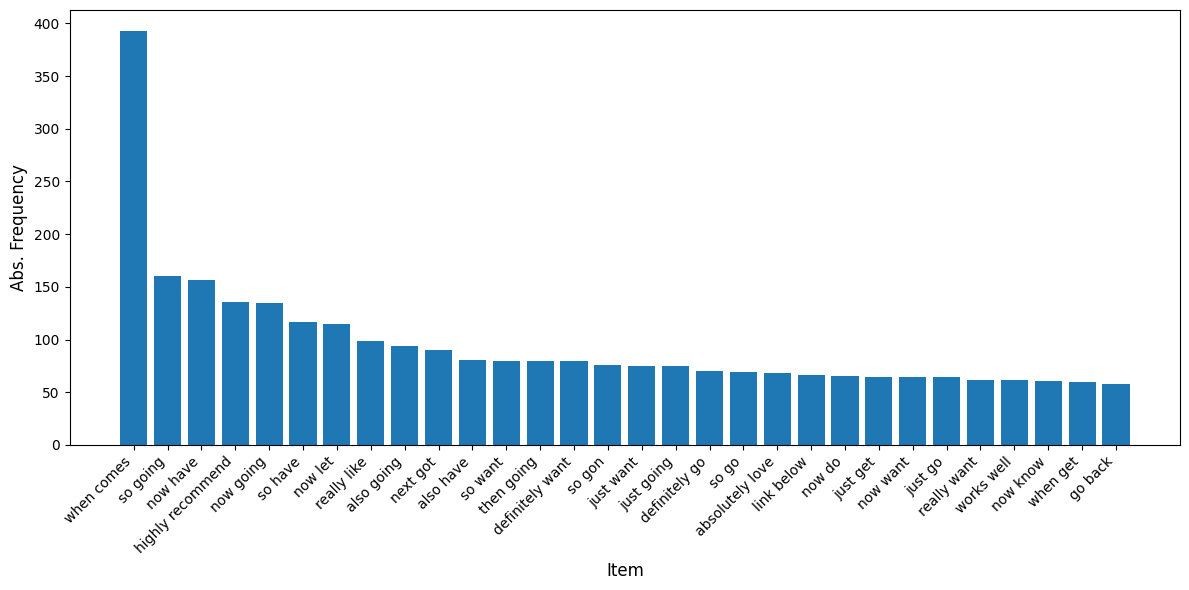

In [141]:
visualize_results(flatten_tupled_freqs(find_adv_verb_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

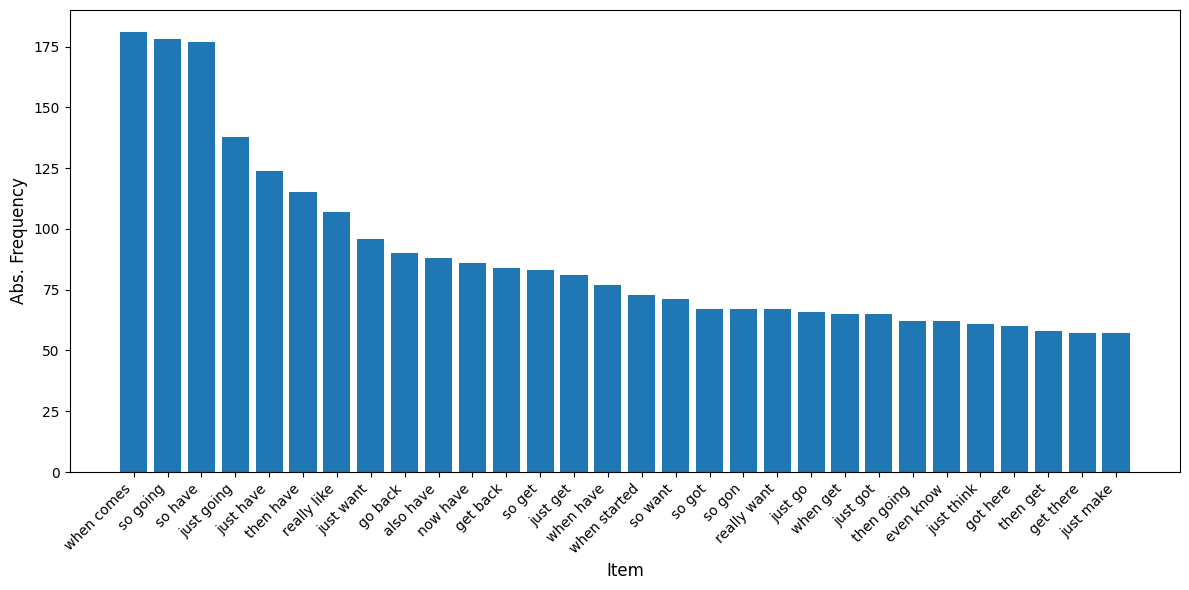

In [142]:
visualize_results(flatten_tupled_freqs(find_adv_verb_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

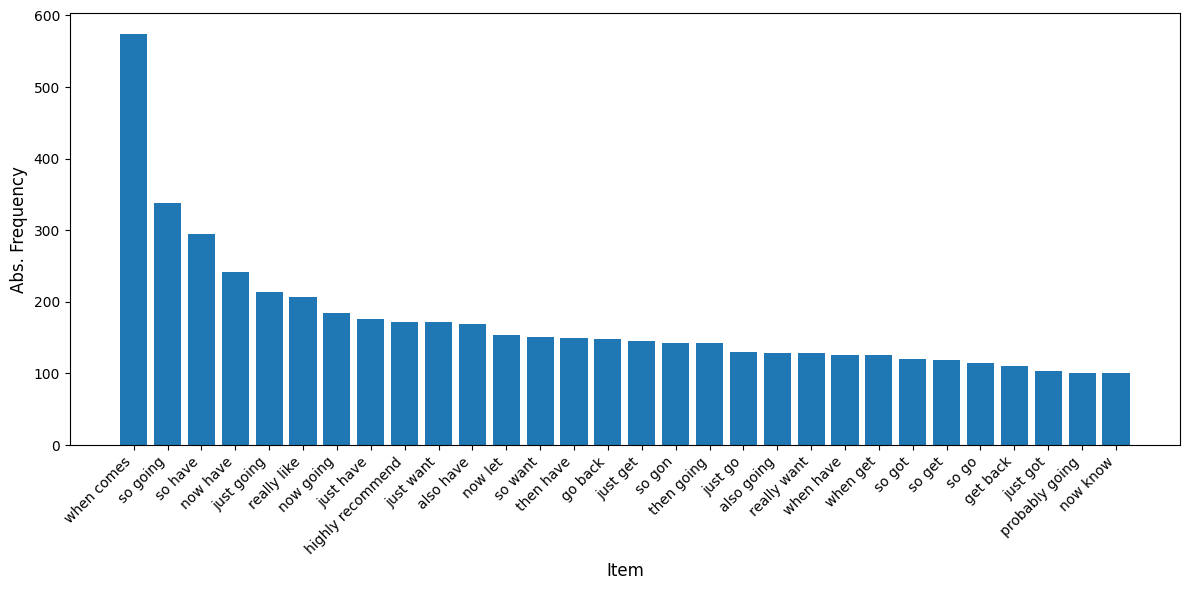

In [143]:
visualize_results(flatten_tupled_freqs(find_adv_verb_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Noun + Adposition + Noun

In [145]:
def find_noun_prep_noun_collocs(annotated, top=30):
    interim = []
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    i = word.id
                    h = word.head
                    if word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos != "DET" and sentence.words[i].upos != "DET":
                        interim.append([sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[h-1].text.lower()])
                    elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos != "DET" and sentence.words[i].upos == "DET":
                        interim.append([sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[i].text.lower(), sentence.words[h-1].text.lower()])
                    elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos == "DET" and sentence.words[i].upos == "DET":
                        interim.append([sentence.words[i-3].text.lower(), sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[i].text.lower(), sentence.words[h-1].text.lower()])
                    elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos == "DET" and sentence.words[i].upos != "DET":
                        interim.append([sentence.words[i-3].text.lower(), sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[h-1].text.lower()])
        
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                i = word.id
                h = word.head
                if word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos != "DET" and sentence.words[i].upos != "DET":
                    interim.append([sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[h-1].text.lower()])
                elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos != "DET" and sentence.words[i].upos == "DET":
                    interim.append([sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[i].text.lower(), sentence.words[h-1].text.lower()])
                elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos == "DET" and sentence.words[i].upos == "DET":
                    interim.append([sentence.words[i-3].text.lower(), sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[i].text.lower(), sentence.words[h-1].text.lower()])
                elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].head == sentence.words[i-2].id and sentence.words[i-2].upos == "NOUN" and sentence.words[i-3].upos == "DET" and sentence.words[i].upos != "DET":
                    interim.append([sentence.words[i-3].text.lower(), sentence.words[i-2].text.lower(), word.text.lower(), sentence.words[h-1].text.lower()])
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

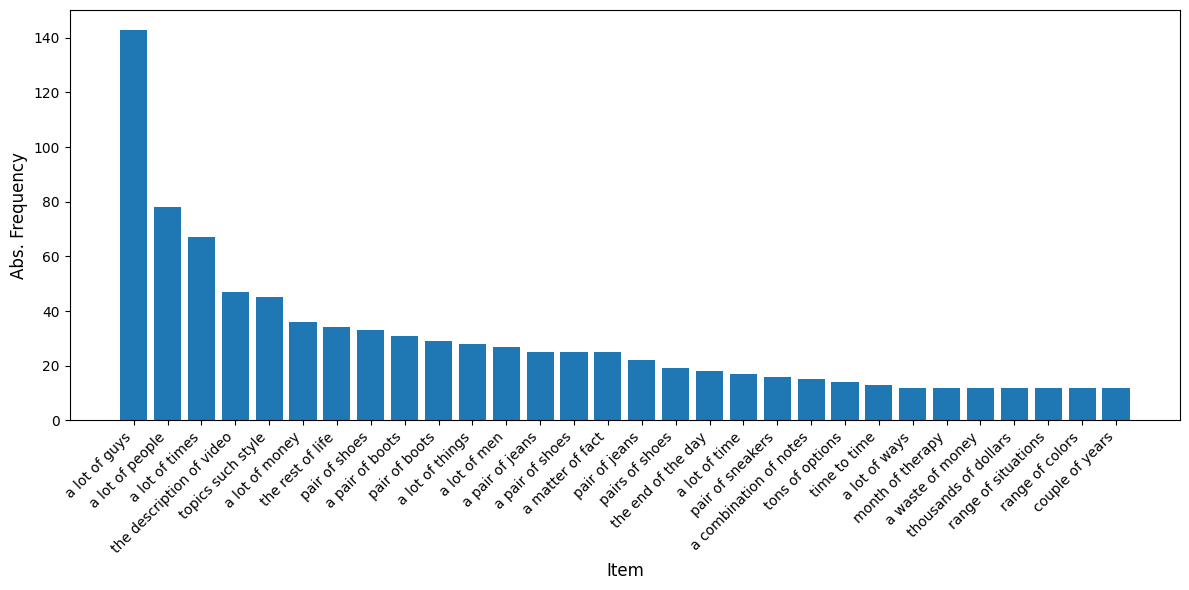

In [146]:
visualize_results(flatten_tupled_freqs(find_noun_prep_noun_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

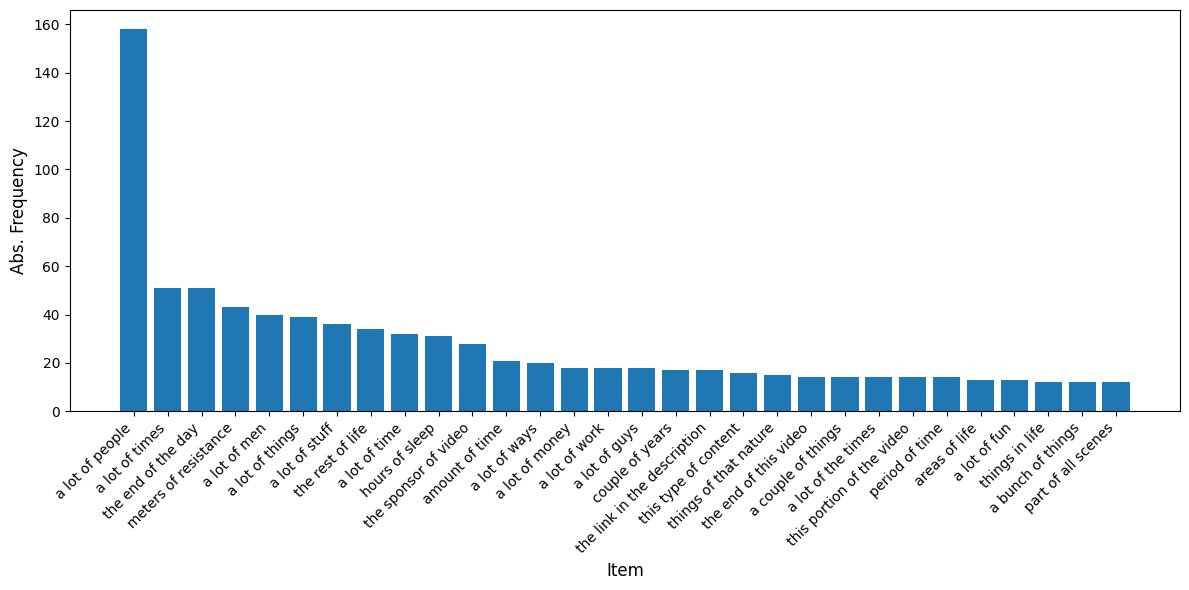

In [147]:
visualize_results(flatten_tupled_freqs(find_noun_prep_noun_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

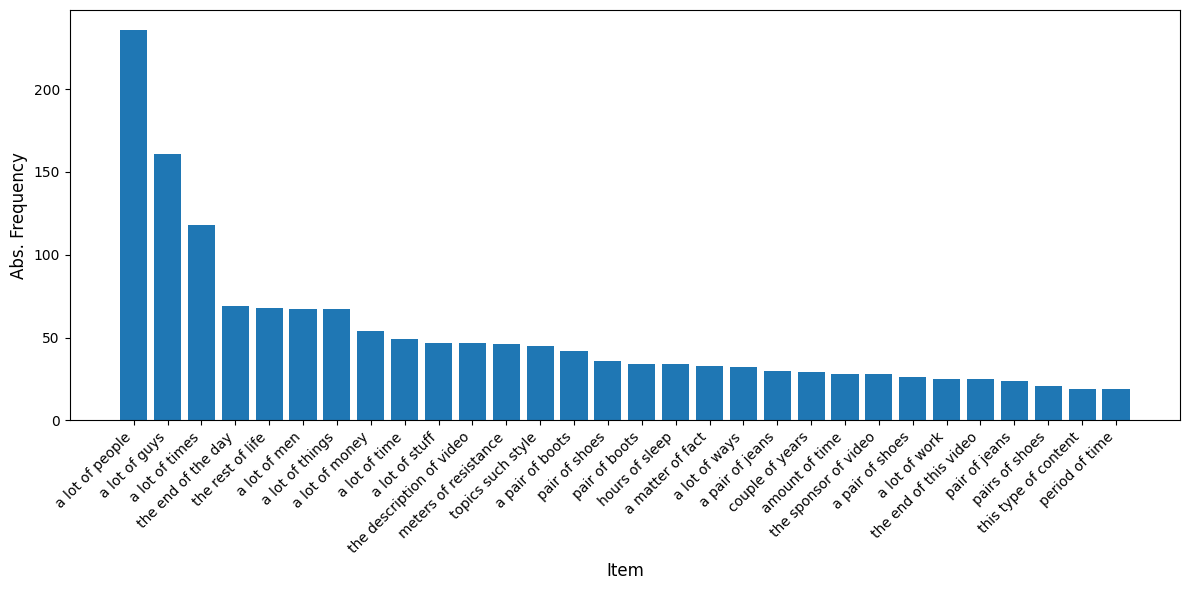

In [148]:
visualize_results(flatten_tupled_freqs(find_noun_prep_noun_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Adposition + Noun

In [149]:
def find_adpos_noun_collocs(annotated, top=30):
    interim = []
    sl = 0
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    i = word.id
                    h = word.head
                    if word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].id == i + 1:
                        interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
                        sl += 1
                    elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].id > i + 1:
                        r = sentence.words[h-1].id - i
                        interim.append([word.text.lower()])
                        for item in range(r):
                            interim[sl].append(sentence.words[i + item].text.lower())
                        sl += 1
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                i = word.id
                h = word.head
                if word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].id == i + 1:
                    interim.append([word.text.lower(), sentence.words[h-1].text.lower()])
                    sl += 1
                elif word.deprel ==  "case" and sentence.words[h-1].upos == "NOUN" and sentence.words[h-1].id > i + 1:
                    r = sentence.words[h-1].id - i
                    interim.append([word.text.lower()])
                    for item in range(r):
                        interim[sl].append(sentence.words[i + item].text.lower())
                    sl += 1
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    return results, freqs

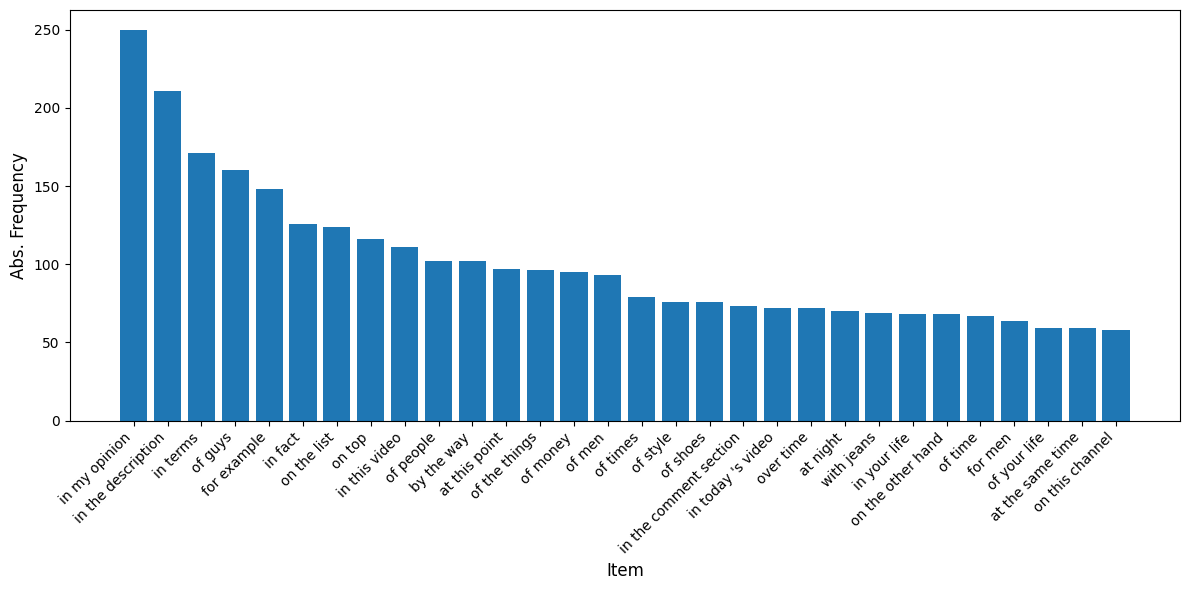

In [234]:
visualize_results(flatten_tupled_freqs(find_adpos_noun_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

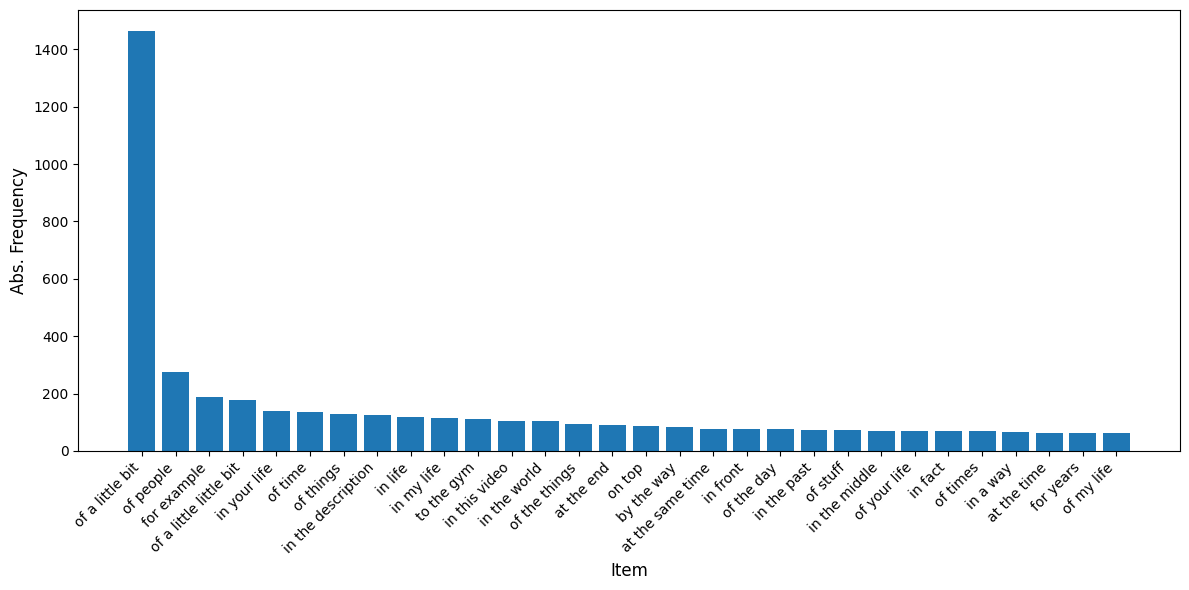

In [235]:
visualize_results(flatten_tupled_freqs(find_adpos_noun_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

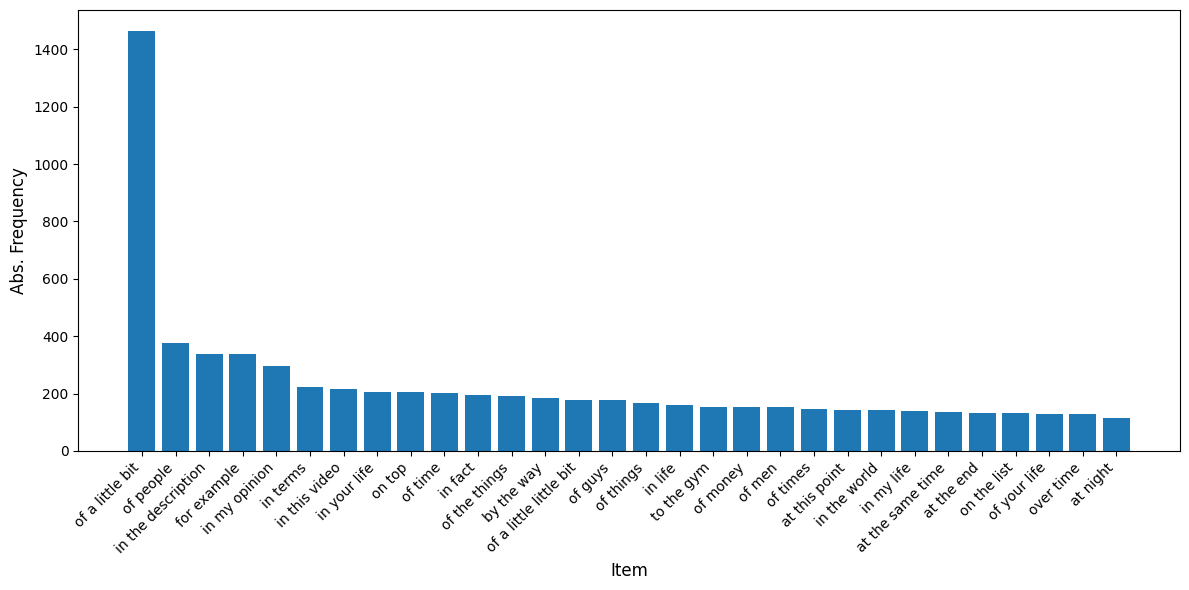

In [236]:
visualize_results(flatten_tupled_freqs(find_adpos_noun_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

## Noun + Adpos

In [257]:
def find_noun_adpos_collocs(annotated, top=30):
    interim = []
    errors = []
    
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    i = word.id
                    try:
                        if word.upos ==  "VERB" and sentence.words[i].upos == "ADP":
                            interim.append([word.lemma.lower(), sentence.words[i].text.lower()])
                    except Exception as e:
                        errors.append(e)

    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                i = word.id
                try:
                    if word.upos ==  "VERB" and sentence.words[i].upos == "ADP":
                            interim.append([word.lemma.lower(), sentence.words[i].text.lower()])
                except Exception as e:
                    errors.append(e)
    
    results = [tuple(sublist) for sublist in interim]
    freqs = Counter(results).most_common(top)
    
    return results, freqs, errors

In [261]:
print(find_noun_adpos_collocs(ls_annotated_docs)[2])

[IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index out of range'), IndexError('list index o

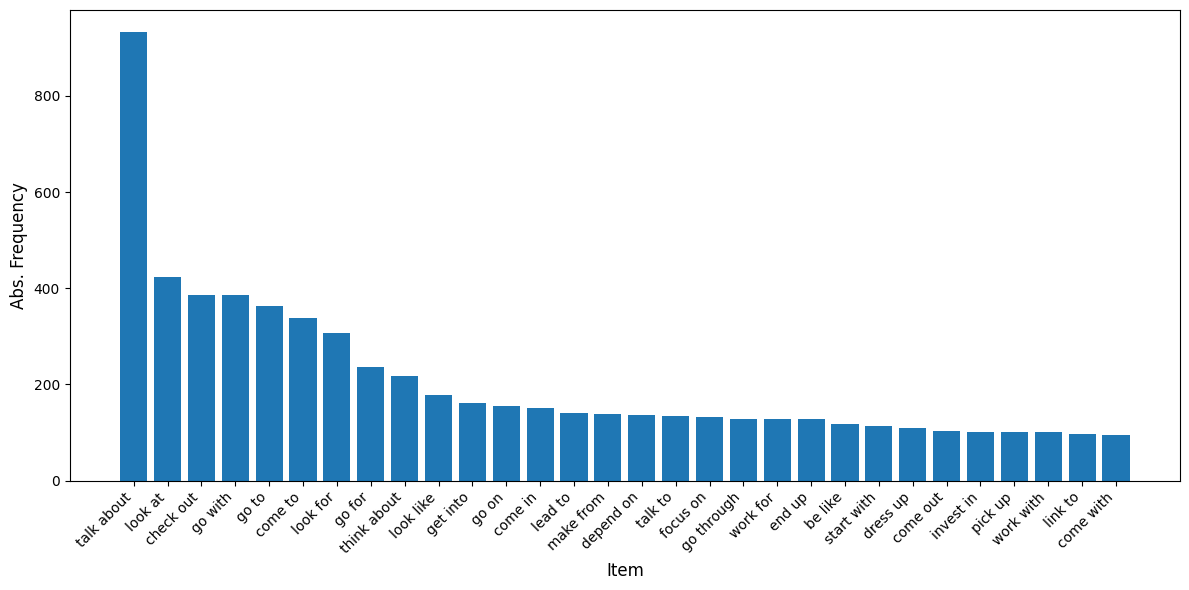

In [259]:
visualize_results(flatten_tupled_freqs(find_noun_adpos_collocs(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

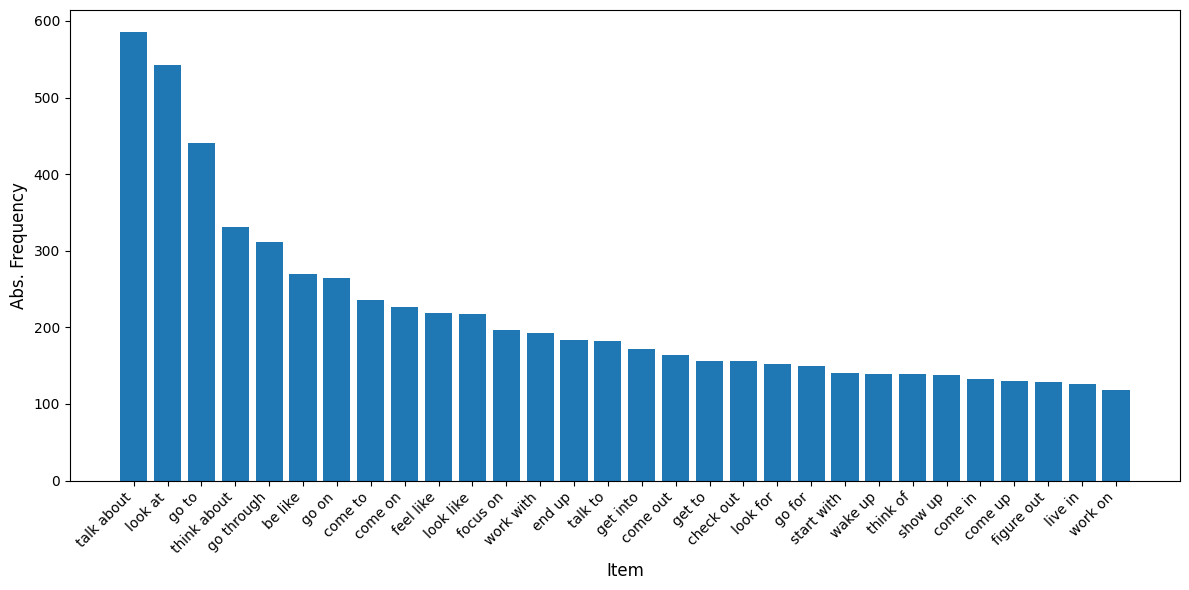

In [262]:
visualize_results(flatten_tupled_freqs(find_noun_adpos_collocs(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

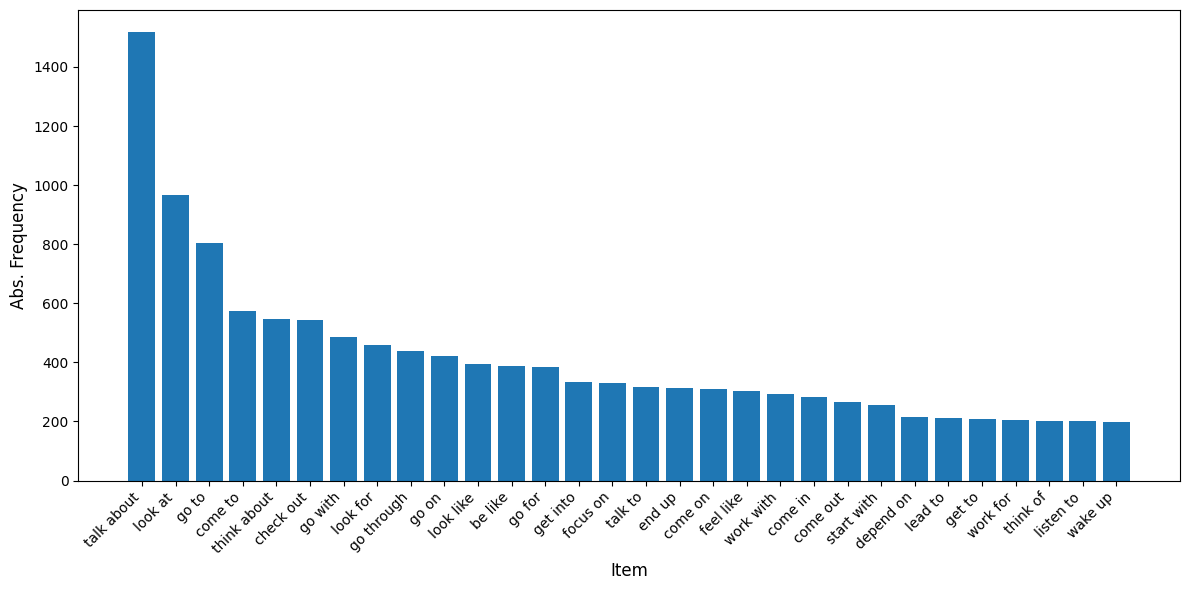

In [263]:
visualize_results(flatten_tupled_freqs(find_noun_adpos_collocs(combined_annotated_docs)[1]), "Item", "Abs. Frequency")

# "Who Does What and How Exactly?"

## (A) Projecting the Authour's Subjectivity (Desires, Feelings, Thinking)
## (B) "I" as the Subject

In [150]:
verbs_of_thinking_and_feeling = [
    "think", "know", "understand", "believe", "suppose", "expect", 
    "doubt", "wonder", "consider", "imagine", "recognize", "remember", 
    "forget", "realize", "assume",
    "love", "hate", "enjoy", "like", "dislike", "fear", "prefer", 
    "detest", "appreciate", "regret",
    "want", "wish", "hope", "desire", "yearn", "crave"
]

In [151]:
# Here only the verbs of feeling and thinking are included (no verbs of perception like seeing, which should otherwise also be part of the mental verbs category)
# The first output [0] is the verbs of thinking and feeling in conjunction with an explicit "I" as the subject (participant of the process).
# The second output [2] is all the verbs that have "I" as the explicit subject (for comparison)
# Also, added the most frequent for these two categories [1], [3]

def find_1st_pers_particip(annotated, top=30):
    mental = []
    verbs_1 = []

    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.lemma ==  "I" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].lemma in verbs_of_thinking_and_feeling:
                        mental.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                    elif word.lemma ==  "I" and sentence.words[h-1].upos == "VERB":
                        verbs_1.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                h = word.head
                if word.lemma ==  "I" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].lemma in verbs_of_thinking_and_feeling:
                    mental.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                elif word.lemma ==  "I" and sentence.words[h-1].upos == "VERB":
                    verbs_1.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
    
    res_mental = [tuple(sublist) for sublist in mental]
    res_verbs_1 = [tuple(sublist) for sublist in verbs_1]

    res_mental_freqs = Counter(res_mental).most_common(top)
    res_verbs_1_freqs = Counter(res_verbs_1).most_common(top)

    return res_mental, res_mental_freqs, res_verbs_1, res_verbs_1_freqs

In [152]:
def present_results_for_proc_particip(proc_partic, metric):
    results = []
    results.append([f"Total Count of Processes with {metric}", len(proc_partic[2])])
    results.append([f"Count of \"Subjective\" Processes with {metric}", len(proc_partic[0])])
    df = pd.DataFrame(results, columns=["Metric", "Value"])
    return df     

In [153]:
present_results_for_proc_particip(find_1st_pers_particip(ls_annotated_docs), "\"I\" as Subject")

Metric  Value
0       Total Count of Processes with "I" as Subject  11174
1  Count of "Subjective" Processes with "I" as Su...   4425

In [154]:
present_results_for_proc_particip(find_1st_pers_particip(yt_annotated_docs), "\"I\" as Subject")

Metric  Value
0       Total Count of Processes with "I" as Subject  20112
1  Count of "Subjective" Processes with "I" as Su...   6529

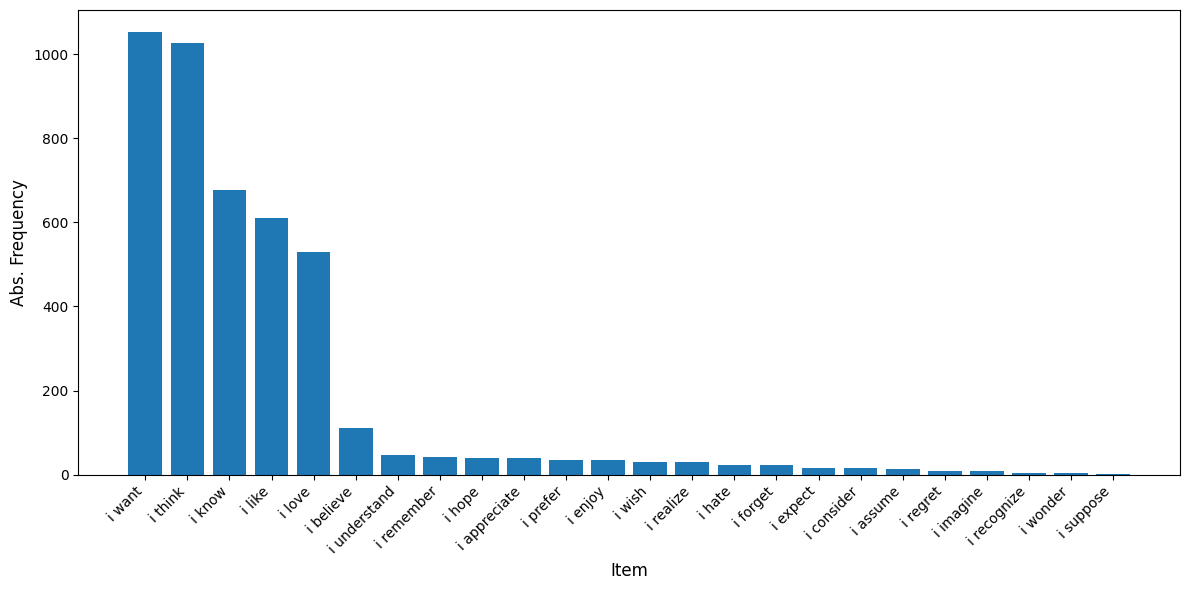

In [155]:
visualize_results(flatten_tupled_freqs(find_1st_pers_particip(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

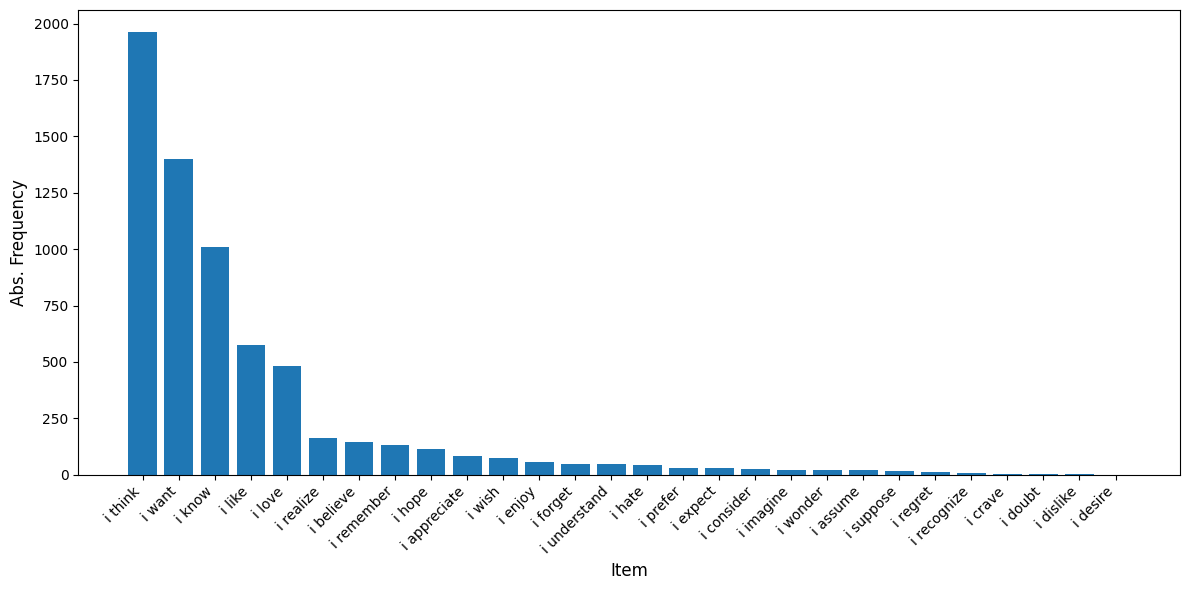

In [156]:
visualize_results(flatten_tupled_freqs(find_1st_pers_particip(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

## "Bossing the Addressee Around" ("You" as the Subject)

In [157]:
# Here only the verbs of feeling and thinking are included (no verbs of perception like seeing, which should otherwise also be part of the mental verbs category)
# The first output is the verbs of thinking and feeling in conjunction with an explicit "you" as the subject (participant of the process).
# The second output is all the verbs that have "you" as the explicit subject (for comparison)
# Also, added the most frequent for these two categories [1], [3]

def find_2nd_pers_particip(annotated, top=30):
    mental = []
    verbs_2 = []

    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    h = word.head
                    if word.lemma ==  "you" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].lemma in verbs_of_thinking_and_feeling:
                        mental.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                    elif word.lemma ==  "you" and sentence.words[h-1].upos == "VERB":
                        verbs_2.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])

    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                h = word.head
                if word.lemma ==  "you" and sentence.words[h-1].upos == "VERB" and sentence.words[h-1].lemma in verbs_of_thinking_and_feeling:
                    mental.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                elif word.lemma ==  "you" and sentence.words[h-1].upos == "VERB":
                    verbs_2.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
    
    res_mental = [tuple(sublist) for sublist in mental]
    res_verbs_2 = [tuple(sublist) for sublist in verbs_2]

    res_mental_freqs = Counter(res_mental).most_common(top)
    res_verbs_2_freqs = Counter(res_verbs_2).most_common(top)

    return res_mental, res_mental_freqs, res_verbs_2, res_verbs_2_freqs

In [158]:
present_results_for_proc_particip(find_2nd_pers_particip(ls_annotated_docs), "\"You\" as Subject")

Metric  Value
0     Total Count of Processes with "You" as Subject  20261
1  Count of "Subjective" Processes with "You" as ...   4472

In [159]:
present_results_for_proc_particip(find_2nd_pers_particip(yt_annotated_docs), "\"You\" as Subject")

Metric  Value
0     Total Count of Processes with "You" as Subject  16467
1  Count of "Subjective" Processes with "You" as ...   4509

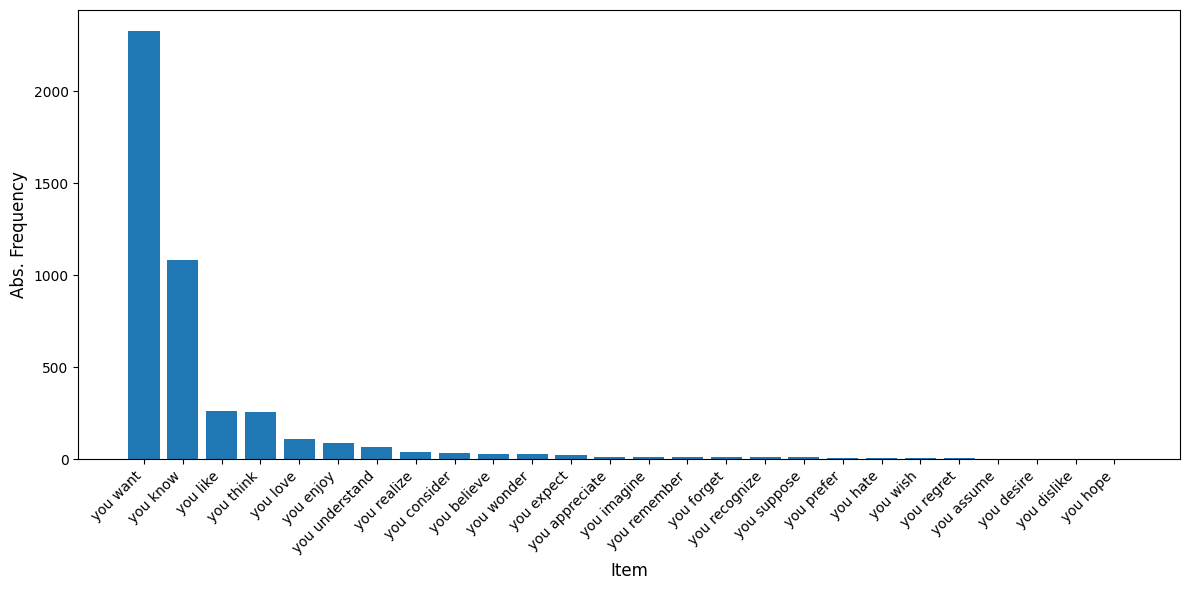

In [160]:
visualize_results(flatten_tupled_freqs(find_2nd_pers_particip(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

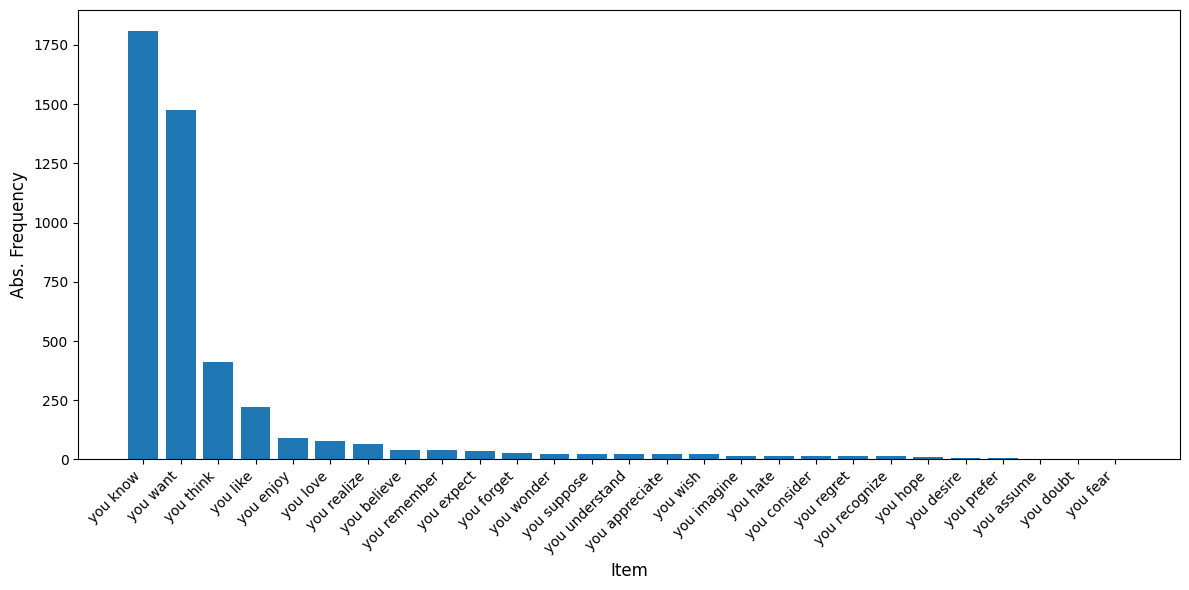

In [161]:
visualize_results(flatten_tupled_freqs(find_2nd_pers_particip(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

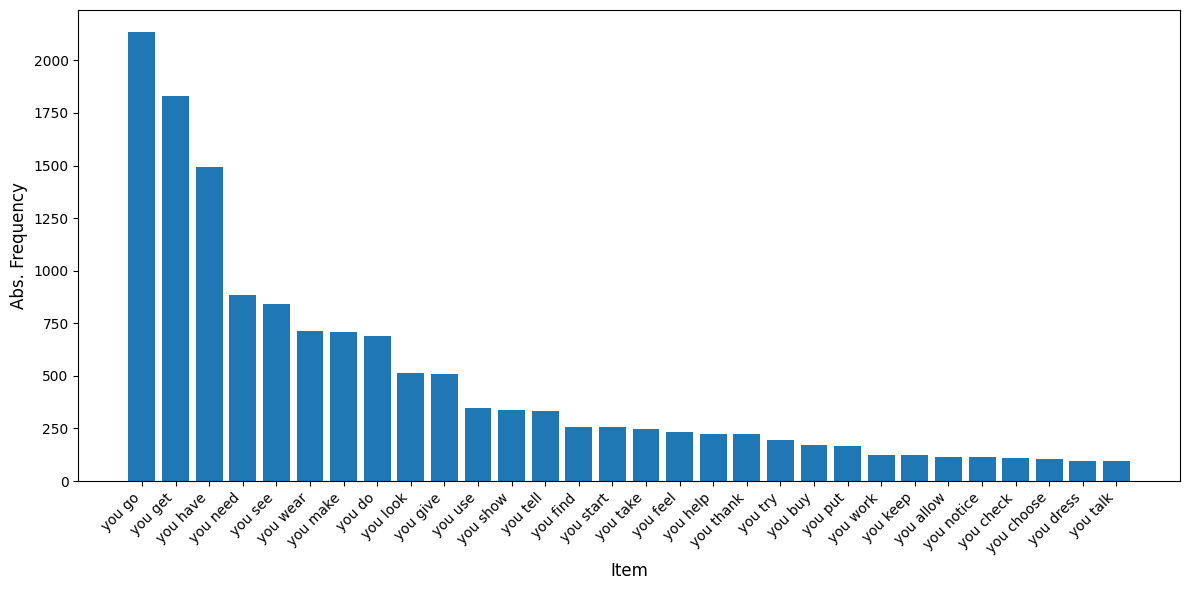

In [162]:
visualize_results(flatten_tupled_freqs(find_2nd_pers_particip(ls_annotated_docs)[3]), "Item", "Abs. Frequency")

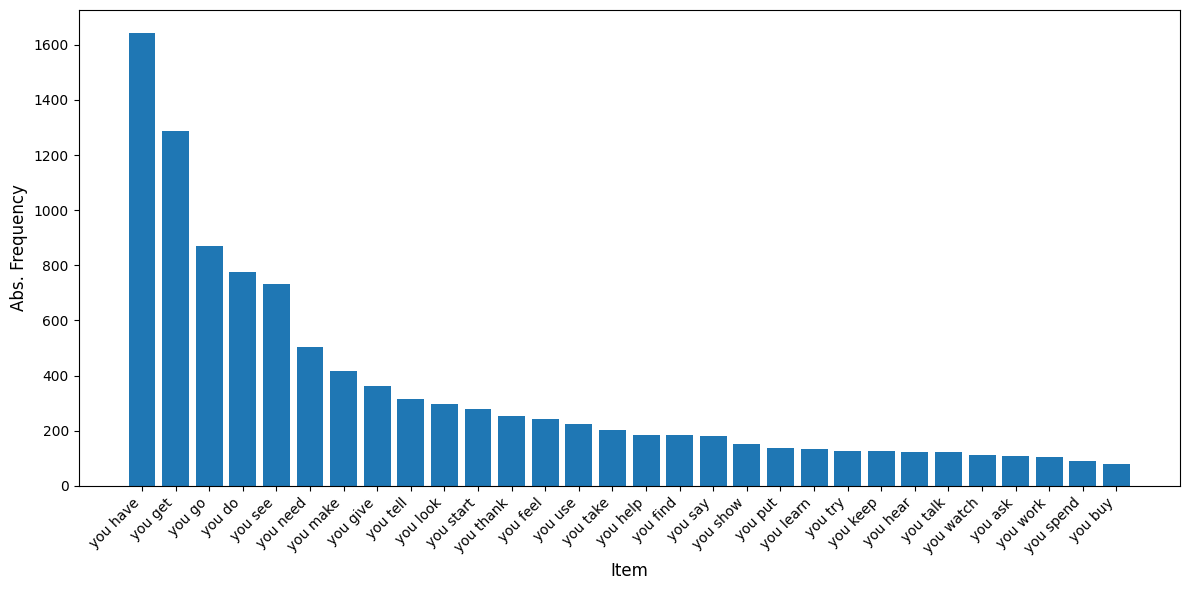

In [163]:
visualize_results(flatten_tupled_freqs(find_2nd_pers_particip(yt_annotated_docs)[3]), "Item", "Abs. Frequency")

## "Bossing the Addressee Around" (Imperatives)

In [164]:
# To complement the structure where "you" is the explicit suject / participant, let's find all the imperative forms
# (A) The impertative arguably also has "you" as the implicit subject
# (B) This can also act as the measure of "perusasivness" of the discourse / register
# The output here is a list of all the imperative forms found and these forms sorted by frequency (top-30 unless specified otherwise)

from collections import Counter

def find_imperatives(annotated, top=30):
    imps = []
    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    if word.feats and "Mood=Imp" in word.feats.split("|"):
                        imps.append(word.lemma.lower())
    
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                if word.feats and "Mood=Imp" in word.feats.split("|"):
                    imps.append(word.lemma.lower())
    
    freqs = Counter(imps).most_common(top)
    
    return imps, freqs

In [165]:
# Let's see the counts for imperatives in the ls and the yt corpus:

print("The number of imperative forms in the LS Corpus is", len(find_imperatives(ls_annotated_docs)[0]))
print("The number of imperative forms in the YT Corpus is", len(find_imperatives(yt_annotated_docs)[0]))

The number of imperative forms in the LS Corpus is 7482
The number of imperative forms in the YT Corpus is 7070


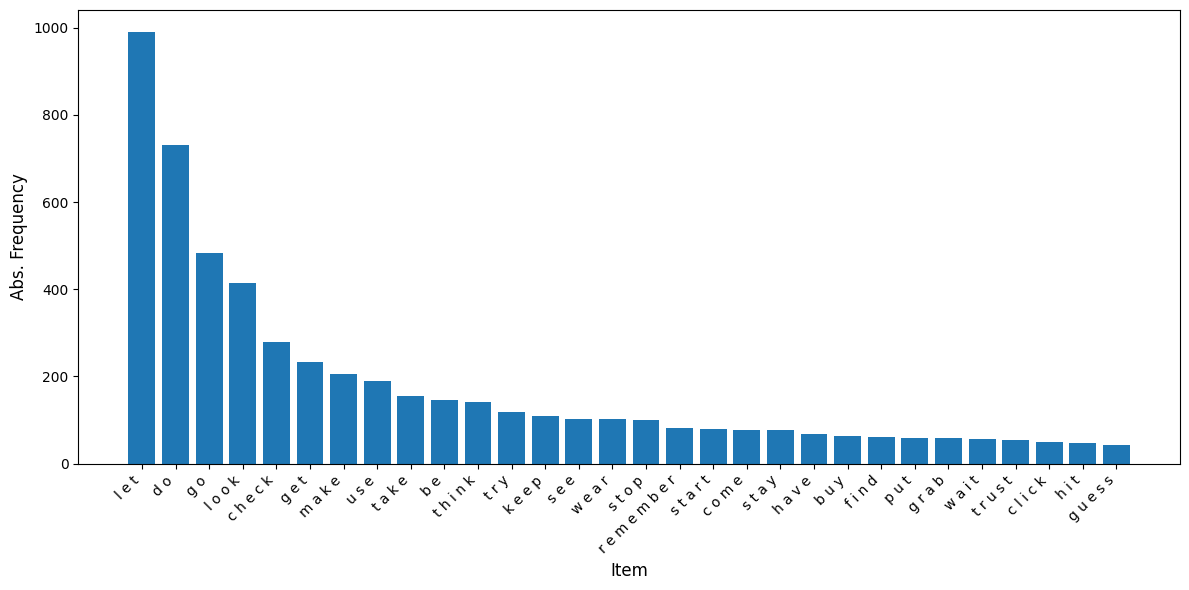

In [166]:
visualize_results(flatten_tupled_freqs(find_imperatives(ls_annotated_docs)[1]), "Item", "Abs. Frequency")

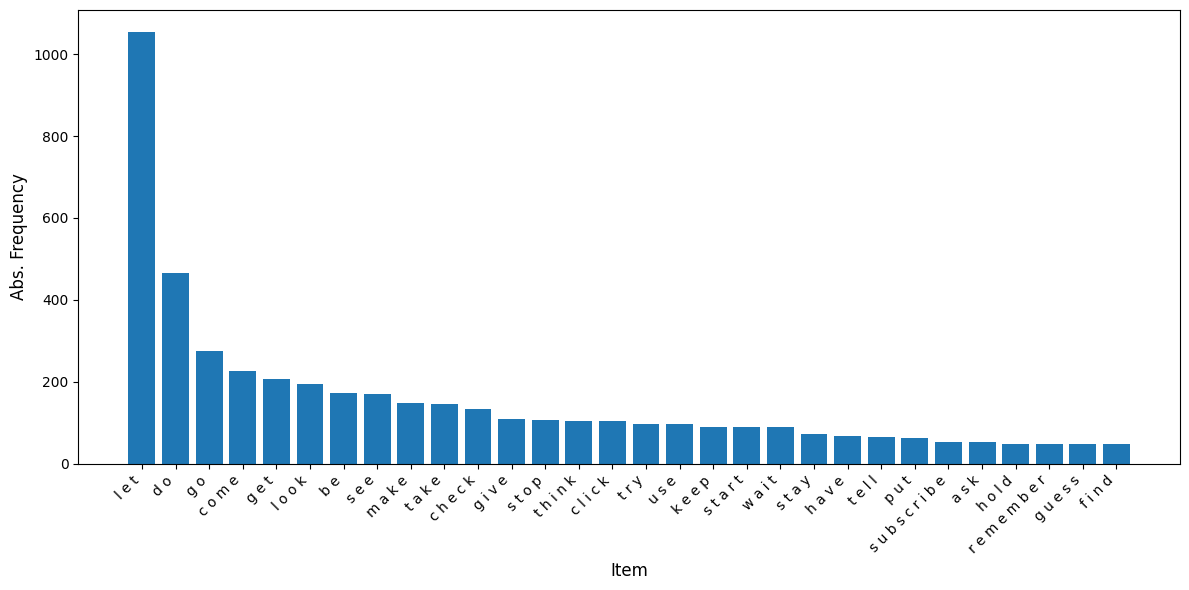

In [167]:
visualize_results(flatten_tupled_freqs(find_imperatives(yt_annotated_docs)[1]), "Item", "Abs. Frequency")

## All the Verbs / Processes

In [302]:
# For the same of comparison, let's find all the finite clauses whith the explicit subject (where a verb has something that acts as an "nsubj" for it)
# Also for the sake of comparison, let's find all the verbs (irrespective of their status e.g. non-finite without explicit subjects)
# And finally all the verbs "to be" (marked as "cop" for their dependency relationship)
# The output follows this order: [0] -- all the verbs in the finite clauses, [1] -- the top most frequent verbs in the subject + verb combos, [2] -- all the verbs, [3] -- the verb "to be"

def find_clauses_and_verbs(annotated, top=30):
    clauses = []
    verbs = []
    copulas = []

    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    if word.upos == "VERB":
                        verbs.append(word.lemma.lower())
                    h = word.head
                    if word.deprel ==  "nsubj" and sentence.words[h-1].upos == "VERB":
                        clauses.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                    if word.deprel == "cop":
                        copulas.append(word.lemma.lower())
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                if word.upos == "VERB":
                    verbs.append(word.lemma.lower())
                h = word.head
                if word.deprel ==  "nsubj" and sentence.words[h-1].upos == "VERB":
                    clauses.append([word.lemma.lower(), sentence.words[h-1].lemma.lower()])
                if word.deprel == "cop":
                    copulas.append(word.lemma.lower())
            
    
    res_clauses = [tuple(sublist) for sublist in clauses]
    res_clauses_freqs = Counter(res_clauses).most_common(top)

    return res_clauses, res_clauses_freqs, verbs, copulas

In [304]:
# Let's save the results to the variables

ls_all_clauses_and_verbs_stats = find_clauses_and_verbs(ls_annotated_docs)
yt_all_clauses_and_verbs_stats = find_clauses_and_verbs(yt_annotated_docs)

In [306]:
print("The total count of \"subject + verb\" combos in the LS Corpus is", len(ls_all_clauses_and_verbs_stats[0]))
print("The total count of verbs in the LS Corpus is", len(ls_all_clauses_and_verbs_stats[2]))
print("To this we also need to add this total number of copulas --", len(ls_all_clauses_and_verbs_stats[3]))

The total count of "subject + verb" combos in the LS Corpus is 60808
The total count of verbs in the LS Corpus is 105816
To this we also need to add this total number of copulas -- 24750


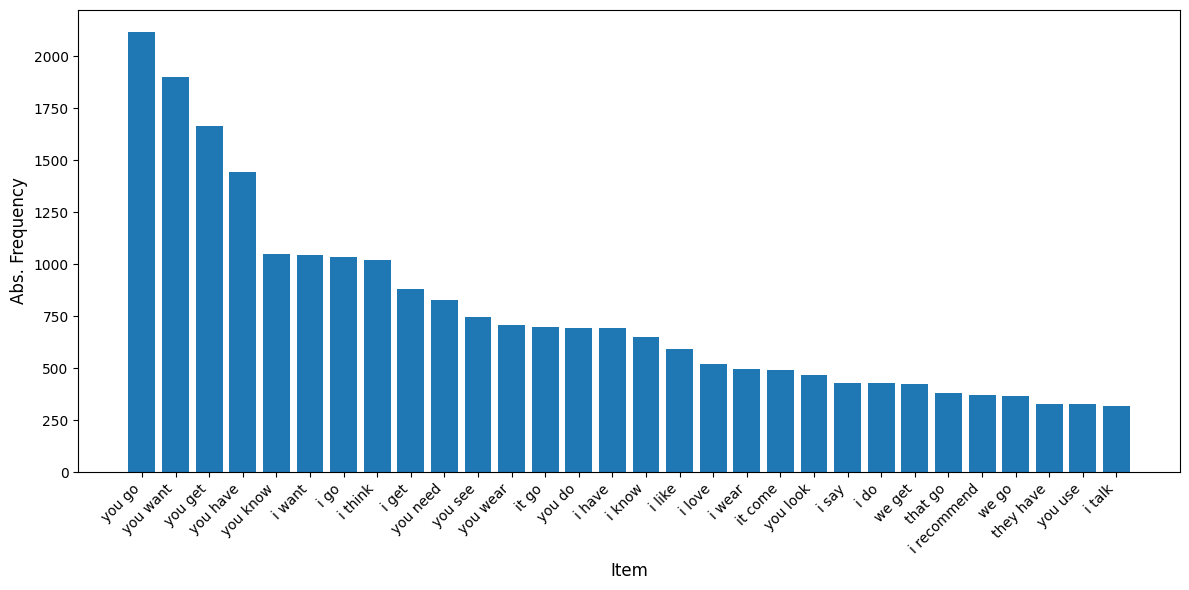

In [308]:
visualize_results(flatten_tupled_freqs(ls_all_clauses_and_verbs_stats[1]), "Item", "Abs. Frequency")

In [309]:
print("The total count of \"subject + verb\" combos in the YT Corpus is", len(yt_all_clauses_and_verbs_stats[0]))
print("The total count of verbs in the YT Corpus is", len(yt_all_clauses_and_verbs_stats[2]))
print("To this we also need to add this total number of copulas --", len(ls_all_clauses_and_verbs_stats[3]))

The total count of "subject + verb" combos in the YT Corpus is 74512
The total count of verbs in the YT Corpus is 127222
To this we also need to add this total number of copulas -- 24750


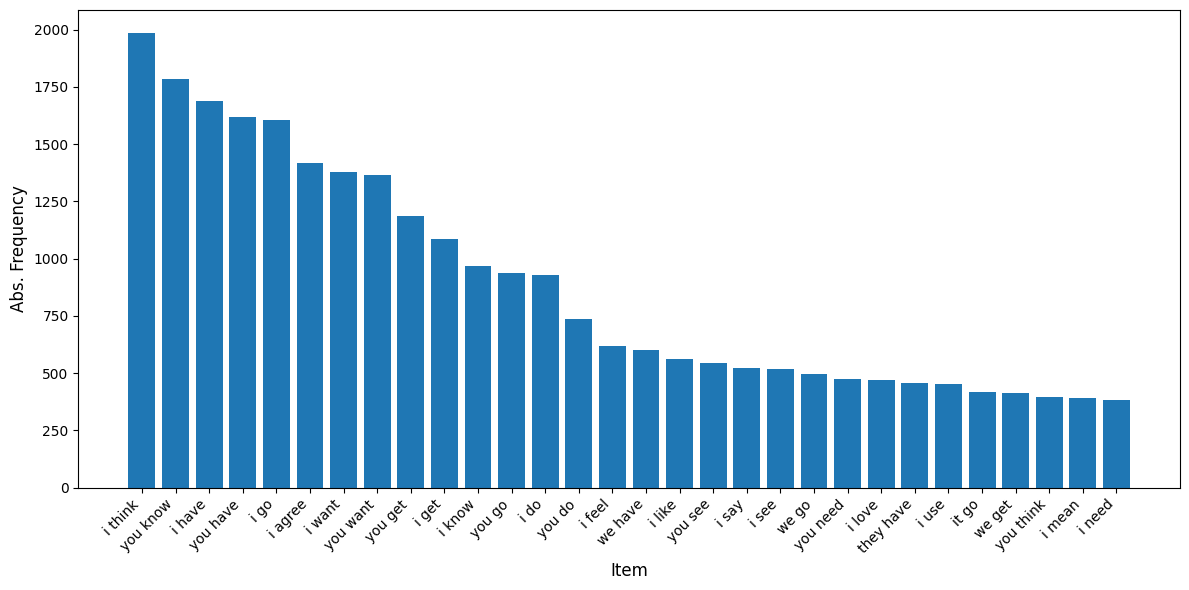

In [310]:
visualize_results(flatten_tupled_freqs(yt_all_clauses_and_verbs_stats[1]), "Item", "Abs. Frequency")

## Types of Processes

In [311]:
# Let's import a dictionary with the most common verbs for different process types (as discussed in SFL)
# import json
with open("sfl_processes.json", "r") as json_file:
    sfl_verb_categories = json.load(json_file)

In [312]:
# Let's find out what types of processes are the most salient in this type of discourse
# The hypothesis (which has been partly substantiated by the data above) is that mental processes account for a very large chunk of all the processes types)

def identify_process_types(annotated, categories, excluded=[]):
    processes_db = dict()

    if isinstance(annotated, list):
        for item in annotated:    
            for sentence in item.sentences:
                for word in sentence.words:
                    if word.upos == "VERB" and word.lemma.lower() in categories["Material"]:
                        processes_db.setdefault("Material", []).append(word.lemma.lower())
                for word in sentence.words:
                    if word.upos == "VERB" and word.lemma.lower() in categories["Mental"]:
                        processes_db.setdefault("Mental", []).append(word.lemma.lower())
                for word in sentence.words:
                    if (word.upos == "VERB" or word.deprel == "cop") and word.lemma.lower() in categories["Relational"] and word.lemma.lower() not in excluded:
                        processes_db.setdefault("Relational", []).append(word.lemma.lower())
                for word in sentence.words:
                    if word.upos == "VERB" and word.lemma.lower() in categories["Behavioral"]:
                        processes_db.setdefault("Behavioral", []).append(word.lemma.lower())
                for word in sentence.words:
                    if word.upos == "VERB" and word.lemma.lower() in categories["Verbal"]:
                        processes_db.setdefault("Verbal", []).append(word.lemma.lower())
                for word in sentence.words:
                    if word.upos == "VERB" and word.lemma.lower() in categories["Existential"]:
                        processes_db.setdefault("Existential", []).append(word.lemma.lower())
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                if word.upos == "VERB" and word.lemma.lower() in categories["Material"]:
                    processes_db.setdefault("Material", []).append(word.lemma.lower())
            for word in sentence.words:
                if word.upos == "VERB" and word.lemma.lower() in categories["Mental"]:
                    processes_db.setdefault("Mental", []).append(word.lemma.lower())
            for word in sentence.words:
                if (word.upos == "VERB" or word.deprel == "cop") and word.lemma.lower() in categories["Relational"] and word.lemma.lower() not in excluded:
                    processes_db.setdefault("Relational", []).append(word.lemma.lower())
            for word in sentence.words:
                if word.upos == "VERB" and word.lemma.lower() in categories["Behavioral"]:
                    processes_db.setdefault("Behavioral", []).append(word.lemma.lower())
            for word in sentence.words:
                if word.upos == "VERB" and word.lemma.lower() in categories["Verbal"]:
                    processes_db.setdefault("Verbal", []).append(word.lemma.lower())
            for word in sentence.words:
                if word.upos == "VERB" and word.lemma.lower() in categories["Existential"]:
                    processes_db.setdefault("Existential", []).append(word.lemma.lower())
            
    return processes_db

In [315]:
# We're going to exclude the verbs in this list from relational because they can also be mental
# And there is no way fro us to get rid of the ambiguity in a project of this scope

excluded_from_relational = ["see", "hear", "feel", "smell", "taste", "sense", "look"]

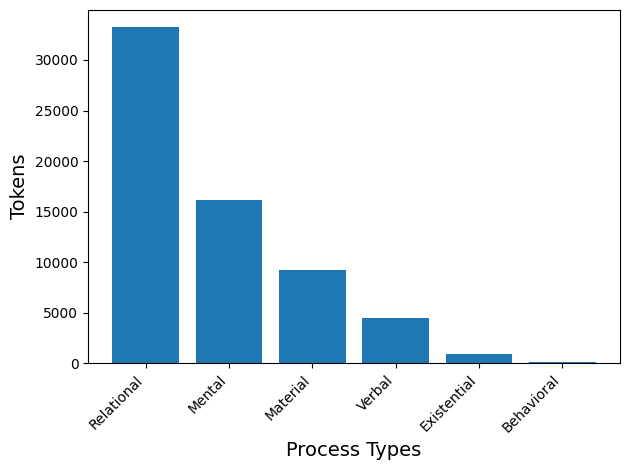

In [ ]:
# Let's visualize the distribution of different process types in the LS Corpus

proc_interim = []
i = 0

for a, b in identify_process_types(ls_annotated_docs, sfl_verb_categories, excluded_from_relational).items():
    proc_interim.append([a])
    proc_interim[i].append(len(b))
    i += 1

process_types_distribution = sorted(proc_interim, key=lambda x: x[1], reverse=True)

proc = [item[0] for item in process_types_distribution]
values = [item[1] for item in process_types_distribution]

import matplotlib.pyplot as plt
plt.bar(proc, values)
plt.xticks(rotation=45, ha = "right")
plt.xlabel('Process Types', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.tight_layout()
plt.show()

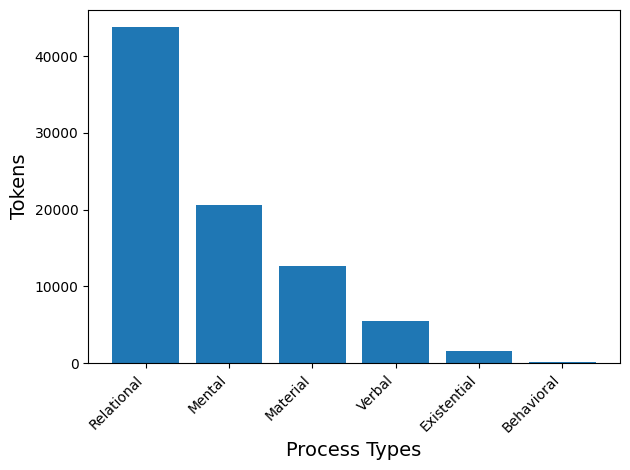

In [ ]:
# And now for the LS Corpus

proc_interim = []
i = 0

for a, b in identify_process_types(yt_annotated_docs, sfl_verb_categories, excluded_from_relational).items():
    proc_interim.append([a])
    proc_interim[i].append(len(b))
    i += 1

process_types_distribution = sorted(proc_interim, key=lambda x: x[1], reverse=True)

proc = [item[0] for item in process_types_distribution]
values = [item[1] for item in process_types_distribution]

# import matplotlib.pyplot as plt
plt.bar(proc, values)
plt.xticks(rotation=45, ha = "right")
plt.xlabel('Process Types', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.tight_layout()
plt.show()

# Bonus: "That" Deletions

In [325]:
# Identify "that" deletions

def identify_that_deletions(annotated):
    interim = []
    sl = 0

    if isinstance(annotated, list):
        for item in annotated:
            for sentence in item.sentences:
                for word in sentence.words:
                    i = word.id
                    h = word.head
                    if word.deprel == "ccomp" and sentence.words[h-1].upos == "VERB":
                        interim.append([sentence.words[h-1].text.lower()])
                        r = i - sentence.words[h-1].id
                        for item in range(r):
                            interim[sl].append(sentence.words[h + item].text.lower())
                        sl += 1
    else:
        for sentence in annotated.sentences:
            for word in sentence.words:
                i = word.id
                h = word.head
                if word.deprel == "ccomp" and sentence.words[h-1].upos == "VERB":
                    interim.append([sentence.words[h-1].text.lower()])
                    r = i - sentence.words[h-1].id
                    for item in range(r):
                        interim[sl].append(sentence.words[h + item].text.lower())
                    sl += 1
    
    full = [sublist for sublist in interim if "that" in sublist]
    deleted = [sublist for sublist in interim if "that" not in sublist]

    return full, deleted

In [328]:
ls_deletions = identify_that_deletions(ls_annotated_docs)
yt_deletions = identify_that_deletions(yt_annotated_docs)

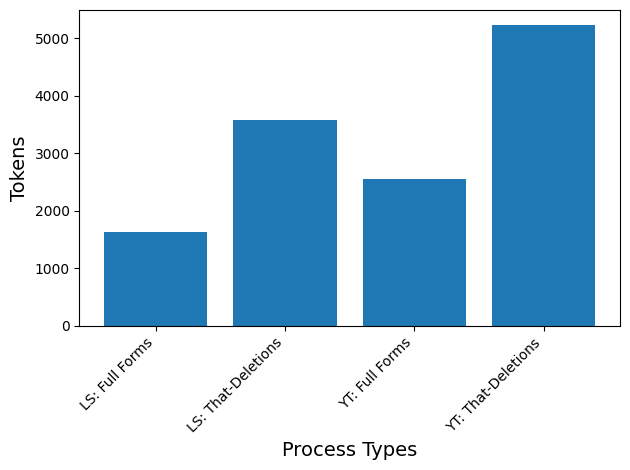

In [329]:
items = ["LS: Full Forms", "LS: That-Deletions", "YT: Full Forms", "YT: That-Deletions"]
item_values = [len(ls_deletions[0])] + [len(ls_deletions[1])] + [len(yt_deletions[0])] + [len(yt_deletions[1])]

plt.bar(items, item_values)
plt.xticks(rotation=45, ha = "right")
plt.xlabel('Process Types', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.tight_layout()
plt.show()